参考: 

https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification

https://www.kaggle.com/code/werus23/g2net-pytorch-with-generated-data

In [1]:
# たまにgpu取れないときあるので取れないときは終わらせる
import torch
if torch.cuda.is_available() == False:
    raise Exception

In [2]:
!nvidia-smi

Sat Nov 26 20:31:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:08:00.0 Off |                  N/A |
|  0%   40C    P8    25W / 350W |     27MiB / 24268MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# papermill parameters
cfg_optimizer = "adamw" # "sam"
device_ids = [0]
epochs = 15
gradient_accumulation_steps = 1
is_syncBN = False

#lr = 5e-3  # 高すぎるみたい
lr = 4e-4

warmup_t = 3
#warmup_t = 1

min_lr_ratio = 1e-2

weight_decay = 1e-5  # 1e-6にしてもほぼ変わらない
#weight_decay = 1e-6

is_wandb = True
n_seeds = 1
cfg_seeds = [0]

cfg_apex = True
#cfg_apex = False  # ampなしにしても変わらず

#BATCH_SIZE = 8  # 8にしても16と変わらず学習遅くなるだけ
BATCH_SIZE = 16
#BATCH_SIZE = 32  # 32以降ぐらいからbatch上げるとepochごとのスコア安定しない
#BATCH_SIZE = 64
#BATCH_SIZE = 128
#BATCH_SIZE = 384

load_model_path = "none"
#load_model_path = "/volume/kaggle/g2net2/output/tmp/tmp_fold0_seed0_best_score.pth"
model_cls = "CustomModel"
#model_cls = "CustomModelDrop"
#model_cls = "CustomModelMultiInput"
#model_cls = "CustomModelLargeKernel"

# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook
cfg_drop_rate = 0.4
cfg_drop_path_rate = 0.2

#MODEL_NAME = ""
#MODEL_NAME = "tf_efficientnetv2_b1"
MODEL_NAME = "tf_efficientnet_b4_ap"
#MODEL_NAME = "tf_efficientnet_b5_ns"
#MODEL_NAME = "tf_efficientnet_b7_ns"
#MODEL_NAME = "seresnext101d_32x8d"
cfg_pretrained = True

n_fold = 5
#trn_fold = [0,1,2,3,4]
#is_trn_allfold = True
trn_fold = [0]
#trn_fold = "[3]"
is_trn_allfold = False

cfg_scheduler = 'CosineLRScheduler'  # warmup
#cfg_scheduler = 'CosineLRScheduler_cycle_limit3'  # warmup

# data params
cfg_ch = 2
cfg_step = 128
#cfg_step = 256
#cfg_step = 340
#cfg_step = 512
#cfg_step = 5760
cfg_spec_max = 4096
#cfg_spec_max = 4224  # 33 * 128
#cfg_spec_max = 5760

size_h, size_w = 360, cfg_step

# train+test set stat img  https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-img4096
# np.mean(p.reshape(freq, step, spec_max//step), axis=2)直後の統計値
cfg_p_mean = [2.4080, 2.3525]  # [H1, L1]
cfg_p_std = [0.6578, 0.8358]  # [H1, L1]

#normalize_type = "default-norm|ts-ma"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-max"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|ts-ma|p-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel|p-stand|ts-ma"
#normalize_type = "largekernel"

cfg_is_add_ch = False
cfg_is_train_zip_dataset = False
cfg_prob_mixup = 0.0

#cfg_prob_sample_mixup = 0.0
#cfg_prob_sample_mixup = 0.5
cfg_prob_sample_mixup = 0.8

cfg_prob_add_sample_nega_mixup = 0.0
#cfg_prob_add_sample_nega_mixup = 0.5

#cfg_prob_mean_mixup = 0.0
cfg_prob_mean_mixup = 0.3

#cfg_prob_noise_band = 0.0
cfg_prob_noise_band = 0.3

#cfg_prob_noise_spot = 0.0
cfg_prob_noise_spot = 0.05

#cfg_prob_noise_vline = 0.0
cfg_prob_noise_vline = 0.2

#cfg_prob_noise_hband = 0.0
cfg_prob_noise_hband = 0.2
cfg_prob_noise_hband = 0.5

cfg_prob_spec_start_random = 0.0
#cfg_prob_spec_start_random = 0.5

#cfg_prob_swap_ch_nega = 0.0
cfg_prob_swap_ch_nega = 0.5

#cfg_prob_flip_nega = 0.0
cfg_prob_flip_nega = 0.5

#cfg_prob_swap_nega = 0.0
cfg_prob_swap_nega = 0.5

cfg_prob_vshift_nega = 0.0
#cfg_prob_vshift_nega = 0.5

#cfg_prob_vshift = 0.0
cfg_prob_vshift = 1.0

#cfg_freq_mask_num = 0  # マスクする横線
#cfg_time_mask_num = 0  # マスクする縦線
cfg_freq_mask_num = 2
cfg_time_mask_num = 1
cfg_freq_mask_param = 10
cfg_time_mask_param = 10
#cfg_freq_mask_param = 30
#cfg_time_mask_param = 50

cfg_cv_col = "target"
#cfg_cv_col = "freq_min//10"
#cfg_cv_col = "freq_min//10_target"

cfg_add_split_str = ""
#cfg_add_split_str = "KFold"
#cfg_add_split_str = "StratifiedKFold"

cfg_is_npy = True
#cfg_is_npy = False

FCOFF = 1e22
#FCOFF = 5e22

ADD_DIRS_STR = ""
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL]"
#ADD_DIRS_STR = "[EX003_NOISE, EX004_SIGNAL, EX004_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL, EX005_SIGNAL_ISO]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX005_SIGNAL1, EX005_SIGNAL_ISO1]"
#ADD_DIRS_STR = "[EX003_NOISE, EX003_NOISE1, EX003_NOISE2, EX004_SIGNAL, EX004_SIGNAL_ISO, EX005_SIGNAL, EX005_SIGNAL_ISO]"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"

IS_ADD_ALL_TRAIN1 = False
#IS_ADD_ALL_TRAIN1 = True


PSEUDO_CSV = ""
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
#cfg_pseudo_max = 0.0  # pseudoの閾値なし
#cfg_pseudo_min = 0.0  # pseudoの閾値なし
#cfg_is_pseudo_hard = True
cfg_is_pseudo_hard = False

cfg_pseudo_type = ""
#cfg_pseudo_type = "real"
#cfg_pseudo_type = "sim"


ADD_PSEUDO_DIRS = ""
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"


is_matplotlib_agg = False
#is_matplotlib_agg = True  # 可視化なしにする

IS_MAKE_SUB = False
#IS_MAKE_SUB = True

#DEBUG = False
DEBUG = True

add_name = ""

In [4]:
# Parameters
add_name = "_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800"
BATCH_SIZE = 64
MODEL_NAME = "tf_efficientnet_b5_ap"
model_cls = "CustomModel"
epochs = 50
normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
cfg_apex = True
cfg_add_split_str = "StratifiedKFold"
ADD_DIRS_STR = "[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, EX006_SIGNAL800, EX006_SIGNAL_ISO800]"
PSEUDO_CSV = "./kaggle_dl/sub_csvs/sub_avg_lb0761.csv"
ADD_PSEUDO_DIRS = "[EX007_NONSTAT_NOISE800]"
cfg_pseudo_max = 0.9
cfg_pseudo_min = 0.1
cfg_is_pseudo_hard = False
IS_ADD_ALL_TRAIN1 = False
IS_MAKE_SUB = True
is_trn_allfold = True
DEBUG = False


In [5]:
# papermillで引数をlistで渡さなかった場合の対策
if isinstance(device_ids, int):
    device_ids = [0]
    
# trn_foldをpapermillで渡したときの対策
if type(trn_fold) is str:
    trn_fold = eval(trn_fold)
    
# 全fold学習
if is_trn_allfold:
    trn_fold = list(range(n_fold))
    
# 複数seedで学習
if n_seeds > 1:
    cfg_seeds = list(range(n_seeds))
    
# ダウンロードしたデータで事前学習する場合はfold=0のみ
if cfg_is_train_zip_dataset:
    trn_fold = [0]
    
# フラグあればch増やす
if cfg_is_add_ch:
    cfg_ch = 2 + 2 
    
# 移動平均の場合は画像の横幅-1する
if "ts-ma" in normalize_type:
    size_w -= 1
    
# フーリエ係数変える場合
if FCOFF != 1e22:
    normalize_type += f"_{str(FCOFF)}"
    
## largekernelを使う場合
#if "largekernel" in normalize_type:
#    cfg_spec_max = 5760
    
# LargeKernelモデルを使う場合
if model_cls == "CustomModelLargeKernel":
    MODEL_NAME = ""
    cfg_step = 5760
    cfg_spec_max = 5760
    size_h, size_w = 360, cfg_step
    normalize_type = "largekernel"
    cfg_prob_mean_mixup = 0.0
    cfg_prob_spec_start_random = 0.0
    cfg_time_mask_param = int( 10 * (cfg_spec_max / 128) )

In [6]:
#import ipynbname
#NAME = ipynbname.name()
if DEBUG:
    NAME = f"tmp"
    #NAME = f"tmp_real"
    #NAME = f"tmp_no-alb"
    #NAME = f"tmp_VerticalFlip"
    #NAME = f"tmp_HorizontalFlip"
    #NAME = f"tmp_no-alb_EX003_NOISE01"
else:
    NAME = f"3090_kqi_ex073{add_name}"
print(NAME)

3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800


# Directory

In [7]:
import os, sys

if "kaggle_web_client" in sys.modules:
    INPUT_DIR_TRAIN = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    INPUT_DIR_TEST = "/kaggle/input/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"

elif "/work" in os.getcwd():
    INPUT_DIR_TRAIN = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    INPUT_DIR_TEST = f"/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves"  # SSD
    OUTPUT_DIR = f"/volume/kaggle/g2net2/output/{NAME}"  # HDD
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex003_generating_noise_gap5000"  # HDD 5000件
    EX004_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/volume-ssd/kaggle_g2net2/pyfstat_output/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_1"  # HDD 800件
    EX005_SIGNAL_ISO1 = f"/volume/kaggle/g2net2/pyfstat_output/ex005_generating_signal_gap_iso_1"  # HDD 800件
    EX006_NOISE1400 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap1400"  # HDD 1400件
    EX006_SIGNAL800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap800"  # HDD 800件
    EX006_SIGNAL_ISO800 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso800"  # HDD 800件
    EX006_NOISE5000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_noise_gap5000"  # HDD 5000件
    EX006_SIGNAL2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap2000"  # HDD 2000件
    EX006_SIGNAL_ISO2000 = f"/volume/kaggle/g2net2/pyfstat_output/ex006_generating_signal_gap_iso2000"  # HDD 2000件
    EX007_NONSTAT_NOISE800 = f"/volume/kaggle/g2net2/pyfstat_output/ex007_generating_noise_nonstationary800"  # HDD 800件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/volume-ssd/kaggle_g2net2/npys"  # SSD
    

elif "/kqi/output" in os.getcwd():
    INPUT_DIR_TRAIN = f"/workspace/g2net2/input"  # cp_SSD
    INPUT_DIR_TEST = f"/kqi/output/g2net-detecting-continuous-gravitational-waves"
    OUTPUT_DIR = f"./output/{NAME}"
    
    # ============================================
    # 生成データのパス
    # ============================================
    EX003_NOISE = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise"  # SSD 500件
    EX003_NOISE1 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise_1_gap"  # SSD 1000件
    EX003_NOISE2 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise_2_gap"  # SSD 3000件
    EX003_NOISE5000 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex003_generating_noise_gap5000"  # SSD 5000件
    EX004_SIGNAL = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex004_generating_signal_gap"  # SSD 200件
    EX004_SIGNAL_ISO = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex004_generating_signal_gap_iso"  # SSD 200件
    EX005_SIGNAL = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap"  # SSD 400件
    EX005_SIGNAL_ISO = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap_iso"  # SSD 400件
    EX005_SIGNAL1 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap_1"  # SSD 800件
    EX005_SIGNAL_ISO1 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex005_generating_signal_gap_iso_1"  # SSD 800件
    EX006_NOISE1400 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_noise_gap1400"  # SSD 1400件
    EX006_SIGNAL800 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap800"  # SSD 800件
    EX006_SIGNAL_ISO800 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap_iso800"  # SSD 800件
    EX006_NOISE5000 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_noise_gap5000"  # SSD 5000件
    EX006_SIGNAL2000 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap2000"  # SSD 2000件
    EX006_SIGNAL_ISO2000 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex006_generating_signal_gap_iso2000"  # SSD 2000件
    EX007_NONSTAT_NOISE800 = f"/workspace/g2net2/pyfstat_output/{normalize_type}/ex007_generating_noise_nonstationary800"  # HDD 800件
    
    # ============================================
    # npyの保存先パス
    # ============================================
    NPY_DIR = f"/workspace/g2net2/pyfstat_output"  # SSD
    
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(OUTPUT_DIR)

/volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800


# Data

In [8]:
import os, sys
import shutil
import cv2
import glob
import random
import h5py
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler

if is_matplotlib_agg:
    import matplotlib
    matplotlib.use('Agg')
    from matplotlib import pyplot as plt
else:
    from matplotlib import pyplot as plt

In [9]:
%reload_ext autoreload
%autoreload 2
from src.zip_dataset import ZipDataset
from src import largekernel

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [10]:
if cfg_is_train_zip_dataset:
    
    zip_path = f'{INPUT_DIR_TRAIN}/../g2net-generated-signals'
    zip_mod = 100
    zip_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod)
    
    # ZipDatasetのラベルをcsvにしておく
    if os.path.exists(f'{zip_path}/zip_df.csv') == False:
        zip_labels = []
        zip_paths = []
        for i, (img, y) in tqdm(enumerate(zip_dataset), total=len(zip_dataset)):
            y = int(y)
            zip_labels.append(y)
            zip_paths.append(f'{zip_path}/archive/{y}_data_{zip_mod*(1+(i)//zip_mod)}/signals_{i%zip_mod}.npy')
            if i == 14900-1:
                break
        zip_df = pd.DataFrame({"id": range(len(zip_labels)), 
                               "target": zip_labels,
                               "path": zip_paths,
                               "fold": -1,
                              })
        zip_df.to_csv(f'{zip_path}/zip_df.csv', index=False)
        

#train_df = pd.read_csv(INPUT_DIR_TRAIN + '/train_labels.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
train_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/train_summary.csv").rename(columns={"Unnamed: 0":'id'})
train_df["path"] = INPUT_DIR_TRAIN + "/train/" + train_df["id"] + ".hdf5"
train_df = train_df[train_df.target >= 0]  # Remove 3 unknowns (target = -1)
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
train_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/train_mean_std.csv").drop(['target'], axis=1)
train_df = pd.merge(train_df, train_ma_img_mean_std, on="id")
print("train_df.shape:", train_df.shape)
#display(train_df)

#test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
# https://www.kaggle.com/code/anonamename/eda-g2net2-detecting-continuous-gw/data?scriptVersionId=109790473
test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
test_df["target"] = 0.5
test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
# 画像の平均、標準偏差列追加
# https://www.kaggle.com/code/anonamename/g2net2-mean-std-calc-ma-img4096?scriptVersionId=110505352
test_ma_img_mean_std = pd.read_csv(f"./kaggle_dl/g2net2_mean_std_calc_ma_img4096_v2/test_mean_std.csv").drop(['target'], axis=1)
test_df = pd.merge(test_df, test_ma_img_mean_std, on="id")

# リアルデータ/シュミレーションデータを区別するためのタイムスタンプのブロックごとでの標準偏差の差の列を追加
# stddiff == 0 はタイムスタンプのブロックごとでの差がない（=ガウスノイズ）なのでシュミレーションデータ
# https://www.kaggle.com/code/anonamename/g2net2-winning-strategy-with-external-data?scriptVersionId=112011488
df_stat_test = pd.read_csv(f"./kaggle_dl/g2net2-winning-strategy-with-external-data_v1/df_stat_test.csv").drop(['fname'], axis=1)
test_df = pd.merge(test_df, df_stat_test, on="id")

print("test_df.shape:", test_df.shape)
#display(test_df)

train_df.shape: (600, 21)
test_df.shape: (7975, 26)


In [11]:
# ==================================================
# test_dfをリアルデータ/シュミレーションデータだけにする
# ==================================================
if cfg_pseudo_type == "real":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] > 0)].reset_index(drop=True)  #  shape: (1497, xxx)
elif cfg_pseudo_type == "sim":
    test_df = test_df[(test_df["h1_stddiff"] + test_df["l1_stddiff"] == 0)].reset_index(drop=True)  #  shape: (6478, xxx)
print("test_df.shape:", test_df.shape)

test_df.shape: (7975, 26)


In [12]:
# ==================================================
# 学習に使う生成データのパスやラベルをcsvにする
# ==================================================
if ADD_DIRS_STR != "":
    add_df_all = None
    for _add_dir in eval(ADD_DIRS_STR):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
        if "generating_noise" in _add_dir:
            _target = 0
        else:
            _target = 1
        add_df = pd.DataFrame({"path": sorted(glob.glob(f"{_add_dir}/*{_suff}")), 
                               "target": _target})
        add_df["id"] = [Path(p).stem for p in add_df["path"]]
        add_df["sqrtSX"] = add_df["id"].apply(lambda x: x.split("_")[1].split("sqrtSX")[1])
        add_df["F0"] = add_df["id"].apply(lambda x: x.split("_")[2].split("F0")[1])

        if "_signal" in _add_dir:
            add_df["F1"] = add_df["id"].apply(lambda x: x.split("_")[3].split("F1")[1])
            add_df["h0deg"] = add_df["id"].apply(lambda x: x.split("_")[4].split("h0deg")[1])

        add_df["type"] = add_df["id"].apply(lambda x: x.split("_")[-1])

        # どのデータかわかるようにディレクトリの名前残しとく
        add_df["dir_name"] = Path(_add_dir).name

        if "ex003_generating_noise" in _add_dir: 
            # gapデータだけにする
            add_df = add_df[add_df["type"] == "gap"]

            ## segmentデータだけにする
            #add_df = add_df[add_df["type"] != "gap"]

        if add_df is None:
            add_df_all = add_df
        else:
            add_df_all = pd.concat([add_df_all, add_df]).reset_index(drop=True)

    add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_df_all.shape:", add_df_all.shape)
    #display(add_df_all)

add_df_all.shape: (8400, 9)


In [13]:
# ==================================================
# for Pseudo
# ==================================================
from sklearn.preprocessing import MinMaxScaler

if PSEUDO_CSV != "":
    pseudo_df = pd.read_csv(PSEUDO_CSV)
    pseudo_df["path"] = INPUT_DIR_TEST + "/test/" + pseudo_df["id"] + ".hdf5"
    #display(pseudo_df)
    
    # 確信度0-1に正規化
    pseudo_df["target"] = MinMaxScaler().fit_transform(pseudo_df["target"].values.reshape(-1, 1))
    #display(pseudo_df)
    
    # 確信度が高い低いものだけ採用
    if cfg_pseudo_max > 0:
        pseudo_df = pseudo_df[ (pseudo_df["target"] > cfg_pseudo_max) | (pseudo_df["target"] < cfg_pseudo_min) ].reset_index(drop=True)
        #display(pseudo_df)
    
    # ハードラベルにする
    if cfg_is_pseudo_hard:
        pseudo_df.loc[pseudo_df["target"] >= 0.5, "target"] = 1
        pseudo_df.loc[pseudo_df["target"] < 0.5, "target"] = 0
        pseudo_df["target"] = pseudo_df["target"].astype(int)
        #display(pseudo_df)
        print("pseudo_df['target'].value_counts():")
        print(pseudo_df["target"].value_counts())
        pseudo_df.target.plot.hist()
        plt.show()
        
    # test setと同じサイズに変更
    pseudo_df = pd.merge(pseudo_df, test_df[["id"]], on="id").reset_index(drop=True)
    
    pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("pseudo_df.shape:", pseudo_df.shape)
    display(pseudo_df)

pseudo_df.shape: (3501, 3)


id    target                                               path
0     00054c878  0.092501  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...
1     00249c302  0.066682  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...
2     00425c2e7  0.075608  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...
3     0042d1bb7  0.067893  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...
4     0049bf38c  0.064682  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...
...         ...       ...                                                ...
3496  ff3274aef  0.097645  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...
3497  ff4ab335d  0.976844  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...
3498  ff9831d8b  0.063248  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...
3499  ffb5b60b1  0.976593  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...
3500  ffc905909  0.065553  /volume-ssd/kaggle_g2net2/g2net-detecting-cont...

[3501 rows x 3 columns]

In [14]:
# ==================================================
# for Pseudo 追加
# ==================================================
if ADD_PSEUDO_DIRS != "":
    
    add_pseudo_df = None
    for _add_dir in eval(ADD_PSEUDO_DIRS):
        if "/kqi/output" in os.getcwd():
            _suff = ".npy"
        else:
            _suff = ".hdf5"
    
        _add_df = pd.read_csv(_add_dir + "/df.csv")
        _add_df["path"] = _add_dir + "/" + _add_df["id"] + _suff
        
        if add_pseudo_df is None:
            add_pseudo_df = _add_df
        else:
            add_pseudo_df = pd.concat([add_pseudo_df, _add_df]).reset_index(drop=True)

    add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
    print("add_pseudo_df.shape:", add_pseudo_df.shape)
    display(add_pseudo_df)

add_pseudo_df.shape: (796, 3)


id  target  \
0      0_sqrtSX1.8e-22_F0477.48_maxsegment30_rsegment4       0   
1    100_sqrtSX1.95e-22_F0438.89_maxsegment30_rsegm...       0   
2    101_sqrtSX7.5e-23_F0195.28_maxsegment30_rsegment3       0   
3     102_sqrtSX1.9e-22_F074.07_maxsegment30_rsegment3       0   
4       103_sqrtSX6e-23_F0469.8_maxsegment30_rsegment3       0   
..                                                 ...     ...   
791  96_sqrtSX1.45e-22_F0215.21_maxsegment30_rsegme...       0   
792     97_sqrtSX3e-23_F0201.51_maxsegment30_rsegment2       0   
793    98_sqrtSX1.7e-22_F087.15_maxsegment30_rsegment6       0   
794   99_sqrtSX1.7e-22_F0149.26_maxsegment30_rsegment5       0   
795   9_sqrtSX1.45e-22_F0224.01_maxsegment30_rsegment4       0   

                                                  path  
0    /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  
1    /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  
2    /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  
3    /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  
4    /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  
..                                                 ...  
791  /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  
792  /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  
793  /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  
794  /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  
795  /volume/kaggle/g2net2/pyfstat_output/ex007_gen...  

[796 rows x 3 columns]

In [15]:
#=====

In [16]:
if cfg_spec_max == 4096:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd/notebook?scriptVersionId=109593703
    # shape: (360, 4096)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2_Mean_PSD_v2/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 4279:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-spec-max4279?scriptVersionId=110466908
    # shape: (360, 4279)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-spec-max4279_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値
elif cfg_spec_max == 5760:
    # https://www.kaggle.com/code/anonamename/g2net2-mean-psd-largekernel-abs?scriptVersionId=111603297
    # shape: (360, 5760)
    a_abs_mean_h1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_H1.npy")  # データセットの移動平均の絶対値
    a_abs_mean_l1 = np.load(f"./kaggle_dl/g2net2-mean-psd-largekernel-abs_v1/df_DET_L1.npy")  # データセットの移動平均の絶対値


In [17]:
# ====================================================================================
# 前処理の helper 関数
# ====================================================================================
def get_cut_ids(ts, step: int):
    """同程度の時間幅になるタイムスタンプのインデックスを取得"""
    full_length = ts.max() - ts.min() + 1
    cut_length = full_length // step  # この時間単位でidx取得する
    cut_ids = [0] 
    _store = 0
    for i in range(1, len(ts)):
        _store += ts[i] - ts[i-1]
        if _store > cut_length:
            cut_ids.append(i)
            _store = 0
    if cut_ids[-1] != len(ts) - 1:
        cut_ids += [len(ts) - 1] 
    return cut_ids  # リストの長さはstepより少ないので注意すること


def standardization(x , mu: float, std: float, max_pixel_value=None):
    """標準化"""
    if max_pixel_value is None:
        return (x - mu) / std
    else:
        # https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Normalize
        return (x - mu * max_pixel_value) / (std * max_pixel_value)

    
def a2p(a):
    """振幅をパワーに変換"""
    a = a[:,:]
    a = a * FCOFF
    #a = a * 1e22  # Fourier coefficient complex64  # 正規化しない場合ではこの係数だと振幅大きいデータでnanになる
    #a = a * 1e21
    #a = a * 1e20  # 振幅低くなりすぎて精度でない
    p = a.real**2 + a.imag**2  # power. shape=(360, 4224など)
    return p


def power_norm(p, norm_type: str, s: str = ""):
    """パワーを正規化"""
    if "p-norm" in norm_type:
        # normalize
        p /= np.mean(p)
    elif "p-stand" in norm_type:
        # チャネルごとの平均と標準偏差で標準化
        p = standardization(p, p.mean(), p.std())
    elif "p-common-stand" in norm_type:
        # データセット全体の統計値で標準化
        if s == "H1":
            p = standardization(p, cfg_p_mean[0], cfg_p_std[0])
        else:
            p = standardization(p, cfg_p_mean[1], cfg_p_std[1])
    elif "p-max" in norm_type:
        # 最大値で割って0-1にする
        p /= np.max(p)
        # MinMaxScaler
        #p = MinMaxScaler().fit_transform(p)
    elif "p-robustscaler" in norm_type:
        # RobustScaler
        p = RobustScaler().fit_transform(p)
    return p


def power_a_comp(p, step: int, spec_max: int, freq: int, norm_type: str):
    """パワーをtimestepsごとに平均+resizeして圧縮する"""
    if "ts-ma" in norm_type:
        ### timestepsごとに移動平均. compress 4096 -> 127
        
        # https://www.kaggle.com/anonamename/g2net2-exporing-test-train-datasets
        n_ma = spec_max//step

        # 累積合計を計算。 np.cumsum(np.array([1, 2, 3, 4, 5, 6])): [ 1  3  6 10 15 21]
        power_ma_cumsum = np.cumsum(p, axis=1)  

        # 累積合計をMA個の要素ごとの平均とる
        power_ma_cumsum_0 = np.concatenate((np.zeros((p.shape[0],1)), power_ma_cumsum), axis=1)[:,::n_ma]  

        # 累積合計を平均で引き算。numpy.diff() は受け取った配列の隣り合う要素同士の差分をとる
        p = np.diff(power_ma_cumsum_0, axis=1)[:,:-1]/n_ma  
        
    elif "ts-a" in norm_type:
        # timestepsごとに平均. compress 4096 -> 128
        p = np.mean(p.reshape(freq, step, spec_max//step), axis=2)
        
    return p

def power_img_clip(img):
    """
    H1とL1でパワーの最大値が違いすぎる画像はノイズっぽいので、最大値が小さい方のチャネルを基準にして最大値大きい方のチャネルの値をクリッピングする
    """
    #th_max = 1.5
    th_max = 2.0
    th_clip = 1.25
    #print(np.max(img[0]), np.max(img[1]))
    if (np.max(img[0]) > np.max(img[1])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[0] = np.clip(img[0], None, np.max(img[1])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[0][img[0] == np.max(img[1])*th_clip]  # クリッピング部分
        _x_other = img[0][img[0] != np.max(img[1])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[0][img[0] == np.max(img[1])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[0] = RobustScaler().fit_transform(img[0])
        
    if (np.max(img[1]) > np.max(img[0])*th_max):  # 一方のチャネルよりも最大値が th_max 倍も大きい場合
        img[1] = np.clip(img[1], None, np.max(img[0])*th_clip)  # 値小さい方のチャネルの最大値 x th_clip の値で閾値以上の部分クリッピング
        
        _x_clip = img[1][img[1] == np.max(img[0])*th_clip]  # クリッピング部分
        _x_other = img[1][img[1] != np.max(img[0])*th_clip]  # クリッピングしてない部分
        
        # クリッピングしてない部分の平均と標準偏差でガウスノイズ生成してクリッピング部分の値を置き換える
        img[1][img[1] == np.max(img[0])*th_clip] = np.random.normal(np.mean(_x_other), np.std(_x_other), _x_clip.shape)
        
        #img[1] = RobustScaler().fit_transform(img[1])

    return img

# ====================================================================================
# 前処理のメイン関数
# ====================================================================================
def amp2power(a, s, step, spec_max, norm_type, freq, ts=None):
    """振幅をパワーに変換して前処理も実行するメイン関数"""
    
    if "spec-sequence_a" in norm_type:
        ### gap区切りでパワーを圧縮してから正規化
        # 振幅をパワーに変換
        p = a2p(a)

        # 1つ隣のタイムポイントで引き算して+1800。基本の間隔は1800なので連続して計測してる場合は0になる
        gap_length = ts[1:] - (ts[:-1] + 1800)  

        # 隣接データでタイムポイントが0以上になった1800以上空いてるデータ点のインデックスのリスト
        gap_length_nonzero_idx = np.argwhere(gap_length != 0).flatten()
        #gap_length_nonzero_idx = gap_length_nonzero_idx[::2]  # 1つ飛ばしでidx取る場合

        # gapがある時刻区切りで平均化
        p_sequence_a = np.empty((freq, len(gap_length_nonzero_idx)+1), dtype=np.float32)
        s_idx = 0
        for i, e_idx in enumerate(gap_length_nonzero_idx):
            #print(i, s_idx, e_idx, np.mean(p[:,s_idx:e_idx], axis=1).shape, p_sequence_a[:,i].shape)
            p_sequence_a[:,i] = np.mean(p[:,s_idx:e_idx], axis=1)
            s_idx = e_idx
        if e_idx != len(gap_length_nonzero_idx)-1:
            p_sequence_a[:,-1] = np.mean(p[:,e_idx:], axis=1)

        # 後続処理のためstep単位のサイズにしておく
        spec_max = step*(p_sequence_a.shape[1]//step)
        p = p_sequence_a[:,:spec_max]
    
        p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        p = power_norm(p, norm_type, s=s)  # パワーを正規化
        
    else:
        if "default-norm" in norm_type:
            ### パワーを正規化してから圧縮(public NBの前処理)
            p = a2p(a)  # 振幅をパワーに変換
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
        else:
            ### パワーを圧縮してから正規化
            p = a2p(a)  # 振幅をパワーに変換
            p = power_a_comp(p, step, spec_max, freq, norm_type)  # パワーを圧縮
            p = power_norm(p, norm_type, s=s)  # パワーを正規化
            
    return p


# https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification
def hdf5_to_img(h_path, step, spec_max, 
                norm_type=normalize_type, 
                ch=2, 
                freq=360,
               ):
    """hdf5ファイルロードしてパワーの画像に変換する"""
    
    if "largekernel" in norm_type:
        # publicNBの前処理
        # https://www.kaggle.com/code/laeyoung/g2net-large-kernel-inference/notebook
        if "p-robustscaler" in norm_type:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=True)
        else:
            fid, power, h1_m, l1_m = largekernel.dataload(h_path, is_robustscaler=False)
        ps = largekernel.preprocess(1, power, h1_m, l1_m, is_cuda=False, is_tta=True)[0]
        
        ## パワー圧縮前に外れ値クリッピング
        #if "clip" in norm_type:
        #    ps = power_img_clip( np.stack([ ps[0], ps[1] ] ) )
        
        p_h1 = power_a_comp(ps[0], step, 5760, freq, norm_type)  # パワーを圧縮
        p_l1 = power_a_comp(ps[1], step, 5760, freq, norm_type)  # パワーを圧縮
        img = np.stack([ p_h1, p_l1 ] ).astype(np.float32)
        
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
        return img
    
    file_id = Path(h_path).stem
    img = None
    with h5py.File(h_path, 'r') as f:
        g = f[file_id]
        
        a_h1, ts_h1 = g["H1"]['SFTs'][:], g["H1"]['timestamps_GPS'][:]
        a_l1, ts_l1 = g["L1"]['SFTs'][:], g["L1"]['timestamps_GPS'][:]
        
        ## 振幅の外れ値クリッピング
        #if "clip" in norm_type:
        #    a_clip = power_img_clip( np.stack([ a_h1, a_l1 ] ) )
        #    a_h1, a_l1 = a_clip[0], a_clip[1]
        
        if "same_ts_interval" in norm_type:
            ### H1,L1のズレを軽減するために、同じ時間間隔でパワーを平均してから正規化
            
            # 同程度の時間幅になるタイムスタンプのインデックスを取得
            h1_cut_ids = get_cut_ids(ts_h1, step+10)  # stepより小さくなるから大きめに取る
            l1_cut_ids = get_cut_ids(ts_l1, step+10)  # stepより小さくなるから大きめに取る
            #print(len(ts_h1), h1_cut_ids)
            #print(len(ts_l1), l1_cut_ids)
            
            # サイズ揃える
            n_min = min(len(h1_cut_ids), len(l1_cut_ids))
            img = np.empty((ch, freq, n_min-1), dtype=np.float32)
            p_h1 = a2p(a_h1)
            p_l1 = a2p(a_l1)
            for i in range(1, n_min):
                img[0,:,i-1] = np.mean(p_h1[:,h1_cut_ids[i-1]:h1_cut_ids[i]], axis=1)  # パワーを圧縮
                img[1,:,i-1] = np.mean(p_l1[:,l1_cut_ids[i-1]:l1_cut_ids[i]], axis=1)  # パワーを圧縮
            img[0] = power_norm(img[0], norm_type, s="H1")  # パワーを正規化
            img[1] = power_norm(img[1], norm_type, s="L1")  # パワーを正規化
            if "ts-ma" in norm_type:
                img = img[:,:,:step-1]
            else:
                img = img[:,:,:step]
            #print(img.shape)
            
        else:
            ### 振幅をパワーに変換
            p_h1 = amp2power(a_h1, "H1", step, spec_max, norm_type, freq, ts=ts_h1)
            p_l1 = amp2power(a_l1, "L1", step, spec_max, norm_type, freq, ts=ts_l1)
            # サイズ揃える
            min_len = min(p_h1.shape[1], p_l1.shape[1])
            img = np.stack([ p_h1[:,:min_len], p_l1[:,:min_len] ] ).astype(np.float32)
            
        # パワー圧縮後に外れ値クリッピング
        if "clip" in norm_type:
            img = power_img_clip(img)
        
    return img

# Quick EDA

In [18]:
def show_1img_2ch(img):
    
    if normalize_type == "default_3ch":
        plt.figure(figsize=(20, 12))
        
        for i in range(img.shape[0]):
            plt.subplot(1, 6, i+1)
            plt.title('Spectrogram')
            plt.xlabel('time')
            plt.ylabel('frequency')
            plt.imshow(img[i])
            plt.colorbar()
            
        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()
    else:
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        plt.title('H1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[0])
        plt.colorbar()

        plt.subplot(1, 2, 2)
        plt.title('L1 Spectrogram')
        plt.xlabel('time')
        plt.ylabel('frequency')
        plt.imshow(img[1])
        plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.clf()  # メモリ解放
        plt.close()

In [19]:
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#
#print()
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    pass
#print(_path)
#img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
#                  norm_type=normalize_type, 
#                  ch=cfg_ch, 
#                  freq=360)
#print("img.max(), img.min():", img.max(), img.min())
#print("img.shape:", img.shape)
#print("y:", test_df.iloc[806]["target"])
#show_1img_2ch(img)
#print(img)

=> train label dist
1    400
0    200
Name: target, dtype: int64

=> train+test SFTs w
H1 SFTs w max(), min() 4887.0 4281.0
L1 SFTs w max(), min() 4878.0 4279.0

=> normalize_type: largekernel|p-robustscaler|ts-ma|clip
/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/train/02887d232.hdf5
img.max(), img.min(): 0.98171353 -0.21081814
img.shape: (2, 360, 127)
y: 1


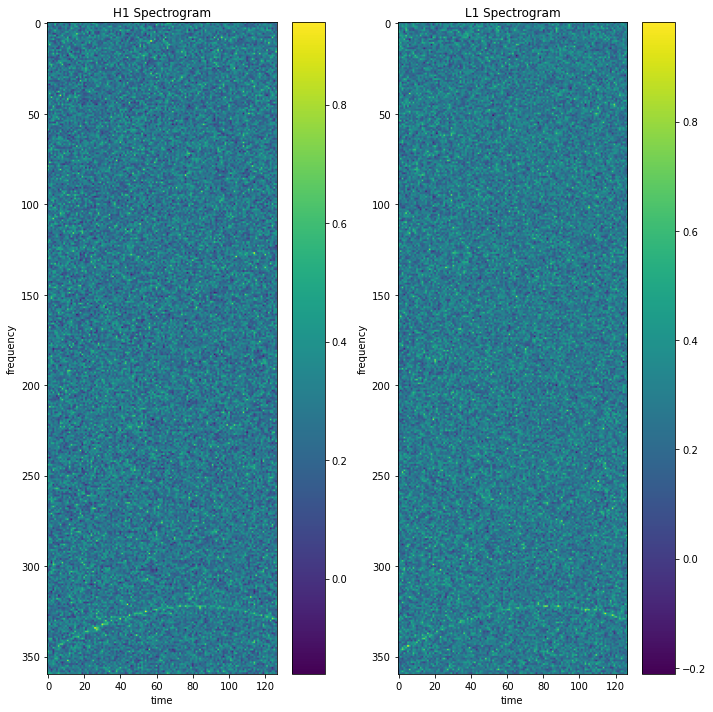

[[[0.3583571  0.1963993  0.33968183 ... 0.25345322 0.14655761 0.35869953]
  [0.30423573 0.41142014 0.23059675 ... 0.26792535 0.21072592 0.16123861]
  [0.08716857 0.25588572 0.27681237 ... 0.30698514 0.27475315 0.18198785]
  ...
  [0.29184785 0.27971637 0.02045513 ... 0.08584256 0.17254503 0.2783637 ]
  [0.3484798  0.39429677 0.14893036 ... 0.38599446 0.33419055 0.05640191]
  [0.52418995 0.48508364 0.46702778 ... 0.30004883 0.40403375 0.24884711]]

 [[0.16868936 0.25757992 0.16885151 ... 0.27548558 0.22578125 0.2562527 ]
  [0.5084962  0.26899248 0.44855195 ... 0.51829153 0.28873426 0.28892145]
  [0.26130638 0.2614266  0.4841212  ... 0.2229655  0.44358996 0.30843914]
  ...
  [0.14998883 0.2404245  0.09281849 ... 0.20639649 0.239898   0.20852593]
  [0.0551172  0.37632552 0.59807014 ... 0.36385092 0.16166992 0.42848036]
  [0.18328643 0.31358612 0.24057066 ... 0.21074219 0.38496095 0.3622857 ]]]

/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0040fc1b3.hdf5
im

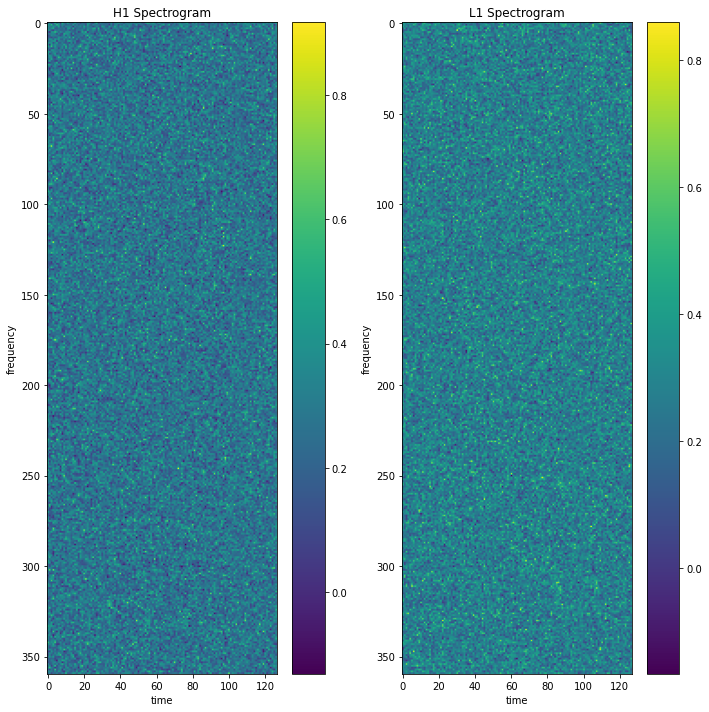

[[[0.08500937 0.4146659  0.05709169 ... 0.20517579 0.33250868 0.4731147 ]
  [0.49407852 0.3130898  0.58426726 ... 0.48894313 0.01322157 0.24724664]
  [0.33841926 0.35638678 0.28085247 ... 0.38398167 0.15991211 0.32184517]
  ...
  [0.19025174 0.07678053 0.28644866 ... 0.19425185 0.0555854  0.37438694]
  [0.3642071  0.34780142 0.30800933 ... 0.52267796 0.35499403 0.26210395]
  [0.2120123  0.31576398 0.09118873 ... 0.38663194 0.12800835 0.24759658]]

 [[0.4283104  0.3590037  0.2480356  ... 0.23745659 0.16591254 0.15218912]
  [0.32163498 0.37295362 0.24620764 ... 0.39626193 0.35062933 0.1701199 ]
  [0.49430296 0.2386462  0.3675004  ... 0.4529351  0.09527452 0.12983127]
  ...
  [0.2586828  0.32402313 0.27432942 ... 0.34874675 0.42089844 0.12143012]
  [0.18645109 0.31783327 0.42722258 ... 0.04735786 0.29283854 0.22651367]
  [0.15764949 0.24844912 0.31699288 ... 0.35180664 0.3746365  0.24096408]]]


In [20]:
print("=> train label dist")
print(train_df.target.value_counts())
print()

print("=> train+test SFTs w")
_df = pd.concat([train_df, test_df])
print("H1 SFTs w max(), min()", _df["H1 SFTs w"].max(), _df["H1 SFTs w"].min())
print("L1 SFTs w max(), min()", _df["L1 SFTs w"].max(), _df["L1 SFTs w"].min())
print()

#normalize_type = "default-norm|p-norm|ts-a"
#normalize_type = "default-norm|p-norm|ts-ma"
#normalize_type = "spec-sequence_a|ts-ma|p-norm"
#normalize_type = "spec-sequence_a|ts-ma|p-stand"
#normalize_type = "spec-sequence_a|ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-norm"
#normalize_type = "ts-ma|p-stand"
#normalize_type = "ts-ma|p-common-stand"
#normalize_type = "ts-ma|p-robustscaler"
#normalize_type = "same_ts_interval|p-stand"
#normalize_type = "same_ts_interval|p-common-stand"
#normalize_type = "largekernel|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma"
#normalize_type = "largekernel|p-robustscaler|ts-ma|clip"
#normalize_type = "largekernel"

#cfg_step = 32
#cfg_step = 64
#cfg_step = 128

#cfg_spec_max = 4096
#cfg_spec_max = 4224


# 画像可視化
print("=> normalize_type:", normalize_type)

_i = 10
_path = train_df.iloc[_i]["path"]
#_path = add_df_all.iloc[_i]["path"]
#if "/work" in os.getcwd():
#    _path = sorted(glob.glob(f"{ADD_DIR_TRAIN}/*.hdf5"))[-1]
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360,
                 )
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", train_df.iloc[_i]["target"])
show_1img_2ch(img)
print(img)

print()
_path = test_df.iloc[_i]["path"]
#_path = test_df.iloc[806]["path"]
#if "/kqi/output" in os.getcwd():
#    _path = "/kqi/output/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#else:
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/698567d90.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7921a1a90.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/308417080.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/7ee0a00f8.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/9f37c3fde.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/0bf7da48d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/b0990161d.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d1da4fc07.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/4ca95032a.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/5e2305d9d.hdf5"
#    _path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/a666b93a9.hdf5"
#    #_path = "/volume-ssd/kaggle_g2net2/g2net-detecting-continuous-gravitational-waves/test/d6828b59a.hdf5"
print(_path)
img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                  norm_type=normalize_type, 
                  ch=cfg_ch, 
                  freq=360)
print("img.max(), img.min():", img.max(), img.min())
print("img.shape:", img.shape)
print("y:", test_df.iloc[806]["target"])
show_1img_2ch(img)
print(img)

In [21]:
#%debug

In [22]:
#=====

# To npy

In [23]:
#!rm -r {NPY_DIR}/{normalize_type}

In [24]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def hdf5_to_npy(h_paths, out_dir):
    """
    前処理したhdf5データをnpyに保存する
    """
    if cfg_is_npy and (os.path.exists(out_dir) == False): 
        os.makedirs(out_dir, exist_ok=True)
        for _path in tqdm(h_paths):
            img = hdf5_to_img(_path, cfg_step, cfg_spec_max, 
                              norm_type=normalize_type, 
                              ch=cfg_ch, 
                              freq=360,
                             )
            np.save(os.path.join(out_dir, f'{Path(_path).stem}.npy'), np.array(img))
    else:
        print(f"INFO: Exist {out_dir}")


if cfg_is_npy:
    _npy_dir = f"{NPY_DIR}/{normalize_type}"
    _max_workers = multiprocessing.cpu_count()  # total CPU
    with ThreadPoolExecutor(max_workers=_max_workers, thread_name_prefix="thread") as executor:
        hdf5_to_npy(train_df["path"].to_numpy(), f"{_npy_dir}/train")
        if IS_MAKE_SUB or (PSEUDO_CSV != ""):
            hdf5_to_npy(test_df["path"].to_numpy(), f"{_npy_dir}/test")
        if ADD_DIRS_STR != "":
            for _add_dir in eval(ADD_DIRS_STR):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        if ADD_PSEUDO_DIRS != "":
            for _add_dir in eval(ADD_PSEUDO_DIRS):
                hdf5_to_npy(sorted(glob.glob(f"{_add_dir}/*.hdf5")), f"{_npy_dir}/{Path(_add_dir).stem}")
        
    # path書き換え
    train_df["path"] = f"{_npy_dir}/train/" + train_df["id"] + ".npy"
    print(train_df["path"].iloc[0])  # パス確認
    if IS_MAKE_SUB:
        test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
        print(test_df["path"].iloc[0])  # パス確認
    if ADD_DIRS_STR != "":
        add_df_all["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_df_all["path"].to_numpy()
        ]
        add_df_all.to_csv(f"{OUTPUT_DIR}/add_data.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_df_all["path"].iloc[0])  # パス確認
    if PSEUDO_CSV != "":
        pseudo_df["path"] = f"{_npy_dir}/test/" + pseudo_df["id"] + ".npy"
        pseudo_df.to_csv(f"{OUTPUT_DIR}/pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(pseudo_df["path"].iloc[0])  # パス確認
    if ADD_PSEUDO_DIRS != "":
        add_pseudo_df["path"] = [
            f"{_npy_dir}/{Path(p).parent.stem}/{Path(p).stem}.npy"
            for p in add_pseudo_df["path"].to_numpy()
        ]
        add_pseudo_df.to_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv", index=False)  # 学習直前でロードするためにcsvにしておく
        print(add_pseudo_df["path"].iloc[0])  # パス確認

INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/train
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/test
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex003_generating_noise_2_gap
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_1
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex005_generating_signal_gap_iso_1
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_noise_gap1400
INFO: Exist /volume-ssd/kaggle_g2net2/npys/largekernel|p-robustscaler|ts-ma|clip/ex006_generating_signal_gap800
INFO: Exist /volume-ssd/kaggle_g2net2/npys/la

In [25]:
#=====

# Libraries

In [26]:
import warnings
warnings.filterwarnings("ignore")  

import os
import gc
import cv2
import math
import copy
import time
import random
import shutil
import yaml
import glob
from pprint import pprint
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict
import traceback
import imagesize

# For data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
#import plotly.express as px
from PIL import Image
from matplotlib import pyplot as plt

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import torchaudio

# Utils
import pickle, joblib
from tqdm import tqdm
tqdm.pandas()

# Sklearn Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold

# For Image Models
import timm
print("timm:", timm.__version__)
from timm.data import ImageDataset
from timm.data.mixup import Mixup, one_hot
from timm.data.auto_augment import rand_augment_transform
from timm.loss.cross_entropy import SoftTargetCrossEntropy, LabelSmoothingCrossEntropy
from timm.scheduler import CosineLRScheduler  # warmupつきCosineAnnealingLR

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# tta
import ttach as tta

# DDP
# 何故か3090ではエラーになる
#from accelerate import Accelerator, DistributedType, DistributedDataParallelKwargs

## Synchronized-BatchNorm for DP
## https://blog.shikoan.com/sync-batch-norm-pytorch/
#import sys
#sys.path.append('./Synchronized-BatchNorm-PyTorch')
#from sync_batchnorm import convert_model, DataParallelWithCallback 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

TORCH_VERSION = '.'.join(torch.__version__.split('.')[:3])
print('torch:', TORCH_VERSION)

timm: 0.6.11
device: cuda
torch: 1.13.0+cu117


In [27]:
%reload_ext autoreload
%autoreload 2
from src.sam import SAM, ASAM
from src.cv_split import cv_split, cv_split_kfold

In [28]:
## timmのモデル一覧
## https://github.com/rwightman/pytorch-image-models/blob/master/results/README.md
##!pip install "git+https://github.com/rwightman/pytorch-image-models.git"
#import timm
#from pprint import pprint
#model_names = timm.list_models(pretrained=True)
#pprint(model_names)

In [29]:
#def test_timm_lr_Scheduler():
#    """
#    timmのlr_Schedulerの動作確認
#    https://timm.fast.ai/SGDR#cycle_limit=2
#    """
#    from timm import create_model 
#    from timm.optim import create_optimizer
#    from types import SimpleNamespace
#    from matplotlib import pyplot as plt
#
#    def get_lr_per_epoch(scheduler, num_epoch):
#        lr_per_epoch = []
#        for epoch in range(num_epoch):
#            lr_per_epoch.append(scheduler.get_epoch_values(epoch))
#        return lr_per_epoch
#
#    model = create_model('resnet34')
#
#    num_epoch = 50
#    
#    args = SimpleNamespace()
#    args.weight_decay = 0
#    args.lr = 1e-2
#    args.opt = 'adam' 
#    args.momentum = 0.9
#
#    optimizer = create_optimizer(args, model)
#
#    scheduler = CosineLRScheduler(optimizer, 
#                                  t_initial=num_epoch//3,  # 総エポック数
#                                  lr_min=args.lr*1e-2,  # 最小学習率
#                                  warmup_t=3,  # ウォームアップ完了時のエポック数
#                                  warmup_lr_init=args.lr*1e-2,  # ウォームアップの初期学習率
#                                  warmup_prefix=True,  # Warmupが完了したタイミングの学習率をオプティマイザーで設定した基本学習率にするかどうか
#                                  cycle_limit=1,  # lr restartの回数
#                                 )
#    lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)
#
#    plt.plot([i for i in range(num_epoch)], lr_per_epoch);
#    
#test_timm_lr_Scheduler()

# CFG

In [30]:
import os, yaml, shutil

class Config:
    def __init__(self):
        self.name=NAME
        self.train=True
        self.debug=DEBUG
        self.print_freq=1000
        self.is_save_per_steps=False
        self.target_col="target"
        self.num_classes=1
        self.loss = "nn.BCEWithLogitsLoss"
        
        self.model_cls=model_cls
        self.apex=cfg_apex
        self.load_model_path=load_model_path
        #self.load_model_path=f"{OUTPUT_DIR}/tmp_fold0_seed0_best_score.pth"
        #self.is_load_opt=True
        self.is_load_opt=False
        
        # ============== model params ==============
        self.model_name=MODEL_NAME
        self.size_h=size_h
        self.size_w=size_w
        self.batch_size=BATCH_SIZE
        self.gradient_accumulation_steps=gradient_accumulation_steps
        self.is_syncBN = is_syncBN
        self.pretrained = cfg_pretrained
        self.drop_rate = cfg_drop_rate
        self.drop_path_rate = cfg_drop_path_rate
        # ==========================================
        
        self.num_workers=8#16 if "/work" in os.getcwd() else 8
        self.epochs=epochs
        self.optimizer=cfg_optimizer
        self.lr=lr
        self.warmup_lr_init=self.lr*min_lr_ratio
        self.min_lr=self.lr*min_lr_ratio
        self.weight_decay=weight_decay
        self.scheduler=cfg_scheduler  # 'CosineLRScheduler'  # warmup
        self.warmup_t=warmup_t
        self.T_max=epochs
        self.max_grad_norm=1000
        
        self.cv_col=cfg_cv_col
        self.seeds=cfg_seeds
        self.n_fold=n_fold
        self.trn_fold=trn_fold
        
        self.is_wandb=is_wandb
        self.device_ids=device_ids
        
        # ============== data params ==============
        self.step=cfg_step
        self.spec_max=cfg_spec_max
        self.ch=cfg_ch
        self.freq=360
        self.norm_type=normalize_type
        # ==========================================
        
        # 自作mixup
        self.prob_mixup = cfg_prob_mixup  # 0.0なら発生確率=0
        self.mix_alpha = 1.0
        self.is_mix_or = True
        #self.mixup_off_epoch = self.epochs-5  # 最後の5epochはmixup/cutmixなしにする
        self.mixup_off_epoch = 0  # 常にmixup/cutmixなし
        
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        self.prob_sample_mixup = cfg_prob_sample_mixup
        
        # 追加データのtarget=0とオリジナルのtarget=0とのmixup確率
        self.prob_add_sample_nega_mixup = cfg_prob_add_sample_nega_mixup
        
        # データセットの移動平均のpowerとのmixupの確率
        self.prob_mean_mixup = cfg_prob_mean_mixup
        
        # ch追加するか
        self.is_add_ch = cfg_is_add_ch
        
        # スペクトログラムの開始点をランダムに変えるか
        self.prob_spec_start_random = cfg_prob_spec_start_random
        
        # test setのような縦線や横線のノイズ入れる確率
        self.prob_noise_band = cfg_prob_noise_band
        
        # test setのような外れ点ノイズ入れる確率
        self.prob_noise_spot = cfg_prob_noise_spot
        
        # test setのようなまばらな外れ縦線ノイズ入れる確率
        self.prob_noise_vline = cfg_prob_noise_vline
        
        # test setのようなまばらな外れ横バンドノイズ入れる確率
        self.prob_noise_hband = cfg_prob_noise_hband
        
        # target=0のデータのチャネル入れ替える確率
        self.prob_swap_ch_nega = cfg_prob_swap_ch_nega
        
        # target=0のデータhflipする確率
        self.prob_flip_nega = cfg_prob_flip_nega
        
        # target=0のデータ同士をシャッフルする確率
        self.prob_swap_nega = cfg_prob_swap_nega
        
        # target=0のデータをVshiftする確率
        self.prob_vshift_nega = cfg_prob_vshift_nega
        
        # データ関係なくVshiftする確率
        self.prob_vshift = cfg_prob_vshift
        
        # torchaudioで縦横cutout(マスク)する本数
        self.time_mask_num = cfg_time_mask_num  # 縦線
        self.freq_mask_num = cfg_freq_mask_num  # 横線
        self.time_mask_param = cfg_time_mask_param  # マスクの可能な最大長。[0, time_mask_param) 
        self.freq_mask_param = cfg_freq_mask_param  # マスクの可能な最大長。[0, freq_mask_param) 
        
        # zip_datasetをtrainにして学習するか
        self.is_train_zip_dataset = cfg_is_train_zip_dataset
        
        # 生成したデータは別の切り方でfold分けるときに使うKfoldのAPI名(StratifiedKFold, KFoldなど)。""なら別の切り方でfold分けない
        self.add_split_str = cfg_add_split_str
        
        # データをnpyに変換するか
        self.is_npy = cfg_is_npy
        
        # 学習に追加した生成データのディレクトリ名
        self.add_dirs_str = ADD_DIRS_STR
        
        # 学習に追加したtestの疑似ラベルに使うcsv、確信度の閾値、ハードラベルにするか
        self.pseudo_csv = PSEUDO_CSV
        self.pseudo_ths = [cfg_pseudo_max, cfg_pseudo_min]
        self.is_pseudo_hard = cfg_is_pseudo_hard
        
        # 学習に追加したtestの疑似ラベルをリアルデータ/シュミレーションデータだけにするか
        self.pseudo_type = cfg_pseudo_type
        
        # 追加の疑似ラベルのディレクトリ名
        self.add_pseudo_dirs = ADD_PSEUDO_DIRS
        

CFG = Config()
        
if CFG.debug:
    #CFG.seeds=[0,1,2]
    CFG.is_wandb=False
    #CFG.is_wandb=True
    #CFG.print_freq=10
    #CFG.epochs=5
    #CFG.warmup_t=1
    #CFG.mixup_off_epoch=3
    #CFG.epochs=1
    #CFG.mixup_off_epoch=1
    #CFG.epochs=10
    #CFG.trn_fold=[0]
    #CFG.trn_fold=[0,1,2,3,4]
    train_df = cv_split(train_df, 0, 10, cv_col="target")
    train_df = train_df[train_df["fold"] == 0].reset_index(drop=True)
    print("debug train_df.shape:", train_df.shape)
    test_df = test_df.iloc[:30]
    print("debug test_df.shape:", test_df.shape)
    # モデル削除
    !rm -f {OUTPUT_DIR}/*pth
    
with open(OUTPUT_DIR + "/cfg.yaml", "w") as wf:
    yaml.dump(CFG.__dict__, wf)
        
if len(CFG.device_ids) > 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(_) for _ in CFG.device_ids])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    CFG.batch_size = CFG.batch_size*len(CFG.device_ids)
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(CFG.device_ids[0])
    print("os.environ['CUDA_VISIBLE_DEVICES']:", os.environ["CUDA_VISIBLE_DEVICES"])
    # For descriptive error messages
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    
pprint(CFG.__dict__)

os.environ['CUDA_VISIBLE_DEVICES']: 0
{'T_max': 50,
 'add_dirs_str': '[EX003_NOISE2, EX005_SIGNAL, EX005_SIGNAL1, '
                 'EX005_SIGNAL_ISO, EX005_SIGNAL_ISO1, EX006_NOISE1400, '
                 'EX006_SIGNAL800, EX006_SIGNAL_ISO800]',
 'add_pseudo_dirs': '[EX007_NONSTAT_NOISE800]',
 'add_split_str': 'StratifiedKFold',
 'apex': True,
 'batch_size': 64,
 'ch': 2,
 'cv_col': 'target',
 'debug': False,
 'device_ids': [0],
 'drop_path_rate': 0.2,
 'drop_rate': 0.4,
 'epochs': 50,
 'freq': 360,
 'freq_mask_num': 2,
 'freq_mask_param': 10,
 'gradient_accumulation_steps': 1,
 'is_add_ch': False,
 'is_load_opt': False,
 'is_mix_or': True,
 'is_npy': True,
 'is_pseudo_hard': False,
 'is_save_per_steps': False,
 'is_syncBN': False,
 'is_train_zip_dataset': False,
 'is_wandb': True,
 'load_model_path': 'none',
 'loss': 'nn.BCEWithLogitsLoss',
 'lr': 0.0004,
 'max_grad_norm': 1000,
 'min_lr': 4.000000000000001e-06,
 'mix_alpha': 1.0,
 'mixup_off_epoch': 0,
 'model_cls': 'CustomModel',


# Utils

In [31]:
def init_logger(log_file=OUTPUT_DIR + '/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print('> SEEDING DONE')

# Wandb

In [32]:
if CFG.is_wandb:
    import wandb
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        wandb.login(key="")  # 自分の api key でログイン  # https://wandb.ai/settings
        wandb.init(project="", entity='', name=NAME)
        wandb.config.update(CFG.__dict__)  # ハイパラ登録

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anonamename. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Dataset

In [33]:
class TrainDataset(Dataset):
    def __init__(self, train, transforms=None, 
                 is_npy=True,
                 is_add_ch=False,
                 prob_spec_start_random=0.0,
                 prob_sample_mixup=0.0,
                 prob_add_sample_nega_mixup=0.0,
                 prob_mean_mixup=0.0, 
                 prob_noise_band=0.0,
                 prob_noise_spot=0.0,
                 prob_noise_vline=0.0,
                 prob_noise_hband=0.0,
                 prob_swap_ch_nega=0.0,
                 prob_flip_nega=0.0,
                 prob_swap_nega=0.0,
                 prob_vshift_nega=0.0,
                 prob_vshift=0.0,
                 time_mask_num=0,
                 freq_mask_num=0,
                 time_mask_param=CFG.time_mask_param,
                 freq_mask_param=CFG.freq_mask_param,
                ):
        self.train = train
        self.file_names = train['path'].values
        self.labels = train['target'].values
        self.transforms = transforms
        
        self.orig_flags = train['freq min'].values  # np.nanは追加データ
        
        self.is_npy = is_npy  # npyをロードするか
        
        self.prob_spec_start_random = prob_spec_start_random  # スペクトログラムの開始点をランダムに変える確率
        
        self.is_add_ch = is_add_ch  # ch増やすか
        
        #self.train0 = train[train["target"] == 0]   # label=0のdf
        if PSEUDO_CSV != "":
            #self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
            self.train0 = pseudo_df[pseudo_df["target"] < 0.5]   # label=0のdf pseudoのデータだけでmix
            if ADD_PSEUDO_DIRS != "":
                self.train0 = pd.concat([self.train0, add_pseudo_df], ignore_index=True)
        else:
            self.train0 = train[train["target"] < 0.5]   # label=0のdf pseudoのデータもmix
        
        self.train0_orig = train[train["target"] < 0.5].dropna(subset=['freq min']).reset_index(drop=True)  # label=0かつオリジナルデータのdf
        
        self.prob_sample_mixup = prob_sample_mixup  # label=0ならlabel=0or1とmix, label=1ならlabel=0とmixする確率
        
        self.prob_add_sample_nega_mixup = prob_add_sample_nega_mixup  # 追加データのtarget=0とオリジナルのtarget=0とをmixup確率
        
        self.prob_mean_mixup = prob_mean_mixup  # データセットの移動平均のpowerとのmixup
        
        self.prob_noise_band = prob_noise_band  # test setのような縦線や横線のノイズ入れる確率
        
        self.prob_noise_spot = prob_noise_spot  # test setのような外れ点ノイズ入れる確率
        
        self.prob_noise_vline = prob_noise_vline  # test setのようなまばらな外れ縦線ノイズ入れる確率
        
        self.prob_noise_hband = prob_noise_hband  # test setのようなまばらな外れ横バンドノイズ入れる確率
        
        self.prob_swap_ch_nega = prob_swap_ch_nega # negaサンプルch入れ替える確率
        
        self.prob_flip_nega = prob_flip_nega  # negaサンプルhflipする確率
        
        self.prob_swap_nega = prob_swap_nega  # negaサンプル別の使う確率
        
        self.prob_vshift_nega = prob_vshift_nega  # negaサンプルのみ縦方向に平行移動(VShift)する確率
        
        self.prob_vshift = prob_vshift  # 縦方向に平行移動(VShift)する確率
        
        self.time_mask_num = time_mask_num # number of time masking
        self.freq_mask_num = freq_mask_num # number of frequency masking
        self.transforms_time_mask = nn.Sequential(
            # time_mask_param はマスクする幅の最大長。[0, time_mask_param) 
            torchaudio.transforms.TimeMasking(time_mask_param=time_mask_param),
        )
        self.transforms_freq_mask = nn.Sequential(
            # freq_mask_param はマスクする幅の最大長。[0, freq_mask_param) 
            torchaudio.transforms.FrequencyMasking(freq_mask_param=freq_mask_param),
        )    
        
    def __len__(self):
        return len(self.train)
    
    def load_img(self, path):
        if self.is_npy:
            img = np.load(path)
        else:
            img = hdf5_to_img(path, CFG.step, CFG.spec_max, 
                              norm_type=CFG.norm_type, 
                              ch=CFG.ch, 
                              freq=CFG.freq)  # (C,H,W)
        img = img.transpose(1, 2, 0)  # (H,W,C)
    
        ### 振幅の開始点をランダムに変更
        if (np.random.rand() > 1 - self.prob_spec_start_random) and (img.shape[1] > CFG.size_w):
            spec_start = img.shape[1] - CFG.size_w
            spec_start = int(np.random.uniform(low=0, high=spec_start))
            img = img[:, spec_start:spec_start+CFG.size_w, :]  # shape=(360, size_w, 2)
            #print("spec_start:", spec_start)
        
        ### 横幅のサイズはsize_wまでにする
        if CFG.size_w > 0:
            img = img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
        
        #print("img.shape:", img.shape)
        return img
    
    def __getitem__(self, index):
        label = self.labels[index]
        label = torch.tensor(label, dtype=torch.float)
        img = self.load_img(self.file_names[index])
        
        orig_flag = self.orig_flags[index]
        
        # ===============================================
        # test setのような縦線や横線のノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の横線
            w_n_line = np.random.randint(1, 3)  # 横線何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 5)  # 横線の太さ
                _ratio = np.random.uniform(0.05, 1.1)
                img[_s:_s+_b, :, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # H1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
            #print(f"{index} H1 v_noise_band {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_band:
            # L1の縦線
            v_n_line = np.random.randint(1, 6)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 15)  # 縦線の太さ
                _ratio = np.random.uniform(0.05, 0.4)
                img[:, _s:_s+_b, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
            #print(f"{index} L1 v_noise_band {v_n_line}")
            
        # ===============================================
        # test setのような外れ点ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_spot:
            # H1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 0] += img[:,:,0].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 0] *= _ratio  # 係数掛ける
            #print(f"{index} H1 noise_spot {n_area}")
        if np.random.rand() > 1 - self.prob_noise_spot:
            # L1の外れ点
            n_area = np.random.randint(1, 3)  # 外れ領域何個入れるか
            for _ in range(n_area):
                _y = np.random.randint(0, img.shape[0])  # y軸の開始位置
                _x = np.random.randint(0, img.shape[1])  # x軸の開始位置
                _xb = np.random.randint(1, 5)  # 外れ領域の大きさ
                _yb = np.random.randint(1, 20)  # 外れ領域の大きさ
                _ratio = np.random.uniform(1.5, 2)
                img[_y:_y+_yb, _x:_x+_xb, 1] += img[:,:,1].max()*_ratio  # 係数掛ける
                #img[_y:_y+_yb, _x:_x+_xb, 1] *= _ratio  # 係数掛ける
            #print(f"{index} L1 noise_spot {n_area}")
            
        # ===============================================
        # test setのようなまばらな外れ縦線ノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_vline:
            # H1の外れ縦線
            v_n_line = np.random.randint(1,8)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 0] += _gs_n
            #print(f"{index} H1 noise_vline {v_n_line}")
        if np.random.rand() > 1 - self.prob_noise_vline:
            # L1の外れ縦線
            v_n_line = np.random.randint(1, 5)  # 縦線何本入れるか
            for _ in range(v_n_line):
                _s = np.random.randint(0, img.shape[1])  # 縦線の開始位置
                _b = np.random.randint(1, 2)  # 縦線の太さ
                _ratio = np.random.uniform(3, 5)
                _mu = img[:,:,1].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[:, _s:_s+_b, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 上半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[0]//2)
                    _gs_n[:_mask,:] = 0
                # 下半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[0]//2, _gs_n.shape[0])
                    _gs_n[_mask:,:] = 0
                img[:, _s:_s+_b, 1] += _gs_n
            #print(f"{index} L1 noise_vline {v_n_line}")
            
        # ===============================================
        # test setのようなまばらな外れ横バンドノイズ入れる
        # ===============================================
        if np.random.rand() > 1 - self.prob_noise_hband:
            # H1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 0].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 0] += _gs_n
            #print(f"{index} H1 h_noise_band {w_n_line}")
        if np.random.rand() > 1 - self.prob_noise_hband:
            # L1の外れ横バンド
            w_n_line = np.random.randint(1, 3)  # バンド何本入れるか
            for _ in range(w_n_line):
                _s = np.random.randint(0, img.shape[0])  # 横線の開始位置
                _b = np.random.randint(1, 10)  # 横線の太さ
                _ratio = np.random.uniform(2, 5)
                _mu = img[:,:,0].max()/2
                _gs_n = np.random.normal(loc=_mu, scale=_mu/_ratio, size=img[_s:_s+_b, :, 1].shape) # ガウシアンノイズ
                # 一部マスク
                if np.random.rand() > 0.5:
                    _gs_n *= np.random.randint(0,2,_gs_n.shape) # 0/1のどっちか発生して掛ける
                # 右半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(1, _gs_n.shape[1]//2)
                    _gs_n[:,:_mask] = 0
                # 左半分マスク
                if np.random.rand() > 0.5:
                    _mask = np.random.randint(_gs_n.shape[1]//2, _gs_n.shape[1])
                    _gs_n[:,_mask:] = 0
                # ゼブラマスク
                if np.random.rand() > 0.5:
                    _gs_n[::2,:] = 0  # 1飛ばし。例: array([0, 2, 4, 6, 8])
                if np.random.rand() > 0.5:
                    _gs_n[::3,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::5,:] = 0
                if np.random.rand() > 0.5:
                    _gs_n[::7,:] = 0
                img[_s:_s+_b, :, 1] += _gs_n
            #print(f"{index} L1 h_noise_band {w_n_line}")
            
        # ソフトラベルの対策。negativeとみなすラベルの値
        nega_th = 0.5
        
        # ===============================================
        # VShift
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        if (np.random.rand() > 1 - self.prob_vshift):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift")
        ### Negative VShift
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_vshift_nega):
            img = np.roll(img, np.random.randint(low=0, high=img.shape[0]), axis=0)
            #print("vshift_nega")
        
        # ===============================================
        # Negative Swap CH
        # ===============================================
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_swap_ch_nega):
            i0 = img[:,:,0].copy()
            img[:,:,0] = img[:,:,1]
            img[:,:,1] = i0
            #print("swap_ch_nega")
        
        # ===============================================
        # 前回コンペ8位のaug
        # https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/discussion/275335
        # ===============================================
        # LIGO Swap は A.ChannelShuffle で実行
        
        # Negative Flip
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[:, ::-1, :].copy()  # hflip
            #print("hflip_nega")
        if (label < nega_th) and (np.random.rand() > 1 - self.prob_flip_nega):
            img = img[::-1, :, :].copy()  # vflip
            #print("vflip_nega")
        
        # Swap with Other Negative
        if (label < nega_th) and (self.prob_swap_nega > 0.0):
            sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,0] = sample_img[:,:,0]
                #print("h1 swap_nega")
            if np.random.uniform() > 1 - self.prob_swap_nega:
                img[:,:,1] = sample_img[:,:,1]
                #print("l1 swap_nega")
            
        # ===============================================
        # Sample Mixup
        # ===============================================
        # label=0ならlabel=0or1とmix, label=1ならlabel=0とmix
        if np.random.rand() > 1 - self.prob_sample_mixup:
            if label < nega_th:
                sample = self.train.sample()
            else:
                sample = self.train0.sample()
            sample_img = self.load_img(sample.iloc[0]['path'])
            img = (img + sample_img) / 2.0
            # mix_sample_lam の割合で混ぜる
            #mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            #img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
            
            if sample.iloc[0]['target'] >= nega_th:
                label = torch.tensor(sample.iloc[0]['target']).float()
            #print("sample_mixup", sample.iloc[0]['target'])
            
        # ===============================================
        # Add Data Nega Sample Mixup
        # ===============================================
        # target=0について add_data と orig_data をmixup
        if np.random.rand() > 1 - self.prob_add_sample_nega_mixup:
            if np.isnan(orig_flag):
                # orig_flagがnegaならadd_data
                if label < nega_th:
                    sample = self.train0_orig.sample()
                sample_img = self.load_img(sample.iloc[0]['path'])
                # mix_sample_lam の割合で混ぜる
                mix_sample_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
                img = mix_sample_lam*img + (1-mix_sample_lam)*sample_img
                #print("add_sample_nega_mixup")
        
        # ===============================================
        # Mean Mixup
        # ===============================================
        # データセット全体の移動平均とmix
        if np.random.rand() > 1 - self.prob_mean_mixup:

            # データセット全体の移動平均の振幅をパワーに変換
            abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step), dtype=np.float32)
            if ("ts-ma" in CFG.norm_type) and (cfg_step % 128 == 0):
                # step%128=0の移動平均は1要素減る
                abs_mean_img = np.empty((CFG.ch, CFG.freq, CFG.step-1), dtype=np.float32)
            abs_mean_img[0] = amp2power(a_abs_mean_h1, "H1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img[1] = amp2power(a_abs_mean_l1, "L1", CFG.step, CFG.spec_max, CFG.norm_type, CFG.freq)
            abs_mean_img = abs_mean_img.transpose(1, 2, 0)  # (H,W,C)
            # 横幅のサイズはsize_wまでにする
            if CFG.size_w > 0:
                abs_mean_img = abs_mean_img[:, :CFG.size_w, :]  # shape=(360, size_w, 2)
            
            # mean_lam の割合で混ぜる
            mean_lam = np.clip(np.random.beta(1.0, 1.0),0.1,0.9)
            img = mean_lam*img + (1-mean_lam)*abs_mean_img
        
            # 移動平均と混ぜた分のラベルもmix
            if label < nega_th:
                label += 0.1*(1-mean_lam)
            #print("mean_mixup")
            
        # ===============================================
        # ch増やす
        # ===============================================
        if self.is_add_ch:
            img = np.stack([img[:,:,0], img[:,:,1],
                            img[:,:,0] + img[:,:,1], 
                            img[:,:,0] - img[:,:,1]])  # (C,H,W)
            img = img.transpose(1, 2, 0)  # (H,W,C)
              
        if self.transforms:
            img = self.transforms(image=img)["image"]  # (C,H,W)

        # ===============================================
        # Torchaudio Masking
        # ===============================================
        # https://www.kaggle.com/code/myso1987/g2net-basic-audio-data-augmentation
        # imgはtorch型の(C,H,W)形式じゃないとだめ
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.time_mask_num): # time masking
                img = self.transforms_time_mask(img)
        if np.random.rand() > 1 - 0.5:
            for _ in range(self.freq_mask_num): # frequency masking
                img = self.transforms_freq_mask(img)
            
        return img, label

# Transform

In [34]:
def get_transforms(*, data):
    if data == 'train':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            #A.ChannelShuffle(always_apply=False, p=0.5),
            #A.GridDropout(ratio=0.5, holes_number_x=4, holes_number_y=8, random_offset=True, p=0.5),
            #A.VerticalFlip(p=0.5),
            #A.HorizontalFlip(p=0.5),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0, scale_limit=(0, 0.2), rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0),
            #A.ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_WRAP),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return A.Compose([
            #A.Resize(CFG.size_h, CFG.size_w),
            ToTensorV2(),
        ])
    #elif data == 'tta1':
    #    return A.Compose([
    #        A.Resize(CFG.size_h, CFG.size_w),
    #        A.ChannelShuffle(always_apply=True, p=1.0),
    #        ToTensorV2(),
    #    ])

In [35]:
def mixup(x, y, alpha):
    """
    Usage:
        x, y = batch["x"], batch["y"]
        x, y_mixs = mixup(x, y.long(), 1.0)
        y_hat = model(x.float())
        loss = criterion(y_hat, y_mixs[0], mix_decision) * y_mixs[2] + criterion(y_hat, y_mixs[1], mix_decision) * (1.0 - y_mixs[2])
    """
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]

    lam = np.clip(np.random.beta(alpha, alpha),0.3,0.7)
    x = lam*x + (1-lam)*shuffled_x
    ys = (y, shuffled_y, lam)

    return x, ys

# Dataloader check

torch.Size([15, 2, 360, 127]) torch.Size([15])


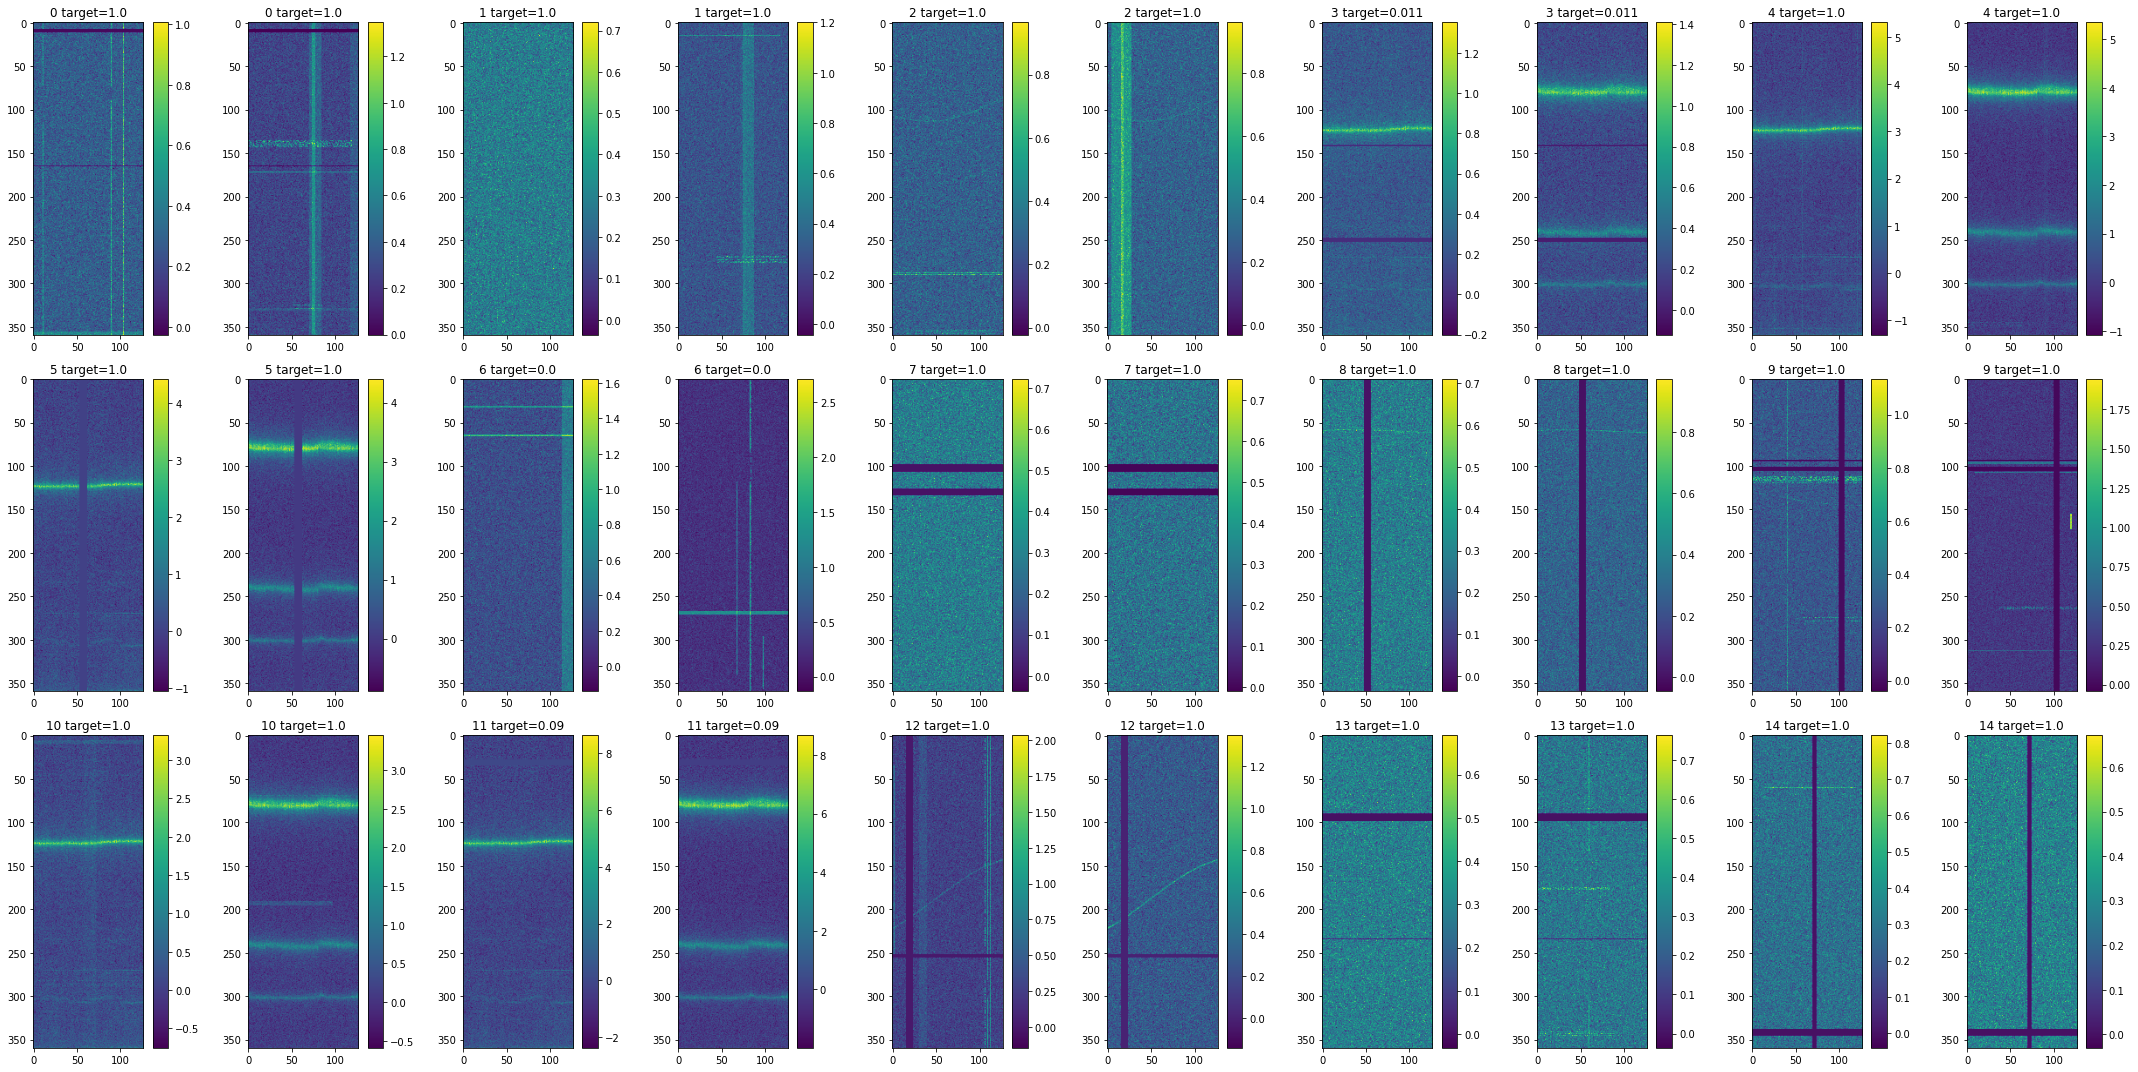

In [36]:
#%%time
# timeでファイルioに時間かかるか確認
if CFG.is_train_zip_dataset:
    train_dataset = ZipDataset(
        path=f"{zip_path}/archive", mod=zip_mod, transforms=get_transforms(data="train")
    )
else:
    train_dataset = TrainDataset(
        train_df,
        #pd.concat([train_df, add_df_all]),
        transforms=get_transforms(data="train"),
        is_npy=CFG.is_npy,
        is_add_ch=CFG.is_add_ch,
        prob_spec_start_random=CFG.prob_spec_start_random,
        prob_sample_mixup=CFG.prob_sample_mixup,
        prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
        prob_mean_mixup=CFG.prob_mean_mixup,
        prob_noise_band=CFG.prob_noise_band,
        prob_noise_spot=CFG.prob_noise_spot,
        prob_noise_vline=CFG.prob_noise_vline,
        prob_noise_hband=CFG.prob_noise_hband,
        prob_swap_ch_nega=CFG.prob_swap_ch_nega,
        prob_flip_nega=CFG.prob_flip_nega,
        prob_swap_nega=CFG.prob_swap_nega,
        prob_vshift_nega=CFG.prob_vshift_nega,
        prob_vshift=CFG.prob_vshift,
        time_mask_num=CFG.time_mask_num,
        freq_mask_num=CFG.freq_mask_num,
    )
    #train_dataset = TrainDataset(
    #    #train_df,
    #    pd.concat([train_df, add_df_all]),
    #    transforms=get_transforms(data="train"),
    #    is_npy=CFG.is_npy,
    #    #is_add_ch=True,
    #    #prob_spec_start_random=1.0,
    #    prob_add_sample_nega_mixup=1.0,
    #    prob_sample_mixup=1.0,
    #    prob_mean_mixup=1.0,
    #    prob_noise_band=1.0,
    #    prob_noise_spot=1.0,
    #    prob_noise_vline=1.0,
    #    prob_noise_hband=1.0,
    #    #prob_swap_ch_nega=1.0,
    #    #prob_flip_nega=1.0,
    #    #prob_swap_nega=1.0,
    #    #prob_vshift_nega=1.0,
    #    #prob_vshift=1.0,
    #    #time_mask_num=5,
    #    #freq_mask_num=5,
    #)
train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=0, pin_memory=True, drop_last=True,
    #collate_fn=mixup_collate_fn,
)
for step, (images, labels) in enumerate(train_loader):
    print(images.shape, labels.shape)
    
    if normalize_type == "largekernel":
        plt.figure(figsize=(30,25))
    else:
        plt.figure(figsize=(30,15))
    i = 1
    for idx, (im, la) in enumerate(zip(images, labels)):
        im = im.transpose(0, 1).transpose(1, 2)  # (H,W,C)
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,0])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}", fontsize=12)
        i += 1
        
        if normalize_type == "largekernel":
            plt.subplot(5*3, 2, i)
        else:
            plt.subplot(3, 5*2, i)
        plt.imshow(im[:,:,1])
        plt.colorbar()
        #plt.colorbar(orientation='horizontal')
        plt.title(f"{idx} target={round(float(la.numpy()), 3)}", fontsize=12)
        i += 1
        
        if i > 30:
            break
            
    plt.tight_layout()
    plt.show()
    break

In [37]:
#=====

# Model

In [38]:
class CustomModel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch)        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModel(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [39]:
# https://www.kaggle.com/code/hirune924/2ndplace-solution/notebook を参考にdropout入れて過学習避ける
class CustomModelDrop(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                     num_classes=CFG.num_classes, 
                                     in_chans=CFG.ch, 
                                     drop_rate=CFG.drop_rate,  # headのドロップアウト率 (デフォルト: 0)
                                     drop_path_rate=CFG.drop_path_rate  # 中間層のドロップアウト率 (デフォルト: 0)
                                    )        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelDrop(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [40]:
class CustomModelMultiInput(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.net1 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2) 
        self.net2 = timm.create_model(CFG.model_name, pretrained=pretrained, 
                                      num_classes=0, 
                                      in_chans=CFG.ch//2)
        self.head = nn.Sequential(
            nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net1.num_features + self.net2.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        
        x1 = x[:, :CFG.ch//2, :, :]
        x2 = x[:, CFG.ch//2:, :, :]
        #print(x1.shape, x2.shape)
        
        feat1 = self.net1(x1)
        feat2 = self.net2(x2)
        y = self.head( torch.cat((feat1, feat2), 1) )
        #print(feat1.shape, feat2.shape, y.shape)
        
        return y[:,0]

#print(CFG.model_name)
#m = CustomModelMultiInput(pretrained=CFG.pretrained).cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [41]:
#=====

In [42]:
class CustomModelLargeKernel(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            pth = "/volume/kaggle/g2net2/kaggle_dl/g2net-detecting-continuous-gravitational-waves-v0/model_best.pth"
        else:
            pth = ""
        self.net = largekernel.get_model(
            model_name="tf_efficientnetv2_b0",
            path=pth,
            conv_in_chans=32
        )
        self.net.classifier = nn.Sequential(
            #nn.Dropout(p=0.3),
            #nn.BatchNorm1d(self.net1.num_features + self.net2.num_features), 
            nn.Linear(self.net.num_features, CFG.num_classes)
        )
        
    def forward(self, x, labels=None):
        return self.net(x)[:,0]

#print(CFG.model_name)
#m = CustomModelLargeKernel().cuda() 
##m = convert_model(m).cuda() # Batch NormをSync Batch Normに変換
##m = DataParallelWithCallback(m, device_ids=CFG.device_ids) # Data Parallel
#x = torch.rand(CFG.batch_size, 2, CFG.size_h, CFG.size_w)
#o = m(x.cuda())
#print(o, o.shape)
##m

In [43]:
#=====

In [44]:
# https://github.com/sinpcw/kaggle-whale2/blob/master/models.py
def loadpth(pth: str, map_location=None) -> OrderedDict:
    """
    パラメータロードのヘルパー関数.
    DataParallel化したモデルは module.xxxx という形式で保存されるため読込み時にmodule.から始まる場合はそれを取除く.
    """
    ostate = torch.load(pth, map_location=map_location)['model']
    nstate = OrderedDict()
    for k, v in ostate.items():
        if k.startswith('module.'):
            nstate[k[len('module.'):]] = v
        else:
            nstate[k] = v
    return nstate

# Metric

In [45]:
def get_score(labels: np.ndarray, predictions: np.ndarray):
    # predictions が nan になったときの対策
    try:
        return roc_auc_score(labels, predictions)
    except:
        return 0.0

# Helper

In [46]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [47]:
def forward_step(step, losses, batch_size, model, criterion, images, labels, prob_mixup, optimizer, scaler, optimizer_step):
    """
    SAMは2回forward必要だからforwardの処理（loss計算+backward）切り出す
    """
    # SAM 1st/2nd Path
    optimizer.step = optimizer_step
    
    # ===========================================
    # model forward for mixup
    # ===========================================
    if np.random.rand() > 1 - prob_mixup:
        x, y_mixs = mixup(images, labels.long(), CFG.mix_alpha)  # y_mixs=(target, shuffled_target, lambda)
        if CFG.apex:
            with autocast():
                outputs = model(x.float())
                if CFG.is_mix_or:
                    y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                    loss = criterion(outputs, y_mix_or.float())
                else:
                    loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
        else:
            outputs = model(x.float())
            if CFG.is_mix_or:
                y_mix_or = y_mixs[0] + y_mixs[1] - (y_mixs[0] * y_mixs[1])  # 元ラベルと混ぜるラベルどっちかが1なら1にする  https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266397
                loss = criterion(outputs, y_mix_or.float())
            else:
                loss = criterion(outputs, y_mixs[0]) * y_mixs[2] + criterion(outputs, y_mixs[1]) * (1.0 - y_mixs[2])
    else:
        if CFG.apex:
            with autocast():
                outputs = model(images, labels)  # 予測値の算出
                loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
        else:
            outputs = model(images, labels)  # 予測値の算出
            loss = criterion(outputs, labels)  # 目標値と予測値から目的関数の値を算出
    
    # ===========================================
    # record loss
    # ===========================================
    losses.update(loss.item(), batch_size)  # loggerにloss保存
    if CFG.gradient_accumulation_steps > 1:
        loss = loss / CFG.gradient_accumulation_steps  # normalize loss to account for batch accumulation
    if CFG.apex:
        scaler.scale(loss).backward()  # 各パラメータの勾配を算出
    else:
        loss.backward()  # 誤差逆伝播して各パラメータの勾配を算出
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)  # 勾配クリッピング
    
    # ===========================================
    # optimizer step
    # ===========================================
    if (step + 1) % CFG.gradient_accumulation_steps == 0:
        if CFG.apex:
            scaler.step(optimizer)  # 勾配の情報を用いたパラメータの更新
            scaler.update()
        else:
            optimizer.step()  # 勾配の情報を用いたパラメータの更新
        optimizer.zero_grad()  # 勾配情報の初期化
        
    return optimizer, scaler, losses, grad_norm

In [48]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, 
             prob_mixup=False, mixup_fn=None):
    model.train()
    if CFG.apex:
        scaler = GradScaler()
    else:
        scaler = None
    losses = AverageMeter()
    
    start = end = time.time()
    
    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        ## ===========================================
        ## timm mixup/cutmix
        ## ===========================================
        #if mixup_fn is not None:
        #    images, labels = mixup_fn(images, labels)
        #else:
        #    labels = one_hot(labels, CFG.num_classes, device=device)
        
        if isinstance(optimizer, SAM) or isinstance(optimizer, ASAM):
            optimizer, scaler, _, _ = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                   prob_mixup, optimizer, scaler, 
                                                   optimizer.first_step)
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.second_step)
        else:
            optimizer, scaler, losses, grad_norm = forward_step(step, losses, batch_size, model, criterion, images, labels, 
                                                                prob_mixup, optimizer, scaler, 
                                                                optimizer.step)
            
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.4e}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=optimizer.param_groups[0]["lr"]))
        
        if CFG.is_save_per_steps:
            torch.save(
                {
                    "model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": scheduler.state_dict(),
                },
                OUTPUT_DIR + "/per_steps.pth",
            )

    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [49]:
@torch.inference_mode()  # pytorch >= 1.9
def valid_fn(valid_loader, model, criterion, device):
    model.eval()
    losses = AverageMeter()
    preds = []
    
    start = end = time.time()
    
    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        #print(images.max())
        
        # ===========================================
        # compute loss
        # ===========================================
        with torch.no_grad():
            outputs = model(images, labels)  # logit
        loss = criterion(outputs, labels)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        
        ## ===========================================
        ## record topk index
        ## ===========================================
        #_, tk = torch.topk(outputs, 5, dim=1)
        #topk_indexs = tk.to('cpu').detach().numpy()
        #preds.append(topk_indexs[:,0])  # top1
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
        
        end = time.time()
        
        # ===========================================
        # logging
        # ===========================================
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
            
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, predictions

# Train loop

In [50]:
def train_loop(folds, fold, seed):
    
    LOGGER.info(f"========== fold: {fold}, seed: {seed} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
    
    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_col].values
    
    if CFG.is_train_zip_dataset:
        train_dataset = ZipDataset(path=f'{zip_path}/archive', mod=zip_mod, transforms=get_transforms(data='train'))
        valid_dataset = TrainDataset(valid_folds, is_npy=False, transforms=get_transforms(data='valid'))
    else:
        
        train_dataset = TrainDataset(train_folds, 
                                     transforms=get_transforms(data='train'), 
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                     prob_spec_start_random=CFG.prob_spec_start_random,
                                     prob_sample_mixup=CFG.prob_sample_mixup,
                                     prob_add_sample_nega_mixup=CFG.prob_add_sample_nega_mixup,
                                     prob_mean_mixup=CFG.prob_mean_mixup,
                                     prob_noise_band=CFG.prob_noise_band,
                                     prob_noise_spot=CFG.prob_noise_spot,
                                     prob_noise_vline=CFG.prob_noise_vline,
                                     prob_noise_hband=CFG.prob_noise_hband,
                                     prob_swap_ch_nega=CFG.prob_swap_ch_nega,
                                     prob_flip_nega=CFG.prob_flip_nega,
                                     prob_swap_nega=CFG.prob_swap_nega,
                                     prob_vshift_nega=CFG.prob_vshift_nega,
                                     prob_vshift=CFG.prob_vshift,
                                     time_mask_num=CFG.time_mask_num,
                                     freq_mask_num=CFG.freq_mask_num,
                                    )
        valid_dataset = TrainDataset(valid_folds, 
                                     transforms=get_transforms(data='valid'),
                                     is_npy=CFG.is_npy,
                                     is_add_ch=CFG.is_add_ch,
                                    )
    
    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineLRScheduler':
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
        elif CFG.scheduler=='CosineLRScheduler_cycle_limit3':
            _cycle_limit = 3
            # https://timm.fast.ai/SGDR#cycle_limit=2
            scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs//_cycle_limit, lr_min=CFG.min_lr, 
                                          warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True,
                                          cycle_limit=_cycle_limit,
                                         )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = eval(CFG.model_cls)(pretrained=CFG.pretrained)
    
    if os.path.exists(CFG.load_model_path):
        LOGGER.info("=> loading checkpoint '{}'".format(CFG.load_model_path))
        states = torch.load(CFG.load_model_path, map_location=torch.device("cpu"))
        if len(CFG.device_ids) > 1:
            model.load_state_dict( loadpth(CFG.load_model_path, map_location=torch.device("cpu")) )
        else:
            model.load_state_dict(states["model"])
    
    if len(CFG.device_ids) > 1:
        if CFG.is_syncBN:
            # https://blog.shikoan.com/sync-batch-norm-pytorch/
            model = convert_model(model).to(device) # Batch NormをSync Batch Normに変換
            model = DataParallelWithCallback(model, device_ids=CFG.device_ids) # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids} use SyncBN")
        else:
            model.to(device)
            model = nn.DataParallel(model, device_ids=CFG.device_ids)  # Data Parallel
            LOGGER.info(f"=> train Data Parallel {CFG.device_ids}")
        # https://aru47.hatenablog.com/entry/2020/11/06/225052
        cudnn.benchmark = True
    else:
        model.to(device)

    if CFG.optimizer == "adam":
        optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == "adamw":
        optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay)
    elif CFG.optimizer == 'nesterov':
        optimizer = optim.SGD(model.parameters(), lr=CFG.lr, momentum=0.9, weight_decay=CFG.weight_decay, nesterov=True)
    elif CFG.optimizer == 'sam':
        optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=CFG.lr, weight_decay=CFG.weight_decay, rho=0.05)
        
    scheduler = get_scheduler(optimizer)
    
    if os.path.exists(CFG.load_model_path):
        if CFG.is_load_opt:
            LOGGER.info("=> loading optimizer and scheduler")
            optimizer.load_state_dict(states["optimizer"])
            scheduler.load_state_dict(states["scheduler"])

    if CFG.is_wandb:
        # wandbでpytorchのモデル監視
        wandb.watch(model)
            
    # ====================================================
    # loop
    # ====================================================
    train_criterion = eval(CFG.loss)().to(device)
    valid_criterion = eval(CFG.loss)().to(device)

    best_score = -np.inf
    best_loss = np.inf
    
    #mixup_fn = Mixup(**CFG.mixup_args)
    mixup_fn = None
    prob_mixup = CFG.prob_mixup
    
    for epoch in range(CFG.epochs):
        
        # mixup_off_epoch以上はmixup/cutmixなしにする
        if epoch >= CFG.mixup_off_epoch:
            mixup_fn = None
            prob_mixup = 0.0
            #LOGGER.info(f'Epoch {epoch+1} - mixup_fn=None')
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, train_criterion, optimizer, epoch, scheduler, device, 
                            prob_mixup=prob_mixup)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, valid_criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
        elif isinstance(scheduler, CosineLRScheduler):
            # https://blog.shikoan.com/timm-cosine-lr-scheduler/
            scheduler.step(epoch+1)
            
        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        LOGGER.info(f'Epoch {epoch+1} - lr: {optimizer.param_groups[0]["lr"]:.4e}')
       
        if CFG.is_wandb:
            # save log wandb
            wandb.log({f"[fold{fold}] epoch": epoch+1,
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score,
                       f"[fold{fold}] lr": optimizer.param_groups[0]["lr"]})
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            best_pth = OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth'
            torch.save({'model': model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                        'preds': preds},
                        best_pth)
            
    valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_score.pth', map_location=torch.device('cpu'))['preds'].tolist()
    #valid_folds['preds'] = torch.load(OUTPUT_DIR + f'/{CFG.name}_fold{fold}_seed{seed}_best_loss.pth', map_location=torch.device('cpu'))['preds'].tolist()

    return valid_folds

# Main

In [51]:
def get_result(result_df, preds_col="preds", add_info=""):
    labels = result_df[CFG.target_col].values
    preds = result_df[preds_col].values
    preds = np.array([np.array(p) for p in preds])
    score = get_score(labels, preds)
    LOGGER.info(f'{add_info}Score: {score:<.4f}')
    return score
    

def main(df):
    if CFG.train:
        oof_scores = []
        for seed in CFG.seeds:
            seed_torch(seed)
            
            # 生成データロード
            if ADD_DIRS_STR != "":
                add_df = pd.read_csv(f"{OUTPUT_DIR}/add_data.csv")
                if CFG.debug:
                    add_df = cv_split_kfold(add_df, 0, 10)
                    add_df = add_df[add_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_df.shape: {str(add_df.shape)}")

                # cv_split
                if CFG.add_split_str == "":
                    folds = pd.concat([df, add_df], ignore_index=True)
                    folds = cv_split(folds, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                else:
                    # オリジナルデータと生成データは別の切り方でfold分ける
                    if CFG.add_split_str == "KFold":
                        add_df = cv_split_kfold(add_df, seed, CFG.n_fold)
                    else:
                        add_df = cv_split(add_df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold

                    folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                    folds = pd.concat([folds, add_df], ignore_index=True) 
                    
                # 生成データのtarget=1はすべてtrainに使う
                if IS_ADD_ALL_TRAIN1:
                    _orig_folds = folds.dropna(subset=['freq_min//10_target'])
                    _add_folds = folds.dropna(subset=['type'])
                    _add_target0 = _add_folds[_add_folds[CFG.target_col] == 0]
                    _add_target1 = _add_folds[_add_folds[CFG.target_col] == 1]
                    _add_target1["fold"] = -1    
                    folds = pd.concat([_orig_folds, _add_target0, _add_target1]).reset_index(drop=True)
                    print(folds.groupby(['fold', CFG.target_col]).size())

            else:
                folds = cv_split(df, seed, CFG.n_fold, cv_col=CFG.cv_col)  # StratifiedKFold
                
            # zip_df.csvでfinetuneする場合
            if CFG.is_train_zip_dataset:
                folds = pd.read_csv(f'{zip_path}/zip_df.csv')                
                df["fold"] = 0
                folds = pd.concat([folds, df], ignore_index=True)
                
            # 疑似ラベル全foldのtrainに入れる
            if PSEUDO_CSV != "":
                pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/pseudo_df.csv")
                if CFG.debug:
                    pseudo_df = cv_split_kfold(pseudo_df, 0, 30)
                    pseudo_df = pseudo_df[pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"pseudo_df.shape: {str(pseudo_df.shape)}")
                pseudo_df["fold"] = -1
                folds = pd.concat([folds, pseudo_df], ignore_index=True)
            if ADD_PSEUDO_DIRS != "":
                add_pseudo_df = pd.read_csv(f"{OUTPUT_DIR}/add_pseudo_df.csv")
                if CFG.debug:
                    add_pseudo_df = cv_split_kfold(add_pseudo_df, 0, 30)
                    add_pseudo_df = add_pseudo_df[add_pseudo_df["fold"] == 0].reset_index(drop=True)
                LOGGER.info(f"add_pseudo_df.shape: {str(add_pseudo_df.shape)}")
                add_pseudo_df["fold"] = -1
                folds = pd.concat([folds, add_pseudo_df], ignore_index=True)
                
            folds.to_csv(OUTPUT_DIR +f"/folds_seed{seed}.csv", index=False)
            LOGGER.info(f"folds.shape: {str(folds.shape)}")
            
            # train fold
            scores = []
            oof_df = pd.DataFrame()
            for fold in range(CFG.n_fold):
                if fold in CFG.trn_fold:
                    _oof_df = train_loop(folds, fold, seed)
                    oof_df = pd.concat([oof_df, _oof_df])
                    LOGGER.info(f"========== fold: {fold} seed: {seed} result ==========")
                    _score = get_result(_oof_df, add_info=f"fold{fold} ")
                    scores.append(_score)
                    
                    gc.collect()
                    torch.cuda.empty_cache()
                    
            # CV result
            LOGGER.info(f"========== CV ==========")
            LOGGER.info(f'macro mean folds Score ± std: {np.mean(scores):<.4f} ± {np.std(scores):<.4f}')
            oof_score = get_result(oof_df, add_info=f"oof ")
            oof_scores.append(oof_score)
            # save result
            oof_df.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}.csv', index=False)
            
            if CFG.is_wandb:
                # save log wandb
                wandb.log({f"[fold{str(CFG.trn_fold)}] best_score": oof_score})
            
            plt.hist(oof_df["preds"], bins=100)
            plt.show()
            plt.clf()  # メモリ解放
            plt.close()
            
        if len(oof_scores) > 1:
            LOGGER.info(f'seed macro mean oof Score ± std: {np.mean(oof_scores):<.4f} ± {np.std(oof_scores):<.4f}') 

add_df.shape: (8400, 9)
pseudo_df.shape: (3501, 3)
add_pseudo_df.shape: (796, 3)
folds.shape: (13297, 28)
========== fold: 0, seed: 0 training ==========


> SEEDING DONE
fold0: (1680,)
fold1: (1680,)
fold2: (1680,)
fold3: (1680,)
fold4: (1680,)
fold  target
0     0         880
      1         800
1     0         880
      1         800
2     0         880
      1         800
3     0         880
      1         800
4     0         880
      1         800
dtype: int64
fold0: (120,)
fold1: (120,)
fold2: (120,)
fold3: (120,)
fold4: (120,)
fold  target
0     0         40
      1         80
1     0         40
      1         80
2     0         40
      1         80
3     0         40
      1         80
4     0         40
      1         80
dtype: int64
Epoch: [1][0/179] Elapsed 0m 3s (remain 10m 16s) Loss: 2.3838(2.3838) Grad: nan  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 1.8290(1.8560) Grad: 82045.5391  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 13s) Loss: 2.1508(2.1508) 


Epoch 1 - avg_train_loss: 1.8560  avg_val_loss: 1.5877  time: 62s
Epoch 1 - Score: 0.5889
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5889 Model


EVAL: [14/15] Elapsed 0m 3s (remain 0m 0s) Loss: 0.4021(1.5877) 


Epoch 1 - Save Best Loss: 1.5877 Model


Epoch: [2][0/179] Elapsed 0m 2s (remain 6m 13s) Loss: 1.6033(1.6033) Grad: nan  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.7930(1.2072) Grad: 36077.1797  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8805(0.8805) 


Epoch 2 - avg_train_loss: 1.2072  avg_val_loss: 0.7773  time: 62s
Epoch 2 - Score: 0.7239
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7239 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.4976(0.7773) 


Epoch 2 - Save Best Loss: 0.7773 Model


Epoch: [3][0/179] Elapsed 0m 2s (remain 6m 19s) Loss: 0.9992(0.9992) Grad: inf  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5161(0.6508) Grad: 53592.5859  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7293(0.7293) 


Epoch 3 - avg_train_loss: 0.6508  avg_val_loss: 0.6136  time: 61s
Epoch 3 - Score: 0.7536
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.7536 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0494(0.6136) 


Epoch 3 - Save Best Loss: 0.6136 Model


Epoch: [4][0/179] Elapsed 0m 1s (remain 5m 54s) Loss: 0.5918(0.5918) Grad: 196674.7344  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.6341(0.5602) Grad: 125632.9844  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5783(0.5783) 


Epoch 4 - avg_train_loss: 0.5602  avg_val_loss: 0.5273  time: 61s
Epoch 4 - Score: 0.7875
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.7875 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9081(0.5273) 


Epoch 4 - Save Best Loss: 0.5273 Model


Epoch: [5][0/179] Elapsed 0m 2s (remain 6m 12s) Loss: 0.4347(0.4347) Grad: 155571.4531  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5788(0.5374) Grad: 69168.0000  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5550(0.5550) 


Epoch 5 - avg_train_loss: 0.5374  avg_val_loss: 0.5093  time: 62s
Epoch 5 - Score: 0.7975
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.7975 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8102(0.5093) 


Epoch 5 - Save Best Loss: 0.5093 Model


Epoch: [6][0/179] Elapsed 0m 2s (remain 6m 24s) Loss: 0.5247(0.5247) Grad: 103869.5938  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5098(0.5199) Grad: 89390.2578  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.7496(0.7496) 


Epoch 6 - avg_train_loss: 0.5199  avg_val_loss: 0.6237  time: 61s
Epoch 6 - Score: 0.7996
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.7996 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1311(0.6237) 
Epoch: [7][0/179] Elapsed 0m 1s (remain 5m 48s) Loss: 0.4978(0.4978) Grad: 117821.3906  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.6002(0.5116) Grad: 129143.1094  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4528(0.4528) 


Epoch 7 - avg_train_loss: 0.5116  avg_val_loss: 0.4786  time: 61s
Epoch 7 - Score: 0.7881
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 0.4786 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3352(0.4786) 
Epoch: [8][0/179] Elapsed 0m 2s (remain 6m 9s) Loss: 0.5144(0.5144) Grad: 83321.6641  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4760(0.5059) Grad: 58227.7969  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4891(0.4891) 


Epoch 8 - avg_train_loss: 0.5059  avg_val_loss: 0.4469  time: 61s
Epoch 8 - Score: 0.8020
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8020 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5558(0.4469) 


Epoch 8 - Save Best Loss: 0.4469 Model


Epoch: [9][0/179] Elapsed 0m 2s (remain 6m 28s) Loss: 0.5675(0.5675) Grad: 133681.2031  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3891(0.5049) Grad: 31060.3398  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4911(0.4911) 


Epoch 9 - avg_train_loss: 0.5049  avg_val_loss: 0.4561  time: 61s
Epoch 9 - Score: 0.8310
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8310 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7801(0.4561) 
Epoch: [10][0/179] Elapsed 0m 2s (remain 6m 13s) Loss: 0.5175(0.5175) Grad: 121820.2734  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4106(0.4818) Grad: 26699.9434  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5132(0.5132) 


Epoch 10 - avg_train_loss: 0.4818  avg_val_loss: 0.4626  time: 60s
Epoch 10 - Score: 0.8169
Epoch 10 - lr: 3.8116e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7446(0.4626) 
Epoch: [11][0/179] Elapsed 0m 1s (remain 5m 41s) Loss: 0.5304(0.5304) Grad: 102297.2656  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4914(0.4896) Grad: 44775.6250  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5117(0.5117) 


Epoch 11 - avg_train_loss: 0.4896  avg_val_loss: 0.4671  time: 61s
Epoch 11 - Score: 0.8151
Epoch 11 - lr: 3.7551e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6891(0.4671) 
Epoch: [12][0/179] Elapsed 0m 1s (remain 5m 42s) Loss: 0.4554(0.4554) Grad: 81087.5234  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4325(0.4912) Grad: 40589.0625  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4639(0.4639) 


Epoch 12 - avg_train_loss: 0.4912  avg_val_loss: 0.4378  time: 61s
Epoch 12 - Score: 0.8336
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Score: 0.8336 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7495(0.4378) 


Epoch 12 - Save Best Loss: 0.4378 Model


Epoch: [13][0/179] Elapsed 0m 2s (remain 6m 13s) Loss: 0.4521(0.4521) Grad: 68923.5625  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4876(0.4778) Grad: 62048.7773  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5442(0.5442) 


Epoch 13 - avg_train_loss: 0.4778  avg_val_loss: 0.4778  time: 61s
Epoch 13 - Score: 0.8295
Epoch 13 - lr: 3.6219e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9261(0.4778) 
Epoch: [14][0/179] Elapsed 0m 2s (remain 6m 11s) Loss: 0.4035(0.4035) Grad: 69110.3438  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5019(0.4717) Grad: 88252.4844  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6011(0.6011) 


Epoch 14 - avg_train_loss: 0.4717  avg_val_loss: 0.5033  time: 61s
Epoch 14 - Score: 0.8271
Epoch 14 - lr: 3.5456e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9755(0.5033) 
Epoch: [15][0/179] Elapsed 0m 2s (remain 6m 5s) Loss: 0.5429(0.5429) Grad: 114248.6172  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5178(0.4705) Grad: 33173.3281  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4194(0.4194) 


Epoch 15 - avg_train_loss: 0.4705  avg_val_loss: 0.4261  time: 61s
Epoch 15 - Score: 0.8236
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Loss: 0.4261 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4433(0.4261) 
Epoch: [16][0/179] Elapsed 0m 1s (remain 5m 39s) Loss: 0.5282(0.5282) Grad: 115962.1250  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4255(0.4628) Grad: 67092.8281  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4423(0.4423) 


Epoch 16 - avg_train_loss: 0.4628  avg_val_loss: 0.4307  time: 61s
Epoch 16 - Score: 0.8218
Epoch 16 - lr: 3.3754e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5181(0.4307) 
Epoch: [17][0/179] Elapsed 0m 1s (remain 5m 34s) Loss: 0.3528(0.3528) Grad: 55700.1211  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5929(0.4705) Grad: 93256.2266  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4873(0.4873) 


Epoch 17 - avg_train_loss: 0.4705  avg_val_loss: 0.5431  time: 61s
Epoch 17 - Score: 0.8407
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Score: 0.8407 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2640(0.5431) 
Epoch: [18][0/179] Elapsed 0m 2s (remain 6m 10s) Loss: 0.5070(0.5070) Grad: 95916.6484  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4777(0.4692) Grad: 72339.3281  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6509(0.6509) 


Epoch 18 - avg_train_loss: 0.4692  avg_val_loss: 0.4906  time: 60s
Epoch 18 - Score: 0.8292
Epoch 18 - lr: 3.1838e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9582(0.4906) 
Epoch: [19][0/179] Elapsed 0m 1s (remain 5m 18s) Loss: 0.4852(0.4852) Grad: 61468.9023  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4908(0.4567) Grad: 64307.0195  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4885(0.4885) 


Epoch 19 - avg_train_loss: 0.4567  avg_val_loss: 0.4310  time: 60s
Epoch 19 - Score: 0.8166
Epoch 19 - lr: 3.0809e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5873(0.4310) 
Epoch: [20][0/179] Elapsed 0m 2s (remain 7m 8s) Loss: 0.4890(0.4890) Grad: 60499.8516  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5495(0.4585) Grad: 71970.9531  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5198(0.5198) 


Epoch 20 - avg_train_loss: 0.4585  avg_val_loss: 0.4157  time: 61s
Epoch 20 - Score: 0.8337
Epoch 20 - lr: 2.9739e-04
Epoch 20 - Save Best Loss: 0.4157 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6819(0.4157) 
Epoch: [21][0/179] Elapsed 0m 1s (remain 5m 28s) Loss: 0.4171(0.4171) Grad: 70377.9922  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4922(0.4555) Grad: 67351.8359  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6455(0.6455) 


Epoch 21 - avg_train_loss: 0.4555  avg_val_loss: 0.4742  time: 60s
Epoch 21 - Score: 0.8416
Epoch 21 - lr: 2.8630e-04
Epoch 21 - Save Best Score: 0.8416 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9337(0.4742) 
Epoch: [22][0/179] Elapsed 0m 1s (remain 5m 30s) Loss: 0.5006(0.5006) Grad: 81298.2812  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3854(0.4509) Grad: 72145.4375  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6652(0.6652) 


Epoch 22 - avg_train_loss: 0.4509  avg_val_loss: 0.4943  time: 60s
Epoch 22 - Score: 0.8400
Epoch 22 - lr: 2.7489e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0872(0.4943) 
Epoch: [23][0/179] Elapsed 0m 1s (remain 5m 43s) Loss: 0.4040(0.4040) Grad: 53079.5547  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4806(0.4511) Grad: 133865.5625  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.7222(0.7222) 


Epoch 23 - avg_train_loss: 0.4511  avg_val_loss: 0.4918  time: 60s
Epoch 23 - Score: 0.8337
Epoch 23 - lr: 2.6319e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0900(0.4918) 
Epoch: [24][0/179] Elapsed 0m 2s (remain 6m 50s) Loss: 0.5122(0.5122) Grad: 104428.9297  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.3915(0.4551) Grad: 53469.0625  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7511(0.7511) 


Epoch 24 - avg_train_loss: 0.4551  avg_val_loss: 0.4896  time: 61s
Epoch 24 - Score: 0.8219
Epoch 24 - lr: 2.5124e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9423(0.4896) 
Epoch: [25][0/179] Elapsed 0m 2s (remain 6m 28s) Loss: 0.4933(0.4933) Grad: 73727.2578  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3997(0.4459) Grad: 47064.0117  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4861(0.4861) 


Epoch 25 - avg_train_loss: 0.4459  avg_val_loss: 0.4222  time: 61s
Epoch 25 - Score: 0.8164
Epoch 25 - lr: 2.3910e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5454(0.4222) 
Epoch: [26][0/179] Elapsed 0m 1s (remain 4m 51s) Loss: 0.4116(0.4116) Grad: 40886.5586  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4734(0.4461) Grad: 113177.9844  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5765(0.5765) 


Epoch 26 - avg_train_loss: 0.4461  avg_val_loss: 0.4217  time: 60s
Epoch 26 - Score: 0.8342
Epoch 26 - lr: 2.2682e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6890(0.4217) 
Epoch: [27][0/179] Elapsed 0m 2s (remain 6m 6s) Loss: 0.4720(0.4720) Grad: 89552.5156  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4264(0.4450) Grad: 67365.5391  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5867(0.5867) 


Epoch 27 - avg_train_loss: 0.4450  avg_val_loss: 0.4289  time: 61s
Epoch 27 - Score: 0.8348
Epoch 27 - lr: 2.1443e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6775(0.4289) 
Epoch: [28][0/179] Elapsed 0m 1s (remain 5m 4s) Loss: 0.4543(0.4543) Grad: 76978.6562  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4316(0.4465) Grad: 49216.6094  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6568(0.6568) 


Epoch 28 - avg_train_loss: 0.4465  avg_val_loss: 0.4433  time: 61s
Epoch 28 - Score: 0.8338
Epoch 28 - lr: 2.0200e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8059(0.4433) 
Epoch: [29][0/179] Elapsed 0m 1s (remain 4m 53s) Loss: 0.4020(0.4020) Grad: 60785.0703  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5331(0.4396) Grad: 155989.3594  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6574(0.6574) 


Epoch 29 - avg_train_loss: 0.4396  avg_val_loss: 0.4264  time: 61s
Epoch 29 - Score: 0.8308
Epoch 29 - lr: 1.8957e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6146(0.4264) 
Epoch: [30][0/179] Elapsed 0m 1s (remain 5m 45s) Loss: 0.5220(0.5220) Grad: 80098.4531  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3444(0.4460) Grad: 61660.1836  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5018(0.5018) 


Epoch 30 - avg_train_loss: 0.4460  avg_val_loss: 0.4187  time: 60s
Epoch 30 - Score: 0.8247
Epoch 30 - lr: 1.7718e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5419(0.4187) 
Epoch: [31][0/179] Elapsed 0m 1s (remain 5m 52s) Loss: 0.3530(0.3530) Grad: 31677.2246  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4571(0.4373) Grad: 69130.7578  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6062(0.6062) 


Epoch 31 - avg_train_loss: 0.4373  avg_val_loss: 0.4222  time: 61s
Epoch 31 - Score: 0.8382
Epoch 31 - lr: 1.6490e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7573(0.4222) 
Epoch: [32][0/179] Elapsed 0m 2s (remain 6m 33s) Loss: 0.3793(0.3793) Grad: 48548.1055  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.6018(0.4457) Grad: 55952.4375  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6108(0.6108) 


Epoch 32 - avg_train_loss: 0.4457  avg_val_loss: 0.4291  time: 61s
Epoch 32 - Score: 0.8406
Epoch 32 - lr: 1.5276e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7727(0.4291) 
Epoch: [33][0/179] Elapsed 0m 1s (remain 4m 58s) Loss: 0.3582(0.3582) Grad: 42704.4883  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4288(0.4414) Grad: 37738.8594  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5195(0.5195) 


Epoch 33 - avg_train_loss: 0.4414  avg_val_loss: 0.4207  time: 60s
Epoch 33 - Score: 0.8230
Epoch 33 - lr: 1.4081e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5179(0.4207) 
Epoch: [34][0/179] Elapsed 0m 1s (remain 5m 30s) Loss: 0.4163(0.4163) Grad: 38611.5352  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4174(0.4455) Grad: 30243.8359  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3945(0.3945) 


Epoch 34 - avg_train_loss: 0.4455  avg_val_loss: 0.4303  time: 61s
Epoch 34 - Score: 0.8463
Epoch 34 - lr: 1.2911e-04
Epoch 34 - Save Best Score: 0.8463 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3481(0.4303) 
Epoch: [35][0/179] Elapsed 0m 1s (remain 5m 52s) Loss: 0.5310(0.5310) Grad: 145551.0469  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3992(0.4411) Grad: 26112.7617  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4611(0.4611) 


Epoch 35 - avg_train_loss: 0.4411  avg_val_loss: 0.4410  time: 61s
Epoch 35 - Score: 0.8153
Epoch 35 - lr: 1.1770e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5051(0.4410) 
Epoch: [36][0/179] Elapsed 0m 2s (remain 5m 59s) Loss: 0.5170(0.5170) Grad: 55475.6719  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3718(0.4403) Grad: 39304.0703  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4416(0.4416) 


Epoch 36 - avg_train_loss: 0.4403  avg_val_loss: 0.4080  time: 61s
Epoch 36 - Score: 0.8292
Epoch 36 - lr: 1.0661e-04
Epoch 36 - Save Best Loss: 0.4080 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5623(0.4080) 
Epoch: [37][0/179] Elapsed 0m 2s (remain 6m 17s) Loss: 0.4249(0.4249) Grad: 46867.2266  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4558(0.4295) Grad: 28851.2656  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4521(0.4521) 


Epoch 37 - avg_train_loss: 0.4295  avg_val_loss: 0.4266  time: 61s
Epoch 37 - Score: 0.8192
Epoch 37 - lr: 9.5906e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5107(0.4266) 
Epoch: [38][0/179] Elapsed 0m 2s (remain 6m 48s) Loss: 0.3860(0.3860) Grad: 53001.2930  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5268(0.4360) Grad: 56566.4883  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4231(0.4231) 


Epoch 38 - avg_train_loss: 0.4360  avg_val_loss: 0.4025  time: 61s
Epoch 38 - Score: 0.8338
Epoch 38 - lr: 8.5619e-05
Epoch 38 - Save Best Loss: 0.4025 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5136(0.4025) 
Epoch: [39][0/179] Elapsed 0m 1s (remain 5m 48s) Loss: 0.4125(0.4125) Grad: 104444.9297  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3412(0.4306) Grad: 12433.0088  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5487(0.5487) 


Epoch 39 - avg_train_loss: 0.4306  avg_val_loss: 0.4245  time: 61s
Epoch 39 - Score: 0.8215
Epoch 39 - lr: 7.5790e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4876(0.4245) 
Epoch: [40][0/179] Elapsed 0m 2s (remain 7m 15s) Loss: 0.5245(0.5245) Grad: 81528.7344  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.4502(0.4352) Grad: 34965.9609  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5891(0.5891) 


Epoch 40 - avg_train_loss: 0.4352  avg_val_loss: 0.4128  time: 62s
Epoch 40 - Score: 0.8377
Epoch 40 - lr: 6.6460e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4881(0.4128) 
Epoch: [41][0/179] Elapsed 0m 1s (remain 5m 37s) Loss: 0.3432(0.3432) Grad: 39135.4883  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3650(0.4338) Grad: 19386.2500  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4931(0.4931) 


Epoch 41 - avg_train_loss: 0.4338  avg_val_loss: 0.4172  time: 61s
Epoch 41 - Score: 0.8321
Epoch 41 - lr: 5.7664e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5175(0.4172) 
Epoch: [42][0/179] Elapsed 0m 2s (remain 6m 39s) Loss: 0.4571(0.4571) Grad: 56952.3789  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.3501(0.4303) Grad: 24308.7520  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4057(0.4057) 


Epoch 42 - avg_train_loss: 0.4303  avg_val_loss: 0.4200  time: 62s
Epoch 42 - Score: 0.8416
Epoch 42 - lr: 4.9438e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4223(0.4200) 
Epoch: [43][0/179] Elapsed 0m 2s (remain 6m 33s) Loss: 0.5220(0.5220) Grad: 70558.6016  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5456(0.4257) Grad: 57671.4062  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4474(0.4474) 


Epoch 43 - avg_train_loss: 0.4257  avg_val_loss: 0.4319  time: 61s
Epoch 43 - Score: 0.8265
Epoch 43 - lr: 4.1815e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5198(0.4319) 
Epoch: [44][0/179] Elapsed 0m 2s (remain 6m 0s) Loss: 0.4577(0.4577) Grad: 60650.5664  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4318(0.4252) Grad: 69242.0938  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4659(0.4659) 


Epoch 44 - avg_train_loss: 0.4252  avg_val_loss: 0.4434  time: 60s
Epoch 44 - Score: 0.8154
Epoch 44 - lr: 3.4823e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5415(0.4434) 
Epoch: [45][0/179] Elapsed 0m 2s (remain 6m 23s) Loss: 0.4547(0.4547) Grad: 76666.6719  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3648(0.4207) Grad: 32700.8398  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4670(0.4670) 


Epoch 45 - avg_train_loss: 0.4207  avg_val_loss: 0.4068  time: 61s
Epoch 45 - Score: 0.8354
Epoch 45 - lr: 2.8491e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5130(0.4068) 
Epoch: [46][0/179] Elapsed 0m 2s (remain 6m 47s) Loss: 0.4105(0.4105) Grad: 60918.5703  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4164(0.4215) Grad: 69865.9375  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6700(0.6700) 


Epoch 46 - avg_train_loss: 0.4215  avg_val_loss: 0.4126  time: 60s
Epoch 46 - Score: 0.8452
Epoch 46 - lr: 2.2844e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6198(0.4126) 
Epoch: [47][0/179] Elapsed 0m 1s (remain 4m 36s) Loss: 0.4482(0.4482) Grad: 90714.5938  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3874(0.4191) Grad: 30932.5430  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5651(0.5651) 


Epoch 47 - avg_train_loss: 0.4191  avg_val_loss: 0.4040  time: 61s
Epoch 47 - Score: 0.8421
Epoch 47 - lr: 1.7904e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5493(0.4040) 
Epoch: [48][0/179] Elapsed 0m 2s (remain 6m 7s) Loss: 0.4281(0.4281) Grad: 68338.3047  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3477(0.4169) Grad: 36561.5781  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6280(0.6280) 


Epoch 48 - avg_train_loss: 0.4169  avg_val_loss: 0.4107  time: 61s
Epoch 48 - Score: 0.8408
Epoch 48 - lr: 1.3691e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5269(0.4107) 
Epoch: [49][0/179] Elapsed 0m 1s (remain 5m 16s) Loss: 0.4187(0.4187) Grad: 58836.9219  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4231(0.4223) Grad: 29253.6113  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.3972(0.3972) 


Epoch 49 - avg_train_loss: 0.4223  avg_val_loss: 0.4053  time: 60s
Epoch 49 - Score: 0.8480
Epoch 49 - lr: 1.0221e-05
Epoch 49 - Save Best Score: 0.8480 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4311(0.4053) 
Epoch: [50][0/179] Elapsed 0m 1s (remain 5m 32s) Loss: 0.3921(0.3921) Grad: 66056.8672  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4096(0.4236) Grad: 44365.8555  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4238(0.4238) 


Epoch 50 - avg_train_loss: 0.4236  avg_val_loss: 0.4063  time: 60s
Epoch 50 - Score: 0.8418
Epoch 50 - lr: 7.5071e-06


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4608(0.4063) 


========== fold: 0 seed: 0 result ==========
fold0 Score: 0.8480
========== fold: 1, seed: 0 training ==========


Epoch: [1][0/179] Elapsed 0m 1s (remain 4m 53s) Loss: 2.1527(2.1527) Grad: nan  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 1.6082(1.7606) Grad: 72973.8594  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 2.0028(2.0028) 


Epoch 1 - avg_train_loss: 1.7606  avg_val_loss: 1.4683  time: 61s
Epoch 1 - Score: 0.6222
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6222 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1877(1.4683) 


Epoch 1 - Save Best Loss: 1.4683 Model


Epoch: [2][0/179] Elapsed 0m 1s (remain 5m 55s) Loss: 1.0846(1.0846) Grad: nan  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.7417(1.1920) Grad: 33533.9570  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2050(1.2050) 


Epoch 2 - avg_train_loss: 1.1920  avg_val_loss: 0.7522  time: 61s
Epoch 2 - Score: 0.7323
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7323 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2446(0.7522) 


Epoch 2 - Save Best Loss: 0.7522 Model


Epoch: [3][0/179] Elapsed 0m 1s (remain 5m 49s) Loss: 0.7008(0.7008) Grad: inf  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5759(0.6297) Grad: 42489.8633  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5900(0.5900) 


Epoch 3 - avg_train_loss: 0.6297  avg_val_loss: 0.5045  time: 61s
Epoch 3 - Score: 0.7585
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.7585 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2164(0.5045) 


Epoch 3 - Save Best Loss: 0.5045 Model


Epoch: [4][0/179] Elapsed 0m 1s (remain 5m 11s) Loss: 0.5975(0.5975) Grad: 189378.0781  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5883(0.5598) Grad: 65962.3438  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7493(0.7493) 


Epoch 4 - avg_train_loss: 0.5598  avg_val_loss: 0.5548  time: 61s
Epoch 4 - Score: 0.7859
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.7859 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5227(0.5548) 
Epoch: [5][0/179] Elapsed 0m 2s (remain 7m 21s) Loss: 0.6571(0.6571) Grad: 168691.0156  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4747(0.5328) Grad: 52484.2031  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.7509(0.7509) 


Epoch 5 - avg_train_loss: 0.5328  avg_val_loss: 0.5355  time: 61s
Epoch 5 - Score: 0.7950
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.7950 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4491(0.5355) 
Epoch: [6][0/179] Elapsed 0m 2s (remain 6m 54s) Loss: 0.5435(0.5435) Grad: 116780.9453  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5397(0.5129) Grad: 53607.4219  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.8861(0.8861) 


Epoch 6 - avg_train_loss: 0.5129  avg_val_loss: 0.6018  time: 61s
Epoch 6 - Score: 0.7943
Epoch 6 - lr: 3.9649e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5677(0.6018) 
Epoch: [7][0/179] Elapsed 0m 2s (remain 6m 13s) Loss: 0.5798(0.5798) Grad: 113994.9609  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4812(0.5010) Grad: 88033.8828  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7943(0.7943) 


Epoch 7 - avg_train_loss: 0.5010  avg_val_loss: 0.5673  time: 61s
Epoch 7 - Score: 0.8111
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Score: 0.8111 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5087(0.5673) 
Epoch: [8][0/179] Elapsed 0m 1s (remain 5m 53s) Loss: 0.4666(0.4666) Grad: 95138.8828  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4750(0.4905) Grad: 98855.2344  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4709(0.4709) 


Epoch 8 - avg_train_loss: 0.4905  avg_val_loss: 0.4360  time: 61s
Epoch 8 - Score: 0.8237
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8237 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2601(0.4360) 


Epoch 8 - Save Best Loss: 0.4360 Model


Epoch: [9][0/179] Elapsed 0m 2s (remain 6m 39s) Loss: 0.6022(0.6022) Grad: 128593.8359  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5116(0.4847) Grad: 110417.6016  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5164(0.5164) 


Epoch 9 - avg_train_loss: 0.4847  avg_val_loss: 0.4226  time: 61s
Epoch 9 - Score: 0.8376
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8376 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2939(0.4226) 


Epoch 9 - Save Best Loss: 0.4226 Model


Epoch: [10][0/179] Elapsed 0m 1s (remain 5m 53s) Loss: 0.4914(0.4914) Grad: 147614.2656  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4275(0.4841) Grad: 64797.9297  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5904(0.5904) 


Epoch 10 - avg_train_loss: 0.4841  avg_val_loss: 0.4438  time: 61s
Epoch 10 - Score: 0.8336
Epoch 10 - lr: 3.8116e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4317(0.4438) 
Epoch: [11][0/179] Elapsed 0m 1s (remain 5m 16s) Loss: 0.5148(0.5148) Grad: 152999.6875  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4209(0.4837) Grad: 58794.1914  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5582(0.5582) 


Epoch 11 - avg_train_loss: 0.4837  avg_val_loss: 0.4228  time: 61s
Epoch 11 - Score: 0.8288
Epoch 11 - lr: 3.7551e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3468(0.4228) 
Epoch: [12][0/179] Elapsed 0m 2s (remain 6m 2s) Loss: 0.4942(0.4942) Grad: 77188.1328  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4400(0.4873) Grad: 40562.5469  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6122(0.6122) 


Epoch 12 - avg_train_loss: 0.4873  avg_val_loss: 0.4660  time: 61s
Epoch 12 - Score: 0.8274
Epoch 12 - lr: 3.6918e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5107(0.4660) 
Epoch: [13][0/179] Elapsed 0m 1s (remain 5m 26s) Loss: 0.5660(0.5660) Grad: 119786.2344  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3472(0.4826) Grad: 34804.9922  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5454(0.5454) 


Epoch 13 - avg_train_loss: 0.4826  avg_val_loss: 0.4235  time: 61s
Epoch 13 - Score: 0.8310
Epoch 13 - lr: 3.6219e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4135(0.4235) 
Epoch: [14][0/179] Elapsed 0m 2s (remain 6m 47s) Loss: 0.4597(0.4597) Grad: 83168.0391  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5229(0.4802) Grad: 33901.9844  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.6070(0.6070) 


Epoch 14 - avg_train_loss: 0.4802  avg_val_loss: 0.4419  time: 61s
Epoch 14 - Score: 0.8324
Epoch 14 - lr: 3.5456e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4166(0.4419) 
Epoch: [15][0/179] Elapsed 0m 1s (remain 5m 10s) Loss: 0.4840(0.4840) Grad: 61593.6406  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4248(0.4646) Grad: 101248.2109  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5947(0.5947) 


Epoch 15 - avg_train_loss: 0.4646  avg_val_loss: 0.4431  time: 61s
Epoch 15 - Score: 0.8345
Epoch 15 - lr: 3.4634e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4572(0.4431) 
Epoch: [16][0/179] Elapsed 0m 2s (remain 6m 27s) Loss: 0.3770(0.3770) Grad: 45474.5664  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5114(0.4631) Grad: 123995.4062  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4581(0.4581) 


Epoch 16 - avg_train_loss: 0.4631  avg_val_loss: 0.4276  time: 61s
Epoch 16 - Score: 0.8293
Epoch 16 - lr: 3.3754e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2755(0.4276) 
Epoch: [17][0/179] Elapsed 0m 1s (remain 5m 44s) Loss: 0.3406(0.3406) Grad: 50101.3438  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4848(0.4634) Grad: 75331.3203  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6105(0.6105) 


Epoch 17 - avg_train_loss: 0.4634  avg_val_loss: 0.4328  time: 61s
Epoch 17 - Score: 0.8279
Epoch 17 - lr: 3.2821e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4968(0.4328) 
Epoch: [18][0/179] Elapsed 0m 1s (remain 5m 4s) Loss: 0.3640(0.3640) Grad: 58310.6367  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4817(0.4601) Grad: 120759.3672  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5822(0.5822) 


Epoch 18 - avg_train_loss: 0.4601  avg_val_loss: 0.4299  time: 61s
Epoch 18 - Score: 0.8290
Epoch 18 - lr: 3.1838e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4366(0.4299) 
Epoch: [19][0/179] Elapsed 0m 2s (remain 6m 10s) Loss: 0.4336(0.4336) Grad: 52878.7930  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4834(0.4625) Grad: 36537.1758  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7434(0.7434) 


Epoch 19 - avg_train_loss: 0.4625  avg_val_loss: 0.4733  time: 61s
Epoch 19 - Score: 0.8155
Epoch 19 - lr: 3.0809e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6470(0.4733) 
Epoch: [20][0/179] Elapsed 0m 2s (remain 7m 14s) Loss: 0.4489(0.4489) Grad: 41890.1680  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5052(0.4638) Grad: 70150.3047  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5758(0.5758) 


Epoch 20 - avg_train_loss: 0.4638  avg_val_loss: 0.4138  time: 62s
Epoch 20 - Score: 0.8282
Epoch 20 - lr: 2.9739e-04
Epoch 20 - Save Best Loss: 0.4138 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3921(0.4138) 
Epoch: [21][0/179] Elapsed 0m 2s (remain 7m 11s) Loss: 0.5446(0.5446) Grad: 73352.2891  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4416(0.4537) Grad: 63889.8086  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6465(0.6465) 


Epoch 21 - avg_train_loss: 0.4537  avg_val_loss: 0.4284  time: 61s
Epoch 21 - Score: 0.8282
Epoch 21 - lr: 2.8630e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4683(0.4284) 
Epoch: [22][0/179] Elapsed 0m 1s (remain 5m 25s) Loss: 0.4622(0.4622) Grad: 56738.5195  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3381(0.4494) Grad: 49255.2578  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5619(0.5619) 


Epoch 22 - avg_train_loss: 0.4494  avg_val_loss: 0.4148  time: 61s
Epoch 22 - Score: 0.8264
Epoch 22 - lr: 2.7489e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4332(0.4148) 
Epoch: [23][0/179] Elapsed 0m 1s (remain 4m 48s) Loss: 0.4650(0.4650) Grad: 91921.3594  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4519(0.4505) Grad: 91260.1328  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.6886(0.6886) 


Epoch 23 - avg_train_loss: 0.4505  avg_val_loss: 0.4314  time: 61s
Epoch 23 - Score: 0.8279
Epoch 23 - lr: 2.6319e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4153(0.4314) 
Epoch: [24][0/179] Elapsed 0m 1s (remain 5m 30s) Loss: 0.4815(0.4815) Grad: 68050.7578  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5301(0.4527) Grad: 92341.4141  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5149(0.5149) 


Epoch 24 - avg_train_loss: 0.4527  avg_val_loss: 0.4419  time: 61s
Epoch 24 - Score: 0.8352
Epoch 24 - lr: 2.5124e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3351(0.4419) 
Epoch: [25][0/179] Elapsed 0m 2s (remain 6m 2s) Loss: 0.4228(0.4228) Grad: 77130.2188  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4325(0.4441) Grad: 54970.0195  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6147(0.6147) 


Epoch 25 - avg_train_loss: 0.4441  avg_val_loss: 0.4205  time: 61s
Epoch 25 - Score: 0.8236
Epoch 25 - lr: 2.3910e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4330(0.4205) 
Epoch: [26][0/179] Elapsed 0m 1s (remain 5m 13s) Loss: 0.4186(0.4186) Grad: 54542.8750  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3510(0.4492) Grad: 40102.0508  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6633(0.6633) 


Epoch 26 - avg_train_loss: 0.4492  avg_val_loss: 0.4228  time: 61s
Epoch 26 - Score: 0.8195
Epoch 26 - lr: 2.2682e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4393(0.4228) 
Epoch: [27][0/179] Elapsed 0m 2s (remain 6m 2s) Loss: 0.3788(0.3788) Grad: 46676.2070  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5327(0.4423) Grad: 83257.6406  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.7296(0.7296) 


Epoch 27 - avg_train_loss: 0.4423  avg_val_loss: 0.4355  time: 60s
Epoch 27 - Score: 0.8359
Epoch 27 - lr: 2.1443e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4509(0.4355) 
Epoch: [28][0/179] Elapsed 0m 2s (remain 6m 30s) Loss: 0.4527(0.4527) Grad: 59549.1445  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5231(0.4429) Grad: 146828.4844  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5931(0.5931) 


Epoch 28 - avg_train_loss: 0.4429  avg_val_loss: 0.4062  time: 62s
Epoch 28 - Score: 0.8393
Epoch 28 - lr: 2.0200e-04
Epoch 28 - Save Best Score: 0.8393 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4895(0.4062) 


Epoch 28 - Save Best Loss: 0.4062 Model


Epoch: [29][0/179] Elapsed 0m 1s (remain 5m 53s) Loss: 0.4311(0.4311) Grad: 67122.7656  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4295(0.4466) Grad: 37795.7578  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4104(0.4104) 


Epoch 29 - avg_train_loss: 0.4466  avg_val_loss: 0.4157  time: 61s
Epoch 29 - Score: 0.8394
Epoch 29 - lr: 1.8957e-04
Epoch 29 - Save Best Score: 0.8394 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2803(0.4157) 
Epoch: [30][0/179] Elapsed 0m 1s (remain 4m 55s) Loss: 0.3915(0.3915) Grad: 50672.0625  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4792(0.4469) Grad: 63558.7891  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4962(0.4962) 


Epoch 30 - avg_train_loss: 0.4469  avg_val_loss: 0.4954  time: 61s
Epoch 30 - Score: 0.8383
Epoch 30 - lr: 1.7718e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2587(0.4954) 
Epoch: [31][0/179] Elapsed 0m 2s (remain 6m 8s) Loss: 0.3908(0.3908) Grad: 54479.0195  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3968(0.4412) Grad: 30724.4609  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5851(0.5851) 


Epoch 31 - avg_train_loss: 0.4412  avg_val_loss: 0.4158  time: 61s
Epoch 31 - Score: 0.8314
Epoch 31 - lr: 1.6490e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3501(0.4158) 
Epoch: [32][0/179] Elapsed 0m 2s (remain 6m 26s) Loss: 0.4955(0.4955) Grad: 107320.2891  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5021(0.4468) Grad: 29052.5566  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.7496(0.7496) 


Epoch 32 - avg_train_loss: 0.4468  avg_val_loss: 0.4516  time: 61s
Epoch 32 - Score: 0.8083
Epoch 32 - lr: 1.5276e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3855(0.4516) 
Epoch: [33][0/179] Elapsed 0m 2s (remain 6m 36s) Loss: 0.4632(0.4632) Grad: 49042.1016  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4228(0.4463) Grad: 26051.6094  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6427(0.6427) 


Epoch 33 - avg_train_loss: 0.4463  avg_val_loss: 0.4281  time: 61s
Epoch 33 - Score: 0.8200
Epoch 33 - lr: 1.4081e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4042(0.4281) 
Epoch: [34][0/179] Elapsed 0m 1s (remain 5m 34s) Loss: 0.4013(0.4013) Grad: 56141.8711  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.2883(0.4395) Grad: 27548.4062  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6886(0.6886) 


Epoch 34 - avg_train_loss: 0.4395  avg_val_loss: 0.4708  time: 61s
Epoch 34 - Score: 0.8225
Epoch 34 - lr: 1.2911e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2908(0.4708) 
Epoch: [35][0/179] Elapsed 0m 2s (remain 6m 14s) Loss: 0.4976(0.4976) Grad: 60400.4531  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.3504(0.4365) Grad: 22274.1621  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8239(0.8239) 


Epoch 35 - avg_train_loss: 0.4365  avg_val_loss: 0.5236  time: 61s
Epoch 35 - Score: 0.8145
Epoch 35 - lr: 1.1770e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3134(0.5236) 
Epoch: [36][0/179] Elapsed 0m 2s (remain 6m 7s) Loss: 0.4258(0.4258) Grad: 89210.7031  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4548(0.4425) Grad: 54498.6562  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6763(0.6763) 


Epoch 36 - avg_train_loss: 0.4425  avg_val_loss: 0.4208  time: 61s
Epoch 36 - Score: 0.8272
Epoch 36 - lr: 1.0661e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3881(0.4208) 
Epoch: [37][0/179] Elapsed 0m 2s (remain 6m 12s) Loss: 0.4937(0.4937) Grad: 98345.3750  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.4215(0.4260) Grad: 52064.5195  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6117(0.6117) 


Epoch 37 - avg_train_loss: 0.4260  avg_val_loss: 0.4198  time: 61s
Epoch 37 - Score: 0.8192
Epoch 37 - lr: 9.5906e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4198(0.4198) 
Epoch: [38][0/179] Elapsed 0m 2s (remain 6m 29s) Loss: 0.4650(0.4650) Grad: 84622.7344  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5434(0.4308) Grad: 73797.5781  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7898(0.7898) 


Epoch 38 - avg_train_loss: 0.4308  avg_val_loss: 0.4422  time: 62s
Epoch 38 - Score: 0.8198
Epoch 38 - lr: 8.5619e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5089(0.4422) 
Epoch: [39][0/179] Elapsed 0m 2s (remain 6m 23s) Loss: 0.4296(0.4296) Grad: 62505.3125  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.3500(0.4320) Grad: 24524.3984  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7330(0.7330) 


Epoch 39 - avg_train_loss: 0.4320  avg_val_loss: 0.4352  time: 61s
Epoch 39 - Score: 0.8220
Epoch 39 - lr: 7.5790e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4070(0.4352) 
Epoch: [40][0/179] Elapsed 0m 2s (remain 7m 14s) Loss: 0.3811(0.3811) Grad: 34453.1016  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.3572(0.4338) Grad: 17060.5645  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.6256(0.6256) 


Epoch 40 - avg_train_loss: 0.4338  avg_val_loss: 0.4207  time: 62s
Epoch 40 - Score: 0.8174
Epoch 40 - lr: 6.6460e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3540(0.4207) 
Epoch: [41][0/179] Elapsed 0m 1s (remain 5m 13s) Loss: 0.4027(0.4027) Grad: 63305.6641  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4079(0.4250) Grad: 21358.0977  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4218(0.4218) 


Epoch 41 - avg_train_loss: 0.4250  avg_val_loss: 0.4252  time: 61s
Epoch 41 - Score: 0.8342
Epoch 41 - lr: 5.7664e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2444(0.4252) 
Epoch: [42][0/179] Elapsed 0m 2s (remain 6m 10s) Loss: 0.3302(0.3302) Grad: 59657.1055  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.4594(0.4286) Grad: 79975.1797  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8563(0.8563) 


Epoch 42 - avg_train_loss: 0.4286  avg_val_loss: 0.4445  time: 62s
Epoch 42 - Score: 0.8224
Epoch 42 - lr: 4.9438e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5199(0.4445) 
Epoch: [43][0/179] Elapsed 0m 2s (remain 6m 3s) Loss: 0.4911(0.4911) Grad: 72320.2500  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3755(0.4242) Grad: 27142.8555  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.8939(0.8939) 


Epoch 43 - avg_train_loss: 0.4242  avg_val_loss: 0.4507  time: 61s
Epoch 43 - Score: 0.8289
Epoch 43 - lr: 4.1815e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5021(0.4507) 
Epoch: [44][0/179] Elapsed 0m 1s (remain 5m 44s) Loss: 0.3587(0.3587) Grad: 53130.0195  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3718(0.4278) Grad: 27230.6523  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6455(0.6455) 


Epoch 44 - avg_train_loss: 0.4278  avg_val_loss: 0.4127  time: 61s
Epoch 44 - Score: 0.8341
Epoch 44 - lr: 3.4823e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3467(0.4127) 
Epoch: [45][0/179] Elapsed 0m 1s (remain 5m 55s) Loss: 0.3401(0.3401) Grad: 47340.0000  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.5114(0.4231) Grad: 91256.6484  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.7543(0.7543) 


Epoch 45 - avg_train_loss: 0.4231  avg_val_loss: 0.4415  time: 62s
Epoch 45 - Score: 0.8281
Epoch 45 - lr: 2.8491e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4476(0.4415) 
Epoch: [46][0/179] Elapsed 0m 2s (remain 6m 45s) Loss: 0.4477(0.4477) Grad: 66030.0469  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.3883(0.4193) Grad: 23890.7656  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.6541(0.6541) 


Epoch 46 - avg_train_loss: 0.4193  avg_val_loss: 0.4408  time: 62s
Epoch 46 - Score: 0.8307
Epoch 46 - lr: 2.2844e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3330(0.4408) 
Epoch: [47][0/179] Elapsed 0m 1s (remain 5m 53s) Loss: 0.3658(0.3658) Grad: 47455.0820  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4243(0.4216) Grad: 102708.3828  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5787(0.5787) 


Epoch 47 - avg_train_loss: 0.4216  avg_val_loss: 0.4070  time: 61s
Epoch 47 - Score: 0.8318
Epoch 47 - lr: 1.7904e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3587(0.4070) 
Epoch: [48][0/179] Elapsed 0m 2s (remain 6m 4s) Loss: 0.3156(0.3156) Grad: 42443.4102  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4067(0.4204) Grad: 37598.1523  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6297(0.6297) 


Epoch 48 - avg_train_loss: 0.4204  avg_val_loss: 0.4066  time: 61s
Epoch 48 - Score: 0.8364
Epoch 48 - lr: 1.3691e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3688(0.4066) 
Epoch: [49][0/179] Elapsed 0m 2s (remain 6m 24s) Loss: 0.4104(0.4104) Grad: 64469.8086  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.3639(0.4181) Grad: 39173.5117  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.6888(0.6888) 


Epoch 49 - avg_train_loss: 0.4181  avg_val_loss: 0.4198  time: 61s
Epoch 49 - Score: 0.8349
Epoch 49 - lr: 1.0221e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3162(0.4198) 
Epoch: [50][0/179] Elapsed 0m 2s (remain 5m 56s) Loss: 0.3602(0.3602) Grad: 44026.5781  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4123(0.4137) Grad: 36101.2539  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4175(0.4175) 


Epoch 50 - avg_train_loss: 0.4137  avg_val_loss: 0.4129  time: 60s
Epoch 50 - Score: 0.8510
Epoch 50 - lr: 7.5071e-06
Epoch 50 - Save Best Score: 0.8510 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.2580(0.4129) 


========== fold: 1 seed: 0 result ==========
fold1 Score: 0.8510
========== fold: 2, seed: 0 training ==========


Epoch: [1][0/179] Elapsed 0m 2s (remain 6m 27s) Loss: 2.2430(2.2430) Grad: nan  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 1.5398(1.9179) Grad: 74625.1016  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 2.5408(2.5408) 


Epoch 1 - avg_train_loss: 1.9179  avg_val_loss: 1.7290  time: 61s
Epoch 1 - Score: 0.6222
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6222 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 4.8801(1.7290) 


Epoch 1 - Save Best Loss: 1.7290 Model


Epoch: [2][0/179] Elapsed 0m 1s (remain 5m 23s) Loss: 1.5574(1.5574) Grad: nan  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5407(1.1484) Grad: 4194.1924  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5198(0.5198) 


Epoch 2 - avg_train_loss: 1.1484  avg_val_loss: 0.5084  time: 61s
Epoch 2 - Score: 0.7757
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7757 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7901(0.5084) 


Epoch 2 - Save Best Loss: 0.5084 Model


Epoch: [3][0/179] Elapsed 0m 1s (remain 5m 21s) Loss: 0.5555(0.5555) Grad: 165597.0156  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5613(0.6101) Grad: 50583.8672  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4742(0.4742) 


Epoch 3 - avg_train_loss: 0.6101  avg_val_loss: 0.5073  time: 61s
Epoch 3 - Score: 0.7978
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.7978 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5735(0.5073) 


Epoch 3 - Save Best Loss: 0.5073 Model


Epoch: [4][0/179] Elapsed 0m 2s (remain 6m 49s) Loss: 0.5073(0.5073) Grad: 109740.4453  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5181(0.5343) Grad: 56895.7578  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4981(0.4981) 


Epoch 4 - avg_train_loss: 0.5343  avg_val_loss: 0.4639  time: 61s
Epoch 4 - Score: 0.8060
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.8060 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9956(0.4639) 


Epoch 4 - Save Best Loss: 0.4639 Model


Epoch: [5][0/179] Elapsed 0m 1s (remain 5m 0s) Loss: 0.4997(0.4997) Grad: 126744.0547  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5346(0.5273) Grad: 102091.4766  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5821(0.5821) 


Epoch 5 - avg_train_loss: 0.5273  avg_val_loss: 0.5097  time: 61s
Epoch 5 - Score: 0.8125
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8125 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.3731(0.5097) 
Epoch: [6][0/179] Elapsed 0m 1s (remain 5m 42s) Loss: 0.4771(0.4771) Grad: 90039.8594  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5350(0.5142) Grad: 54937.9883  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5980(0.5980) 


Epoch 6 - avg_train_loss: 0.5142  avg_val_loss: 0.5028  time: 61s
Epoch 6 - Score: 0.8088
Epoch 6 - lr: 3.9649e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1256(0.5028) 
Epoch: [7][0/179] Elapsed 0m 1s (remain 5m 34s) Loss: 0.5063(0.5063) Grad: 75398.6406  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5366(0.5068) Grad: 158008.0469  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5665(0.5665) 


Epoch 7 - avg_train_loss: 0.5068  avg_val_loss: 0.4818  time: 60s
Epoch 7 - Score: 0.8159
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Score: 0.8159 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0045(0.4818) 
Epoch: [8][0/179] Elapsed 0m 2s (remain 5m 57s) Loss: 0.4318(0.4318) Grad: 82246.1562  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5061(0.5051) Grad: 52594.0664  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5746(0.5746) 


Epoch 8 - avg_train_loss: 0.5051  avg_val_loss: 0.4789  time: 60s
Epoch 8 - Score: 0.8250
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8250 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0658(0.4789) 
Epoch: [9][0/179] Elapsed 0m 2s (remain 6m 27s) Loss: 0.5636(0.5636) Grad: 90181.2188  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5259(0.4968) Grad: 119925.2109  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3876(0.3876) 


Epoch 9 - avg_train_loss: 0.4968  avg_val_loss: 0.4245  time: 61s
Epoch 9 - Score: 0.8369
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8369 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6137(0.4245) 


Epoch 9 - Save Best Loss: 0.4245 Model


Epoch: [10][0/179] Elapsed 0m 2s (remain 6m 41s) Loss: 0.5175(0.5175) Grad: 88518.4141  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5091(0.4848) Grad: 72638.9219  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5079(0.5079) 


Epoch 10 - avg_train_loss: 0.4848  avg_val_loss: 0.4404  time: 61s
Epoch 10 - Score: 0.8283
Epoch 10 - lr: 3.8116e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9647(0.4404) 
Epoch: [11][0/179] Elapsed 0m 1s (remain 5m 35s) Loss: 0.5254(0.5254) Grad: 76845.3828  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4731(0.4873) Grad: 81053.9297  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6725(0.6725) 


Epoch 11 - avg_train_loss: 0.4873  avg_val_loss: 0.5636  time: 61s
Epoch 11 - Score: 0.8332
Epoch 11 - lr: 3.7551e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.6074(0.5636) 
Epoch: [12][0/179] Elapsed 0m 1s (remain 4m 57s) Loss: 0.4952(0.4952) Grad: 80143.0000  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5548(0.4831) Grad: 62303.6680  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6878(0.6878) 


Epoch 12 - avg_train_loss: 0.4831  avg_val_loss: 0.5643  time: 60s
Epoch 12 - Score: 0.8359
Epoch 12 - lr: 3.6918e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.4485(0.5643) 
Epoch: [13][0/179] Elapsed 0m 2s (remain 6m 27s) Loss: 0.5219(0.5219) Grad: 72342.3125  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4393(0.4683) Grad: 85732.6094  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6476(0.6476) 


Epoch 13 - avg_train_loss: 0.4683  avg_val_loss: 0.5299  time: 61s
Epoch 13 - Score: 0.8262
Epoch 13 - lr: 3.6219e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.3355(0.5299) 
Epoch: [14][0/179] Elapsed 0m 1s (remain 5m 27s) Loss: 0.4832(0.4832) Grad: 57336.8867  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3791(0.4704) Grad: 79026.0469  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7505(0.7505) 


Epoch 14 - avg_train_loss: 0.4704  avg_val_loss: 0.6259  time: 61s
Epoch 14 - Score: 0.8360
Epoch 14 - lr: 3.5456e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.6889(0.6259) 
Epoch: [15][0/179] Elapsed 0m 2s (remain 7m 8s) Loss: 0.4968(0.4968) Grad: 64715.3711  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.4192(0.4731) Grad: 59272.1914  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3815(0.3815) 


Epoch 15 - avg_train_loss: 0.4731  avg_val_loss: 0.4161  time: 61s
Epoch 15 - Score: 0.8437
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Score: 0.8437 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4747(0.4161) 


Epoch 15 - Save Best Loss: 0.4161 Model


Epoch: [16][0/179] Elapsed 0m 2s (remain 6m 18s) Loss: 0.5461(0.5461) Grad: 134715.8906  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3648(0.4688) Grad: 58417.4219  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4564(0.4564) 


Epoch 16 - avg_train_loss: 0.4688  avg_val_loss: 0.4217  time: 61s
Epoch 16 - Score: 0.8435
Epoch 16 - lr: 3.3754e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8493(0.4217) 
Epoch: [17][0/179] Elapsed 0m 2s (remain 6m 8s) Loss: 0.4538(0.4538) Grad: 54837.7656  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4392(0.4649) Grad: 73429.9219  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4197(0.4197) 


Epoch 17 - avg_train_loss: 0.4649  avg_val_loss: 0.4070  time: 61s
Epoch 17 - Score: 0.8501
Epoch 17 - lr: 3.2821e-04
Epoch 17 - Save Best Score: 0.8501 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7882(0.4070) 


Epoch 17 - Save Best Loss: 0.4070 Model


Epoch: [18][0/179] Elapsed 0m 2s (remain 6m 27s) Loss: 0.4586(0.4586) Grad: 107739.3828  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5308(0.4628) Grad: 91604.5625  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4734(0.4734) 


Epoch 18 - avg_train_loss: 0.4628  avg_val_loss: 0.4503  time: 61s
Epoch 18 - Score: 0.8535
Epoch 18 - lr: 3.1838e-04
Epoch 18 - Save Best Score: 0.8535 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9815(0.4503) 
Epoch: [19][0/179] Elapsed 0m 2s (remain 6m 34s) Loss: 0.5080(0.5080) Grad: 96387.8672  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.4482(0.4633) Grad: 59136.4766  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4271(0.4271) 


Epoch 19 - avg_train_loss: 0.4633  avg_val_loss: 0.4036  time: 62s
Epoch 19 - Score: 0.8476
Epoch 19 - lr: 3.0809e-04
Epoch 19 - Save Best Loss: 0.4036 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7982(0.4036) 
Epoch: [20][0/179] Elapsed 0m 2s (remain 6m 59s) Loss: 0.4813(0.4813) Grad: 97911.8672  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.3507(0.4699) Grad: 38192.8359  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4288(0.4288) 


Epoch 20 - avg_train_loss: 0.4699  avg_val_loss: 0.4115  time: 61s
Epoch 20 - Score: 0.8452
Epoch 20 - lr: 2.9739e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8113(0.4115) 
Epoch: [21][0/179] Elapsed 0m 2s (remain 6m 21s) Loss: 0.5676(0.5676) Grad: 145128.3594  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4527(0.4618) Grad: 49124.4102  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4144(0.4144) 


Epoch 21 - avg_train_loss: 0.4618  avg_val_loss: 0.4103  time: 61s
Epoch 21 - Score: 0.8502
Epoch 21 - lr: 2.8630e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9046(0.4103) 
Epoch: [22][0/179] Elapsed 0m 2s (remain 6m 24s) Loss: 0.5203(0.5203) Grad: 75946.6250  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4040(0.4579) Grad: 61316.8125  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.3672(0.3672) 


Epoch 22 - avg_train_loss: 0.4579  avg_val_loss: 0.4300  time: 61s
Epoch 22 - Score: 0.8467
Epoch 22 - lr: 2.7489e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3884(0.4300) 
Epoch: [23][0/179] Elapsed 0m 1s (remain 5m 35s) Loss: 0.4743(0.4743) Grad: 66240.1562  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4501(0.4541) Grad: 64752.2305  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4978(0.4978) 


Epoch 23 - avg_train_loss: 0.4541  avg_val_loss: 0.4277  time: 61s
Epoch 23 - Score: 0.8478
Epoch 23 - lr: 2.6319e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9392(0.4277) 
Epoch: [24][0/179] Elapsed 0m 1s (remain 5m 31s) Loss: 0.4278(0.4278) Grad: 74248.3516  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5587(0.4565) Grad: 106085.8672  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3860(0.3860) 


Epoch 24 - avg_train_loss: 0.4565  avg_val_loss: 0.3926  time: 60s
Epoch 24 - Score: 0.8501
Epoch 24 - lr: 2.5124e-04
Epoch 24 - Save Best Loss: 0.3926 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6220(0.3926) 
Epoch: [25][0/179] Elapsed 0m 1s (remain 5m 36s) Loss: 0.5449(0.5449) Grad: 205210.6562  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4398(0.4533) Grad: 80918.6094  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.3670(0.3670) 


Epoch 25 - avg_train_loss: 0.4533  avg_val_loss: 0.3979  time: 60s
Epoch 25 - Score: 0.8458
Epoch 25 - lr: 2.3910e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5922(0.3979) 
Epoch: [26][0/179] Elapsed 0m 1s (remain 5m 12s) Loss: 0.3865(0.3865) Grad: 58856.8086  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4518(0.4513) Grad: 72897.8516  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4276(0.4276) 


Epoch 26 - avg_train_loss: 0.4513  avg_val_loss: 0.4009  time: 60s
Epoch 26 - Score: 0.8383
Epoch 26 - lr: 2.2682e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7223(0.4009) 
Epoch: [27][0/179] Elapsed 0m 2s (remain 6m 44s) Loss: 0.4489(0.4489) Grad: 111159.3672  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3813(0.4489) Grad: 33562.1875  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5426(0.5426) 


Epoch 27 - avg_train_loss: 0.4489  avg_val_loss: 0.4410  time: 61s
Epoch 27 - Score: 0.8379
Epoch 27 - lr: 2.1443e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0579(0.4410) 
Epoch: [28][0/179] Elapsed 0m 1s (remain 5m 48s) Loss: 0.4242(0.4242) Grad: 126999.4922  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4655(0.4501) Grad: 78509.5312  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4605(0.4605) 


Epoch 28 - avg_train_loss: 0.4501  avg_val_loss: 0.4071  time: 61s
Epoch 28 - Score: 0.8392
Epoch 28 - lr: 2.0200e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7981(0.4071) 
Epoch: [29][0/179] Elapsed 0m 1s (remain 4m 39s) Loss: 0.3540(0.3540) Grad: 38843.3125  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4895(0.4467) Grad: 77265.3516  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4889(0.4889) 


Epoch 29 - avg_train_loss: 0.4467  avg_val_loss: 0.4285  time: 60s
Epoch 29 - Score: 0.8277
Epoch 29 - lr: 1.8957e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8340(0.4285) 
Epoch: [30][0/179] Elapsed 0m 1s (remain 5m 43s) Loss: 0.4444(0.4444) Grad: 46120.6289  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4684(0.4465) Grad: 60974.2461  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4051(0.4051) 


Epoch 30 - avg_train_loss: 0.4465  avg_val_loss: 0.4319  time: 61s
Epoch 30 - Score: 0.8458
Epoch 30 - lr: 1.7718e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5028(0.4319) 
Epoch: [31][0/179] Elapsed 0m 1s (remain 4m 54s) Loss: 0.4546(0.4546) Grad: 66026.1641  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4655(0.4468) Grad: 60186.1562  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4396(0.4396) 


Epoch 31 - avg_train_loss: 0.4468  avg_val_loss: 0.4318  time: 60s
Epoch 31 - Score: 0.8253
Epoch 31 - lr: 1.6490e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6465(0.4318) 
Epoch: [32][0/179] Elapsed 0m 2s (remain 6m 27s) Loss: 0.5088(0.5088) Grad: 64915.2930  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3743(0.4408) Grad: 45698.4688  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.3910(0.3910) 


Epoch 32 - avg_train_loss: 0.4408  avg_val_loss: 0.4105  time: 61s
Epoch 32 - Score: 0.8370
Epoch 32 - lr: 1.5276e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5980(0.4105) 
Epoch: [33][0/179] Elapsed 0m 2s (remain 6m 9s) Loss: 0.4161(0.4161) Grad: 43279.3867  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3724(0.4469) Grad: 19884.4707  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.3711(0.3711) 


Epoch 33 - avg_train_loss: 0.4469  avg_val_loss: 0.4202  time: 61s
Epoch 33 - Score: 0.8515
Epoch 33 - lr: 1.4081e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4188(0.4202) 
Epoch: [34][0/179] Elapsed 0m 2s (remain 7m 3s) Loss: 0.5102(0.5102) Grad: 134119.5469  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3808(0.4428) Grad: 17825.8965  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5232(0.5232) 


Epoch 34 - avg_train_loss: 0.4428  avg_val_loss: 0.4094  time: 61s
Epoch 34 - Score: 0.8329
Epoch 34 - lr: 1.2911e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8018(0.4094) 
Epoch: [35][0/179] Elapsed 0m 1s (remain 5m 52s) Loss: 0.4344(0.4344) Grad: 71024.8828  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4369(0.4398) Grad: 38196.6719  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4823(0.4823) 


Epoch 35 - avg_train_loss: 0.4398  avg_val_loss: 0.4562  time: 60s
Epoch 35 - Score: 0.8422
Epoch 35 - lr: 1.1770e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4873(0.4562) 
Epoch: [36][0/179] Elapsed 0m 2s (remain 6m 10s) Loss: 0.4969(0.4969) Grad: 78546.2109  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4276(0.4366) Grad: 89034.5859  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5403(0.5403) 


Epoch 36 - avg_train_loss: 0.4366  avg_val_loss: 0.4036  time: 61s
Epoch 36 - Score: 0.8423
Epoch 36 - lr: 1.0661e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7615(0.4036) 
Epoch: [37][0/179] Elapsed 0m 2s (remain 7m 7s) Loss: 0.4537(0.4537) Grad: 98827.7109  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4266(0.4275) Grad: 49902.1719  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4946(0.4946) 


Epoch 37 - avg_train_loss: 0.4275  avg_val_loss: 0.4012  time: 61s
Epoch 37 - Score: 0.8383
Epoch 37 - lr: 9.5906e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7059(0.4012) 
Epoch: [38][0/179] Elapsed 0m 1s (remain 5m 36s) Loss: 0.4691(0.4691) Grad: 67270.3984  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4077(0.4323) Grad: 23210.1777  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3782(0.3782) 


Epoch 38 - avg_train_loss: 0.4323  avg_val_loss: 0.4133  time: 60s
Epoch 38 - Score: 0.8328
Epoch 38 - lr: 8.5619e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7607(0.4133) 
Epoch: [39][0/179] Elapsed 0m 2s (remain 6m 15s) Loss: 0.4798(0.4798) Grad: 66052.5703  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3963(0.4348) Grad: 33353.1992  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4583(0.4583) 


Epoch 39 - avg_train_loss: 0.4348  avg_val_loss: 0.4082  time: 61s
Epoch 39 - Score: 0.8412
Epoch 39 - lr: 7.5790e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5464(0.4082) 
Epoch: [40][0/179] Elapsed 0m 1s (remain 4m 59s) Loss: 0.4127(0.4127) Grad: 47632.7891  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4497(0.4290) Grad: 57130.6406  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6345(0.6345) 


Epoch 40 - avg_train_loss: 0.4290  avg_val_loss: 0.4234  time: 60s
Epoch 40 - Score: 0.8319
Epoch 40 - lr: 6.6460e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8582(0.4234) 
Epoch: [41][0/179] Elapsed 0m 1s (remain 5m 23s) Loss: 0.3765(0.3765) Grad: 66449.6250  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3514(0.4250) Grad: 39463.0547  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6115(0.6115) 


Epoch 41 - avg_train_loss: 0.4250  avg_val_loss: 0.4190  time: 60s
Epoch 41 - Score: 0.8371
Epoch 41 - lr: 5.7664e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0742(0.4190) 
Epoch: [42][0/179] Elapsed 0m 2s (remain 6m 52s) Loss: 0.3955(0.3955) Grad: 65139.3789  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3856(0.4230) Grad: 55094.4023  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5096(0.5096) 


Epoch 42 - avg_train_loss: 0.4230  avg_val_loss: 0.4192  time: 61s
Epoch 42 - Score: 0.8407
Epoch 42 - lr: 4.9438e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6583(0.4192) 
Epoch: [43][0/179] Elapsed 0m 1s (remain 5m 40s) Loss: 0.4283(0.4283) Grad: 68132.0078  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4040(0.4265) Grad: 28422.9219  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5976(0.5976) 


Epoch 43 - avg_train_loss: 0.4265  avg_val_loss: 0.4135  time: 61s
Epoch 43 - Score: 0.8371
Epoch 43 - lr: 4.1815e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8343(0.4135) 
Epoch: [44][0/179] Elapsed 0m 2s (remain 5m 57s) Loss: 0.4558(0.4558) Grad: 51020.3281  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4422(0.4206) Grad: 108756.3047  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3643(0.3643) 


Epoch 44 - avg_train_loss: 0.4206  avg_val_loss: 0.4015  time: 60s
Epoch 44 - Score: 0.8560
Epoch 44 - lr: 3.4823e-05
Epoch 44 - Save Best Score: 0.8560 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4273(0.4015) 
Epoch: [45][0/179] Elapsed 0m 1s (remain 5m 45s) Loss: 0.4020(0.4020) Grad: 62735.3945  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4434(0.4240) Grad: 63405.1055  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4901(0.4901) 


Epoch 45 - avg_train_loss: 0.4240  avg_val_loss: 0.3957  time: 61s
Epoch 45 - Score: 0.8418
Epoch 45 - lr: 2.8491e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8237(0.3957) 
Epoch: [46][0/179] Elapsed 0m 1s (remain 5m 39s) Loss: 0.4299(0.4299) Grad: 74483.9766  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4166(0.4256) Grad: 33699.9453  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.3901(0.3901) 


Epoch 46 - avg_train_loss: 0.4256  avg_val_loss: 0.4021  time: 61s
Epoch 46 - Score: 0.8430
Epoch 46 - lr: 2.2844e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5936(0.4021) 
Epoch: [47][0/179] Elapsed 0m 2s (remain 6m 2s) Loss: 0.4497(0.4497) Grad: 75291.1719  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4664(0.4214) Grad: 84548.2656  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4447(0.4447) 


Epoch 47 - avg_train_loss: 0.4214  avg_val_loss: 0.3959  time: 60s
Epoch 47 - Score: 0.8393
Epoch 47 - lr: 1.7904e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6791(0.3959) 
Epoch: [48][0/179] Elapsed 0m 2s (remain 5m 56s) Loss: 0.4786(0.4786) Grad: 57145.5391  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4247(0.4176) Grad: 110385.1094  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5909(0.5909) 


Epoch 48 - avg_train_loss: 0.4176  avg_val_loss: 0.4268  time: 61s
Epoch 48 - Score: 0.8367
Epoch 48 - lr: 1.3691e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7991(0.4268) 
Epoch: [49][0/179] Elapsed 0m 2s (remain 6m 10s) Loss: 0.3772(0.3772) Grad: 43172.2773  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4276(0.4210) Grad: 60128.3945  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4446(0.4446) 


Epoch 49 - avg_train_loss: 0.4210  avg_val_loss: 0.4286  time: 61s
Epoch 49 - Score: 0.8250
Epoch 49 - lr: 1.0221e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7647(0.4286) 
Epoch: [50][0/179] Elapsed 0m 1s (remain 5m 21s) Loss: 0.4295(0.4295) Grad: 58665.9453  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5612(0.4232) Grad: 104320.4844  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6089(0.6089) 


Epoch 50 - avg_train_loss: 0.4232  avg_val_loss: 0.4207  time: 60s
Epoch 50 - Score: 0.8342
Epoch 50 - lr: 7.5071e-06


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8453(0.4207) 


========== fold: 2 seed: 0 result ==========
fold2 Score: 0.8560
========== fold: 3, seed: 0 training ==========


Epoch: [1][0/179] Elapsed 0m 2s (remain 6m 16s) Loss: 2.8694(2.8694) Grad: nan  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 1.6287(1.7992) Grad: 83912.1797  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 2.1535(2.1535) 


Epoch 1 - avg_train_loss: 1.7992  avg_val_loss: 1.5508  time: 60s
Epoch 1 - Score: 0.6164
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.6164 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.5516(1.5508) 


Epoch 1 - Save Best Loss: 1.5508 Model


Epoch: [2][0/179] Elapsed 0m 1s (remain 5m 11s) Loss: 1.6285(1.6285) Grad: nan  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.6094(1.2711) Grad: 33201.5586  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2491(1.2491) 


Epoch 2 - avg_train_loss: 1.2711  avg_val_loss: 0.8553  time: 60s
Epoch 2 - Score: 0.6884
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.6884 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0875(0.8553) 


Epoch 2 - Save Best Loss: 0.8553 Model


Epoch: [3][0/179] Elapsed 0m 2s (remain 6m 19s) Loss: 0.7327(0.7327) Grad: inf  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4843(0.6308) Grad: 17403.7695  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5720(0.5720) 


Epoch 3 - avg_train_loss: 0.6308  avg_val_loss: 0.4868  time: 60s
Epoch 3 - Score: 0.7717
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.7717 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8458(0.4868) 


Epoch 3 - Save Best Loss: 0.4868 Model


Epoch: [4][0/179] Elapsed 0m 2s (remain 6m 34s) Loss: 0.6105(0.6105) Grad: 169258.7969  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5016(0.5487) Grad: 82091.1641  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8474(0.8474) 


Epoch 4 - avg_train_loss: 0.5487  avg_val_loss: 0.5490  time: 60s
Epoch 4 - Score: 0.7720
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.7720 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.3089(0.5490) 
Epoch: [5][0/179] Elapsed 0m 2s (remain 6m 6s) Loss: 0.5182(0.5182) Grad: 93416.5547  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5446(0.5249) Grad: 62174.5469  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4930(0.4930) 


Epoch 5 - avg_train_loss: 0.5249  avg_val_loss: 0.4588  time: 60s
Epoch 5 - Score: 0.8087
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.8087 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5573(0.4588) 


Epoch 5 - Save Best Loss: 0.4588 Model


Epoch: [6][0/179] Elapsed 0m 1s (remain 5m 31s) Loss: 0.4626(0.4626) Grad: 100003.2578  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4459(0.5091) Grad: 45564.4453  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.9416(0.9416) 


Epoch 6 - avg_train_loss: 0.5091  avg_val_loss: 0.6107  time: 61s
Epoch 6 - Score: 0.7911
Epoch 6 - lr: 3.9649e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.5982(0.6107) 
Epoch: [7][0/179] Elapsed 0m 1s (remain 5m 9s) Loss: 0.4610(0.4610) Grad: 93331.3359  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4721(0.5017) Grad: 50865.3984  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9717(0.9717) 


Epoch 7 - avg_train_loss: 0.5017  avg_val_loss: 0.6198  time: 60s
Epoch 7 - Score: 0.8008
Epoch 7 - lr: 3.9378e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.6826(0.6198) 
Epoch: [8][0/179] Elapsed 0m 2s (remain 6m 31s) Loss: 0.5417(0.5417) Grad: 111251.6406  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4857(0.4898) Grad: 92160.2422  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4954(0.4954) 


Epoch 8 - avg_train_loss: 0.4898  avg_val_loss: 0.4401  time: 60s
Epoch 8 - Score: 0.8090
Epoch 8 - lr: 3.9031e-04
Epoch 8 - Save Best Score: 0.8090 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7022(0.4401) 


Epoch 8 - Save Best Loss: 0.4401 Model


Epoch: [9][0/179] Elapsed 0m 2s (remain 6m 28s) Loss: 0.5317(0.5317) Grad: 110313.3047  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4376(0.4874) Grad: 40348.7070  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6139(0.6139) 


Epoch 9 - avg_train_loss: 0.4874  avg_val_loss: 0.4518  time: 60s
Epoch 9 - Score: 0.8094
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8094 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9055(0.4518) 
Epoch: [10][0/179] Elapsed 0m 1s (remain 5m 26s) Loss: 0.4804(0.4804) Grad: 65533.1836  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5494(0.4843) Grad: 103646.3438  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 1.2433(1.2433) 


Epoch 10 - avg_train_loss: 0.4843  avg_val_loss: 0.7083  time: 60s
Epoch 10 - Score: 0.7967
Epoch 10 - lr: 3.8116e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 2.4317(0.7083) 
Epoch: [11][0/179] Elapsed 0m 2s (remain 6m 10s) Loss: 0.4433(0.4433) Grad: 161903.3750  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4099(0.4832) Grad: 81515.9531  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7751(0.7751) 


Epoch 11 - avg_train_loss: 0.4832  avg_val_loss: 0.4880  time: 60s
Epoch 11 - Score: 0.8079
Epoch 11 - lr: 3.7551e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.4902(0.4880) 
Epoch: [12][0/179] Elapsed 0m 2s (remain 6m 28s) Loss: 0.5144(0.5144) Grad: 114072.2266  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4605(0.4784) Grad: 48119.6641  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7395(0.7395) 


Epoch 12 - avg_train_loss: 0.4784  avg_val_loss: 0.4749  time: 60s
Epoch 12 - Score: 0.8190
Epoch 12 - lr: 3.6918e-04
Epoch 12 - Save Best Score: 0.8190 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.3777(0.4749) 
Epoch: [13][0/179] Elapsed 0m 2s (remain 6m 50s) Loss: 0.3743(0.3743) Grad: 55408.2656  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5668(0.4689) Grad: 97892.4531  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5614(0.5614) 


Epoch 13 - avg_train_loss: 0.4689  avg_val_loss: 0.4200  time: 60s
Epoch 13 - Score: 0.8221
Epoch 13 - lr: 3.6219e-04
Epoch 13 - Save Best Score: 0.8221 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8347(0.4200) 


Epoch 13 - Save Best Loss: 0.4200 Model


Epoch: [14][0/179] Elapsed 0m 2s (remain 6m 7s) Loss: 0.4722(0.4722) Grad: 70743.3750  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5192(0.4707) Grad: 78941.1641  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7444(0.7444) 


Epoch 14 - avg_train_loss: 0.4707  avg_val_loss: 0.4879  time: 61s
Epoch 14 - Score: 0.8147
Epoch 14 - lr: 3.5456e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2957(0.4879) 
Epoch: [15][0/179] Elapsed 0m 2s (remain 6m 3s) Loss: 0.3866(0.3866) Grad: 62526.9609  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3798(0.4646) Grad: 84073.2266  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.7312(0.7312) 


Epoch 15 - avg_train_loss: 0.4646  avg_val_loss: 0.4602  time: 61s
Epoch 15 - Score: 0.8055
Epoch 15 - lr: 3.4634e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2743(0.4602) 
Epoch: [16][0/179] Elapsed 0m 2s (remain 6m 13s) Loss: 0.4787(0.4787) Grad: 70516.3125  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5303(0.4715) Grad: 61934.5898  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0109(1.0109) 


Epoch 16 - avg_train_loss: 0.4715  avg_val_loss: 0.5588  time: 60s
Epoch 16 - Score: 0.8110
Epoch 16 - lr: 3.3754e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.7246(0.5588) 
Epoch: [17][0/179] Elapsed 0m 2s (remain 5m 59s) Loss: 0.4520(0.4520) Grad: 61924.1406  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5337(0.4666) Grad: 27897.9199  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5540(0.5540) 


Epoch 17 - avg_train_loss: 0.4666  avg_val_loss: 0.4214  time: 61s
Epoch 17 - Score: 0.8127
Epoch 17 - lr: 3.2821e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8467(0.4214) 
Epoch: [18][0/179] Elapsed 0m 1s (remain 5m 54s) Loss: 0.4641(0.4641) Grad: 63668.5781  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4851(0.4662) Grad: 45476.1055  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1062(1.1062) 


Epoch 18 - avg_train_loss: 0.4662  avg_val_loss: 0.6014  time: 60s
Epoch 18 - Score: 0.8042
Epoch 18 - lr: 3.1838e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.9333(0.6014) 
Epoch: [19][0/179] Elapsed 0m 1s (remain 5m 45s) Loss: 0.4257(0.4257) Grad: 97588.4141  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4036(0.4546) Grad: 73853.0625  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1947(1.1947) 


Epoch 19 - avg_train_loss: 0.4546  avg_val_loss: 0.6382  time: 61s
Epoch 19 - Score: 0.8118
Epoch 19 - lr: 3.0809e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 2.3165(0.6382) 
Epoch: [20][0/179] Elapsed 0m 1s (remain 5m 19s) Loss: 0.4624(0.4624) Grad: 121696.7969  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5024(0.4622) Grad: 78060.8672  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7775(0.7775) 


Epoch 20 - avg_train_loss: 0.4622  avg_val_loss: 0.4424  time: 60s
Epoch 20 - Score: 0.8084
Epoch 20 - lr: 2.9739e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2661(0.4424) 
Epoch: [21][0/179] Elapsed 0m 2s (remain 6m 9s) Loss: 0.4667(0.4667) Grad: 69931.6406  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4151(0.4578) Grad: 51364.1445  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9669(0.9669) 


Epoch 21 - avg_train_loss: 0.4578  avg_val_loss: 0.5154  time: 61s
Epoch 21 - Score: 0.8084
Epoch 21 - lr: 2.8630e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.5663(0.5154) 
Epoch: [22][0/179] Elapsed 0m 2s (remain 6m 16s) Loss: 0.4560(0.4560) Grad: 106274.1953  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3970(0.4475) Grad: 86722.7969  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8129(0.8129) 


Epoch 22 - avg_train_loss: 0.4475  avg_val_loss: 0.4575  time: 61s
Epoch 22 - Score: 0.8044
Epoch 22 - lr: 2.7489e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.3210(0.4575) 
Epoch: [23][0/179] Elapsed 0m 2s (remain 6m 20s) Loss: 0.4570(0.4570) Grad: 100364.1094  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4112(0.4498) Grad: 65350.2188  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8940(0.8940) 


Epoch 23 - avg_train_loss: 0.4498  avg_val_loss: 0.4713  time: 61s
Epoch 23 - Score: 0.8044
Epoch 23 - lr: 2.6319e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.4590(0.4713) 
Epoch: [24][0/179] Elapsed 0m 2s (remain 6m 0s) Loss: 0.5084(0.5084) Grad: 111252.4297  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4845(0.4618) Grad: 35382.2930  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5217(0.5217) 


Epoch 24 - avg_train_loss: 0.4618  avg_val_loss: 0.4771  time: 60s
Epoch 24 - Score: 0.8295
Epoch 24 - lr: 2.5124e-04
Epoch 24 - Save Best Score: 0.8295 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5234(0.4771) 
Epoch: [25][0/179] Elapsed 0m 1s (remain 5m 30s) Loss: 0.4283(0.4283) Grad: 92249.4531  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4784(0.4558) Grad: 96561.2891  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8909(0.8909) 


Epoch 25 - avg_train_loss: 0.4558  avg_val_loss: 0.4917  time: 60s
Epoch 25 - Score: 0.8067
Epoch 25 - lr: 2.3910e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.4025(0.4917) 
Epoch: [26][0/179] Elapsed 0m 1s (remain 5m 16s) Loss: 0.5788(0.5788) Grad: 135375.7344  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4744(0.4578) Grad: 21124.3730  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 1.1956(1.1956) 


Epoch 26 - avg_train_loss: 0.4578  avg_val_loss: 0.5692  time: 61s
Epoch 26 - Score: 0.8000
Epoch 26 - lr: 2.2682e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.6519(0.5692) 
Epoch: [27][0/179] Elapsed 0m 1s (remain 5m 32s) Loss: 0.4327(0.4327) Grad: 31110.2129  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4414(0.4521) Grad: 20494.3027  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5965(0.5965) 


Epoch 27 - avg_train_loss: 0.4521  avg_val_loss: 0.4321  time: 60s
Epoch 27 - Score: 0.8209
Epoch 27 - lr: 2.1443e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7310(0.4321) 
Epoch: [28][0/179] Elapsed 0m 1s (remain 5m 24s) Loss: 0.3812(0.3812) Grad: 37154.7930  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4393(0.4470) Grad: 160503.8906  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0722(1.0722) 


Epoch 28 - avg_train_loss: 0.4470  avg_val_loss: 0.4991  time: 60s
Epoch 28 - Score: 0.8029
Epoch 28 - lr: 2.0200e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.4482(0.4991) 
Epoch: [29][0/179] Elapsed 0m 2s (remain 6m 13s) Loss: 0.4711(0.4711) Grad: 94774.5391  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3867(0.4354) Grad: 51727.1094  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.6931(0.6931) 


Epoch 29 - avg_train_loss: 0.4354  avg_val_loss: 0.4368  time: 61s
Epoch 29 - Score: 0.8121
Epoch 29 - lr: 1.8957e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9710(0.4368) 
Epoch: [30][0/179] Elapsed 0m 2s (remain 6m 42s) Loss: 0.5046(0.5046) Grad: 87810.1328  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4257(0.4460) Grad: 43787.5234  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 1.0694(1.0694) 


Epoch 30 - avg_train_loss: 0.4460  avg_val_loss: 0.4983  time: 61s
Epoch 30 - Score: 0.8036
Epoch 30 - lr: 1.7718e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.5485(0.4983) 
Epoch: [31][0/179] Elapsed 0m 1s (remain 5m 49s) Loss: 0.4280(0.4280) Grad: 67221.5078  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5608(0.4379) Grad: 52723.7422  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5286(0.5286) 


Epoch 31 - avg_train_loss: 0.4379  avg_val_loss: 0.4147  time: 60s
Epoch 31 - Score: 0.8330
Epoch 31 - lr: 1.6490e-04
Epoch 31 - Save Best Score: 0.8330 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9005(0.4147) 


Epoch 31 - Save Best Loss: 0.4147 Model


Epoch: [32][0/179] Elapsed 0m 2s (remain 6m 17s) Loss: 0.4609(0.4609) Grad: 151764.1719  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4379(0.4425) Grad: 84552.6094  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 1.0481(1.0481) 


Epoch 32 - avg_train_loss: 0.4425  avg_val_loss: 0.5162  time: 60s
Epoch 32 - Score: 0.8054
Epoch 32 - lr: 1.5276e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.7504(0.5162) 
Epoch: [33][0/179] Elapsed 0m 1s (remain 5m 6s) Loss: 0.4319(0.4319) Grad: 94250.6406  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5856(0.4448) Grad: 44355.7852  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4946(0.4946) 


Epoch 33 - avg_train_loss: 0.4448  avg_val_loss: 0.4298  time: 60s
Epoch 33 - Score: 0.8307
Epoch 33 - lr: 1.4081e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6685(0.4298) 
Epoch: [34][0/179] Elapsed 0m 1s (remain 5m 49s) Loss: 0.3792(0.3792) Grad: 45337.2461  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5545(0.4394) Grad: 27072.8145  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9590(0.9590) 


Epoch 34 - avg_train_loss: 0.4394  avg_val_loss: 0.4557  time: 60s
Epoch 34 - Score: 0.8112
Epoch 34 - lr: 1.2911e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0552(0.4557) 
Epoch: [35][0/179] Elapsed 0m 1s (remain 4m 38s) Loss: 0.3658(0.3658) Grad: 45001.2070  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4467(0.4452) Grad: 14419.3711  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7213(0.7213) 


Epoch 35 - avg_train_loss: 0.4452  avg_val_loss: 0.4349  time: 60s
Epoch 35 - Score: 0.8180
Epoch 35 - lr: 1.1770e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7757(0.4349) 
Epoch: [36][0/179] Elapsed 0m 1s (remain 5m 32s) Loss: 0.4634(0.4634) Grad: 101152.6406  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.3692(0.4330) Grad: 37967.3164  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6624(0.6624) 


Epoch 36 - avg_train_loss: 0.4330  avg_val_loss: 0.4357  time: 60s
Epoch 36 - Score: 0.8212
Epoch 36 - lr: 1.0661e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7889(0.4357) 
Epoch: [37][0/179] Elapsed 0m 2s (remain 6m 26s) Loss: 0.4466(0.4466) Grad: 69646.8281  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3980(0.4309) Grad: 42614.8242  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8927(0.8927) 


Epoch 37 - avg_train_loss: 0.4309  avg_val_loss: 0.4442  time: 61s
Epoch 37 - Score: 0.8080
Epoch 37 - lr: 9.5906e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0291(0.4442) 
Epoch: [38][0/179] Elapsed 0m 1s (remain 5m 10s) Loss: 0.3928(0.3928) Grad: 71842.5703  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4040(0.4346) Grad: 65742.7266  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6770(0.6770) 


Epoch 38 - avg_train_loss: 0.4346  avg_val_loss: 0.4519  time: 60s
Epoch 38 - Score: 0.8121
Epoch 38 - lr: 8.5619e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6255(0.4519) 
Epoch: [39][0/179] Elapsed 0m 1s (remain 5m 39s) Loss: 0.4377(0.4377) Grad: 37352.1016  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4958(0.4367) Grad: 55732.0898  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5187(0.5187) 


Epoch 39 - avg_train_loss: 0.4367  avg_val_loss: 0.4157  time: 61s
Epoch 39 - Score: 0.8154
Epoch 39 - lr: 7.5790e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8204(0.4157) 
Epoch: [40][0/179] Elapsed 0m 2s (remain 6m 20s) Loss: 0.4308(0.4308) Grad: 85131.1172  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4037(0.4280) Grad: 28377.8926  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8157(0.8157) 


Epoch 40 - avg_train_loss: 0.4280  avg_val_loss: 0.4521  time: 61s
Epoch 40 - Score: 0.8107
Epoch 40 - lr: 6.6460e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0119(0.4521) 
Epoch: [41][0/179] Elapsed 0m 1s (remain 5m 47s) Loss: 0.3408(0.3408) Grad: 42094.0117  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5138(0.4303) Grad: 58378.8320  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.5815(0.5815) 


Epoch 41 - avg_train_loss: 0.4303  avg_val_loss: 0.4642  time: 60s
Epoch 41 - Score: 0.7780
Epoch 41 - lr: 5.7664e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7690(0.4642) 
Epoch: [42][0/179] Elapsed 0m 2s (remain 6m 7s) Loss: 0.4184(0.4184) Grad: 50335.7930  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4494(0.4244) Grad: 93356.1250  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6101(0.6101) 


Epoch 42 - avg_train_loss: 0.4244  avg_val_loss: 0.4192  time: 60s
Epoch 42 - Score: 0.8235
Epoch 42 - lr: 4.9438e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7762(0.4192) 
Epoch: [43][0/179] Elapsed 0m 1s (remain 5m 15s) Loss: 0.4238(0.4238) Grad: 56736.0781  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4895(0.4323) Grad: 39414.7539  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.8774(0.8774) 


Epoch 43 - avg_train_loss: 0.4323  avg_val_loss: 0.4522  time: 60s
Epoch 43 - Score: 0.8116
Epoch 43 - lr: 4.1815e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9479(0.4522) 
Epoch: [44][0/179] Elapsed 0m 1s (remain 5m 44s) Loss: 0.3897(0.3897) Grad: 54276.5625  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4379(0.4296) Grad: 38649.3438  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5814(0.5814) 


Epoch 44 - avg_train_loss: 0.4296  avg_val_loss: 0.4212  time: 60s
Epoch 44 - Score: 0.8177
Epoch 44 - lr: 3.4823e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7445(0.4212) 
Epoch: [45][0/179] Elapsed 0m 1s (remain 5m 45s) Loss: 0.4216(0.4216) Grad: 47046.1211  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4196(0.4242) Grad: 77537.9531  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7881(0.7881) 


Epoch 45 - avg_train_loss: 0.4242  avg_val_loss: 0.4689  time: 60s
Epoch 45 - Score: 0.8101
Epoch 45 - lr: 2.8491e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7499(0.4689) 
Epoch: [46][0/179] Elapsed 0m 1s (remain 5m 55s) Loss: 0.3875(0.3875) Grad: 54762.8359  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4868(0.4209) Grad: 51622.6484  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8756(0.8756) 


Epoch 46 - avg_train_loss: 0.4209  avg_val_loss: 0.4557  time: 60s
Epoch 46 - Score: 0.8097
Epoch 46 - lr: 2.2844e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7954(0.4557) 
Epoch: [47][0/179] Elapsed 0m 2s (remain 6m 49s) Loss: 0.4370(0.4370) Grad: 72686.7734  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4174(0.4162) Grad: 28506.0156  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.7885(0.7885) 


Epoch 47 - avg_train_loss: 0.4162  avg_val_loss: 0.4390  time: 61s
Epoch 47 - Score: 0.8110
Epoch 47 - lr: 1.7904e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8827(0.4390) 
Epoch: [48][0/179] Elapsed 0m 1s (remain 5m 55s) Loss: 0.4728(0.4728) Grad: 91329.1094  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4858(0.4155) Grad: 35641.5352  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7216(0.7216) 


Epoch 48 - avg_train_loss: 0.4155  avg_val_loss: 0.4336  time: 60s
Epoch 48 - Score: 0.8082
Epoch 48 - lr: 1.3691e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7905(0.4336) 
Epoch: [49][0/179] Elapsed 0m 1s (remain 5m 27s) Loss: 0.4198(0.4198) Grad: 80387.3438  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4551(0.4188) Grad: 52204.1445  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.6110(0.6110) 


Epoch 49 - avg_train_loss: 0.4188  avg_val_loss: 0.4213  time: 60s
Epoch 49 - Score: 0.8120
Epoch 49 - lr: 1.0221e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7612(0.4213) 
Epoch: [50][0/179] Elapsed 0m 2s (remain 6m 51s) Loss: 0.4286(0.4286) Grad: 60603.9219  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4248(0.4182) Grad: 38253.7578  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.8998(0.8998) 


Epoch 50 - avg_train_loss: 0.4182  avg_val_loss: 0.4524  time: 61s
Epoch 50 - Score: 0.8114
Epoch 50 - lr: 7.5071e-06


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8606(0.4524) 


========== fold: 3 seed: 0 result ==========
fold3 Score: 0.8330
========== fold: 4, seed: 0 training ==========


Epoch: [1][0/179] Elapsed 0m 1s (remain 5m 37s) Loss: 1.9846(1.9846) Grad: nan  LR: 4.0000e-06  
Epoch: [1][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 1.7320(1.7073) Grad: 79372.0156  LR: 4.0000e-06  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 2.9623(2.9623) 


Epoch 1 - avg_train_loss: 1.7073  avg_val_loss: 2.0253  time: 60s
Epoch 1 - Score: 0.5968
Epoch 1 - lr: 1.3600e-04
Epoch 1 - Save Best Score: 0.5968 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 5.7053(2.0253) 


Epoch 1 - Save Best Loss: 2.0253 Model


Epoch: [2][0/179] Elapsed 0m 1s (remain 5m 45s) Loss: 1.3813(1.3813) Grad: nan  LR: 1.3600e-04  
Epoch: [2][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.6172(1.1961) Grad: 9891.9346  LR: 1.3600e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6054(0.6054) 


Epoch 2 - avg_train_loss: 1.1961  avg_val_loss: 0.6726  time: 60s
Epoch 2 - Score: 0.7179
Epoch 2 - lr: 2.6800e-04
Epoch 2 - Save Best Score: 0.7179 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3287(0.6726) 


Epoch 2 - Save Best Loss: 0.6726 Model


Epoch: [3][0/179] Elapsed 0m 1s (remain 5m 54s) Loss: 0.6373(0.6373) Grad: inf  LR: 2.6800e-04  
Epoch: [3][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.6255(0.6371) Grad: 55243.0820  LR: 2.6800e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6196(0.6196) 


Epoch 3 - avg_train_loss: 0.6371  avg_val_loss: 0.4943  time: 60s
Epoch 3 - Score: 0.7844
Epoch 3 - lr: 4.0000e-04
Epoch 3 - Save Best Score: 0.7844 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5610(0.4943) 


Epoch 3 - Save Best Loss: 0.4943 Model


Epoch: [4][0/179] Elapsed 0m 1s (remain 4m 47s) Loss: 0.5257(0.5257) Grad: 209418.6250  LR: 4.0000e-04  
Epoch: [4][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5351(0.5510) Grad: 75445.2969  LR: 4.0000e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5278(0.5278) 


Epoch 4 - avg_train_loss: 0.5510  avg_val_loss: 0.4906  time: 60s
Epoch 4 - Score: 0.7936
Epoch 4 - lr: 3.9961e-04
Epoch 4 - Save Best Score: 0.7936 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3531(0.4906) 


Epoch 4 - Save Best Loss: 0.4906 Model


Epoch: [5][0/179] Elapsed 0m 2s (remain 6m 2s) Loss: 0.6199(0.6199) Grad: 168001.1406  LR: 3.9961e-04  
Epoch: [5][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5238(0.5409) Grad: 59473.4023  LR: 3.9961e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.9024(0.9024) 


Epoch 5 - avg_train_loss: 0.5409  avg_val_loss: 0.5867  time: 60s
Epoch 5 - Score: 0.7960
Epoch 5 - lr: 3.9844e-04
Epoch 5 - Save Best Score: 0.7960 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.0093(0.5867) 
Epoch: [6][0/179] Elapsed 0m 1s (remain 5m 49s) Loss: 0.4687(0.4687) Grad: 135592.0781  LR: 3.9844e-04  
Epoch: [6][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5220(0.5353) Grad: 64962.0898  LR: 3.9844e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4733(0.4733) 


Epoch 6 - avg_train_loss: 0.5353  avg_val_loss: 0.4815  time: 60s
Epoch 6 - Score: 0.8125
Epoch 6 - lr: 3.9649e-04
Epoch 6 - Save Best Score: 0.8125 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.3570(0.4815) 


Epoch 6 - Save Best Loss: 0.4815 Model


Epoch: [7][0/179] Elapsed 0m 2s (remain 6m 19s) Loss: 0.5374(0.5374) Grad: 124758.8125  LR: 3.9649e-04  
Epoch: [7][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5218(0.5140) Grad: 99077.1406  LR: 3.9649e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.6018(0.6018) 


Epoch 7 - avg_train_loss: 0.5140  avg_val_loss: 0.4571  time: 61s
Epoch 7 - Score: 0.8101
Epoch 7 - lr: 3.9378e-04
Epoch 7 - Save Best Loss: 0.4571 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7302(0.4571) 
Epoch: [8][0/179] Elapsed 0m 2s (remain 7m 15s) Loss: 0.5602(0.5602) Grad: 107696.6328  LR: 3.9378e-04  
Epoch: [8][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5176(0.5076) Grad: 116233.4609  LR: 3.9378e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.9751(0.9751) 


Epoch 8 - avg_train_loss: 0.5076  avg_val_loss: 0.6244  time: 61s
Epoch 8 - Score: 0.8067
Epoch 8 - lr: 3.9031e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.3699(0.6244) 
Epoch: [9][0/179] Elapsed 0m 2s (remain 6m 9s) Loss: 0.4842(0.4842) Grad: 112136.4219  LR: 3.9031e-04  
Epoch: [9][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.6033(0.5007) Grad: 154264.7812  LR: 3.9031e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5841(0.5841) 


Epoch 9 - avg_train_loss: 0.5007  avg_val_loss: 0.4378  time: 60s
Epoch 9 - Score: 0.8235
Epoch 9 - lr: 3.8610e-04
Epoch 9 - Save Best Score: 0.8235 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7529(0.4378) 


Epoch 9 - Save Best Loss: 0.4378 Model


Epoch: [10][0/179] Elapsed 0m 2s (remain 6m 13s) Loss: 0.4873(0.4873) Grad: 94301.0938  LR: 3.8610e-04  
Epoch: [10][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4689(0.4914) Grad: 86131.2656  LR: 3.8610e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4931(0.4931) 


Epoch 10 - avg_train_loss: 0.4914  avg_val_loss: 0.4279  time: 60s
Epoch 10 - Score: 0.8232
Epoch 10 - lr: 3.8116e-04
Epoch 10 - Save Best Loss: 0.4279 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6403(0.4279) 
Epoch: [11][0/179] Elapsed 0m 1s (remain 5m 17s) Loss: 0.4844(0.4844) Grad: 92183.8594  LR: 3.8116e-04  
Epoch: [11][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5003(0.4970) Grad: 76664.8984  LR: 3.8116e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.8192(0.8192) 


Epoch 11 - avg_train_loss: 0.4970  avg_val_loss: 0.5525  time: 60s
Epoch 11 - Score: 0.8171
Epoch 11 - lr: 3.7551e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2459(0.5525) 
Epoch: [12][0/179] Elapsed 0m 1s (remain 5m 26s) Loss: 0.5012(0.5012) Grad: 95770.0156  LR: 3.7551e-04  
Epoch: [12][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4169(0.4831) Grad: 70084.7266  LR: 3.7551e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8842(0.8842) 


Epoch 12 - avg_train_loss: 0.4831  avg_val_loss: 0.5594  time: 60s
Epoch 12 - Score: 0.8069
Epoch 12 - lr: 3.6918e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2410(0.5594) 
Epoch: [13][0/179] Elapsed 0m 1s (remain 5m 44s) Loss: 0.4051(0.4051) Grad: 76363.0938  LR: 3.6918e-04  
Epoch: [13][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5722(0.4832) Grad: 64756.5664  LR: 3.6918e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.7140(0.7140) 


Epoch 13 - avg_train_loss: 0.4832  avg_val_loss: 0.4779  time: 60s
Epoch 13 - Score: 0.8113
Epoch 13 - lr: 3.6219e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9998(0.4779) 
Epoch: [14][0/179] Elapsed 0m 1s (remain 5m 45s) Loss: 0.4942(0.4942) Grad: 127894.3594  LR: 3.6219e-04  
Epoch: [14][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4666(0.4787) Grad: 102183.8906  LR: 3.6219e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.8754(0.8754) 


Epoch 14 - avg_train_loss: 0.4787  avg_val_loss: 0.5332  time: 60s
Epoch 14 - Score: 0.8210
Epoch 14 - lr: 3.5456e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.2940(0.5332) 
Epoch: [15][0/179] Elapsed 0m 2s (remain 6m 33s) Loss: 0.4425(0.4425) Grad: 59658.4102  LR: 3.5456e-04  
Epoch: [15][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4429(0.4722) Grad: 34810.1719  LR: 3.5456e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.5418(0.5418) 


Epoch 15 - avg_train_loss: 0.4722  avg_val_loss: 0.4217  time: 60s
Epoch 15 - Score: 0.8325
Epoch 15 - lr: 3.4634e-04
Epoch 15 - Save Best Score: 0.8325 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6753(0.4217) 


Epoch 15 - Save Best Loss: 0.4217 Model


Epoch: [16][0/179] Elapsed 0m 2s (remain 6m 14s) Loss: 0.5603(0.5603) Grad: 71562.8281  LR: 3.4634e-04  
Epoch: [16][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4715(0.4713) Grad: 136634.9219  LR: 3.4634e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.6016(0.6016) 


Epoch 16 - avg_train_loss: 0.4713  avg_val_loss: 0.4310  time: 60s
Epoch 16 - Score: 0.8284
Epoch 16 - lr: 3.3754e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7589(0.4310) 
Epoch: [17][0/179] Elapsed 0m 1s (remain 5m 50s) Loss: 0.3828(0.3828) Grad: 64962.6641  LR: 3.3754e-04  
Epoch: [17][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4406(0.4700) Grad: 98908.2969  LR: 3.3754e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 1.1096(1.1096) 


Epoch 17 - avg_train_loss: 0.4700  avg_val_loss: 0.6014  time: 60s
Epoch 17 - Score: 0.8225
Epoch 17 - lr: 3.2821e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.4086(0.6014) 
Epoch: [18][0/179] Elapsed 0m 1s (remain 5m 24s) Loss: 0.5106(0.5106) Grad: 103801.3047  LR: 3.2821e-04  
Epoch: [18][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4211(0.4670) Grad: 48379.6875  LR: 3.2821e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4922(0.4922) 


Epoch 18 - avg_train_loss: 0.4670  avg_val_loss: 0.4063  time: 60s
Epoch 18 - Score: 0.8342
Epoch 18 - lr: 3.1838e-04
Epoch 18 - Save Best Score: 0.8342 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5927(0.4063) 


Epoch 18 - Save Best Loss: 0.4063 Model


Epoch: [19][0/179] Elapsed 0m 1s (remain 5m 7s) Loss: 0.4163(0.4163) Grad: 89268.9844  LR: 3.1838e-04  
Epoch: [19][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4201(0.4631) Grad: 51896.2891  LR: 3.1838e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4691(0.4691) 


Epoch 19 - avg_train_loss: 0.4631  avg_val_loss: 0.4266  time: 60s
Epoch 19 - Score: 0.8366
Epoch 19 - lr: 3.0809e-04
Epoch 19 - Save Best Score: 0.8366 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4833(0.4266) 
Epoch: [20][0/179] Elapsed 0m 1s (remain 5m 23s) Loss: 0.3894(0.3894) Grad: 55423.8555  LR: 3.0809e-04  
Epoch: [20][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.5409(0.4562) Grad: 78373.8125  LR: 3.0809e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.4775(0.4775) 


Epoch 20 - avg_train_loss: 0.4562  avg_val_loss: 0.4088  time: 60s
Epoch 20 - Score: 0.8360
Epoch 20 - lr: 2.9739e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5840(0.4088) 
Epoch: [21][0/179] Elapsed 0m 2s (remain 6m 8s) Loss: 0.3929(0.3929) Grad: 64316.0547  LR: 2.9739e-04  
Epoch: [21][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4491(0.4584) Grad: 83694.8672  LR: 2.9739e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7695(0.7695) 


Epoch 21 - avg_train_loss: 0.4584  avg_val_loss: 0.4606  time: 60s
Epoch 21 - Score: 0.8251
Epoch 21 - lr: 2.8630e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9541(0.4606) 
Epoch: [22][0/179] Elapsed 0m 1s (remain 5m 42s) Loss: 0.4529(0.4529) Grad: 85954.4297  LR: 2.8630e-04  
Epoch: [22][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.3882(0.4518) Grad: 43576.8008  LR: 2.8630e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5123(0.5123) 


Epoch 22 - avg_train_loss: 0.4518  avg_val_loss: 0.4207  time: 60s
Epoch 22 - Score: 0.8334
Epoch 22 - lr: 2.7489e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6547(0.4207) 
Epoch: [23][0/179] Elapsed 0m 2s (remain 6m 2s) Loss: 0.4180(0.4180) Grad: 66051.3828  LR: 2.7489e-04  
Epoch: [23][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.4768(0.4574) Grad: 53132.8516  LR: 2.7489e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5474(0.5474) 


Epoch 23 - avg_train_loss: 0.4574  avg_val_loss: 0.4160  time: 61s
Epoch 23 - Score: 0.8297
Epoch 23 - lr: 2.6319e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6532(0.4160) 
Epoch: [24][0/179] Elapsed 0m 1s (remain 5m 39s) Loss: 0.4529(0.4529) Grad: 53022.5586  LR: 2.6319e-04  
Epoch: [24][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4594(0.4538) Grad: 57820.8555  LR: 2.6319e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.9378(0.9378) 


Epoch 24 - avg_train_loss: 0.4538  avg_val_loss: 0.4749  time: 60s
Epoch 24 - Score: 0.8262
Epoch 24 - lr: 2.5124e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9503(0.4749) 
Epoch: [25][0/179] Elapsed 0m 2s (remain 7m 21s) Loss: 0.5705(0.5705) Grad: 90357.3516  LR: 2.5124e-04  
Epoch: [25][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4188(0.4556) Grad: 79752.5781  LR: 2.5124e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7109(0.7109) 


Epoch 25 - avg_train_loss: 0.4556  avg_val_loss: 0.4314  time: 61s
Epoch 25 - Score: 0.8313
Epoch 25 - lr: 2.3910e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8105(0.4314) 
Epoch: [26][0/179] Elapsed 0m 2s (remain 6m 3s) Loss: 0.4530(0.4530) Grad: 66802.2500  LR: 2.3910e-04  
Epoch: [26][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4744(0.4520) Grad: 65918.1797  LR: 2.3910e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7567(0.7567) 


Epoch 26 - avg_train_loss: 0.4520  avg_val_loss: 0.4411  time: 61s
Epoch 26 - Score: 0.8204
Epoch 26 - lr: 2.2682e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8015(0.4411) 
Epoch: [27][0/179] Elapsed 0m 1s (remain 5m 39s) Loss: 0.4181(0.4181) Grad: 34524.5195  LR: 2.2682e-04  
Epoch: [27][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4126(0.4465) Grad: 43966.9023  LR: 2.2682e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5557(0.5557) 


Epoch 27 - avg_train_loss: 0.4465  avg_val_loss: 0.4077  time: 60s
Epoch 27 - Score: 0.8288
Epoch 27 - lr: 2.1443e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5851(0.4077) 
Epoch: [28][0/179] Elapsed 0m 2s (remain 6m 16s) Loss: 0.5130(0.5130) Grad: 51498.7695  LR: 2.1443e-04  
Epoch: [28][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4182(0.4508) Grad: 94754.2344  LR: 2.1443e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.8675(0.8675) 


Epoch 28 - avg_train_loss: 0.4508  avg_val_loss: 0.4666  time: 60s
Epoch 28 - Score: 0.8149
Epoch 28 - lr: 2.0200e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8509(0.4666) 
Epoch: [29][0/179] Elapsed 0m 2s (remain 6m 4s) Loss: 0.4520(0.4520) Grad: 86684.4766  LR: 2.0200e-04  
Epoch: [29][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4100(0.4457) Grad: 63813.5547  LR: 2.0200e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.8418(0.8418) 


Epoch 29 - avg_train_loss: 0.4457  avg_val_loss: 0.4892  time: 61s
Epoch 29 - Score: 0.8125
Epoch 29 - lr: 1.8957e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9998(0.4892) 
Epoch: [30][0/179] Elapsed 0m 2s (remain 7m 43s) Loss: 0.4627(0.4627) Grad: 38040.0391  LR: 1.8957e-04  
Epoch: [30][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4224(0.4551) Grad: 46377.8438  LR: 1.8957e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8664(0.8664) 


Epoch 30 - avg_train_loss: 0.4551  avg_val_loss: 0.4832  time: 61s
Epoch 30 - Score: 0.8263
Epoch 30 - lr: 1.7718e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.8859(0.4832) 
Epoch: [31][0/179] Elapsed 0m 1s (remain 5m 11s) Loss: 0.5008(0.5008) Grad: 146380.7969  LR: 1.7718e-04  
Epoch: [31][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3817(0.4513) Grad: 80180.7656  LR: 1.7718e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7598(0.7598) 


Epoch 31 - avg_train_loss: 0.4513  avg_val_loss: 0.4401  time: 61s
Epoch 31 - Score: 0.8266
Epoch 31 - lr: 1.6490e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5543(0.4401) 
Epoch: [32][0/179] Elapsed 0m 2s (remain 6m 47s) Loss: 0.4418(0.4418) Grad: 63781.2617  LR: 1.6490e-04  
Epoch: [32][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3644(0.4403) Grad: 63700.8711  LR: 1.6490e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.6075(0.6075) 


Epoch 32 - avg_train_loss: 0.4403  avg_val_loss: 0.4087  time: 61s
Epoch 32 - Score: 0.8335
Epoch 32 - lr: 1.5276e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6512(0.4087) 
Epoch: [33][0/179] Elapsed 0m 2s (remain 7m 0s) Loss: 0.4970(0.4970) Grad: 115911.3672  LR: 1.5276e-04  
Epoch: [33][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4160(0.4325) Grad: 67051.4297  LR: 1.5276e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8274(0.8274) 


Epoch 33 - avg_train_loss: 0.4325  avg_val_loss: 0.4332  time: 61s
Epoch 33 - Score: 0.8266
Epoch 33 - lr: 1.4081e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6614(0.4332) 
Epoch: [34][0/179] Elapsed 0m 2s (remain 6m 31s) Loss: 0.4268(0.4268) Grad: 48943.8867  LR: 1.4081e-04  
Epoch: [34][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4197(0.4326) Grad: 23064.6289  LR: 1.4081e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8566(0.8566) 


Epoch 34 - avg_train_loss: 0.4326  avg_val_loss: 0.4834  time: 61s
Epoch 34 - Score: 0.8243
Epoch 34 - lr: 1.2911e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1427(0.4834) 
Epoch: [35][0/179] Elapsed 0m 1s (remain 5m 50s) Loss: 0.4341(0.4341) Grad: 42808.8008  LR: 1.2911e-04  
Epoch: [35][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5078(0.4418) Grad: 33201.7539  LR: 1.2911e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.9900(0.9900) 


Epoch 35 - avg_train_loss: 0.4418  avg_val_loss: 0.4873  time: 60s
Epoch 35 - Score: 0.8156
Epoch 35 - lr: 1.1770e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 1.1961(0.4873) 
Epoch: [36][0/179] Elapsed 0m 2s (remain 6m 59s) Loss: 0.5271(0.5271) Grad: 88589.0391  LR: 1.1770e-04  
Epoch: [36][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3754(0.4324) Grad: 19689.1309  LR: 1.1770e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4848(0.4848) 


Epoch 36 - avg_train_loss: 0.4324  avg_val_loss: 0.4623  time: 61s
Epoch 36 - Score: 0.8252
Epoch 36 - lr: 1.0661e-04


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4351(0.4623) 
Epoch: [37][0/179] Elapsed 0m 1s (remain 5m 55s) Loss: 0.5157(0.5157) Grad: 61446.2617  LR: 1.0661e-04  
Epoch: [37][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4364(0.4399) Grad: 73509.2422  LR: 1.0661e-04  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4560(0.4560) 


Epoch 37 - avg_train_loss: 0.4399  avg_val_loss: 0.4062  time: 61s
Epoch 37 - Score: 0.8411
Epoch 37 - lr: 9.5906e-05
Epoch 37 - Save Best Score: 0.8411 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5464(0.4062) 


Epoch 37 - Save Best Loss: 0.4062 Model


Epoch: [38][0/179] Elapsed 0m 1s (remain 5m 32s) Loss: 0.3624(0.3624) Grad: 54359.4531  LR: 9.5906e-05  
Epoch: [38][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5417(0.4420) Grad: 124433.4453  LR: 9.5906e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.8380(0.8380) 


Epoch 38 - avg_train_loss: 0.4420  avg_val_loss: 0.4296  time: 60s
Epoch 38 - Score: 0.8194
Epoch 38 - lr: 8.5619e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7018(0.4296) 
Epoch: [39][0/179] Elapsed 0m 2s (remain 6m 7s) Loss: 0.4006(0.4006) Grad: 52456.6016  LR: 8.5619e-05  
Epoch: [39][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4231(0.4301) Grad: 40478.3867  LR: 8.5619e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7385(0.7385) 


Epoch 39 - avg_train_loss: 0.4301  avg_val_loss: 0.4221  time: 61s
Epoch 39 - Score: 0.8237
Epoch 39 - lr: 7.5790e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6162(0.4221) 
Epoch: [40][0/179] Elapsed 0m 1s (remain 5m 55s) Loss: 0.4489(0.4489) Grad: 53843.0703  LR: 7.5790e-05  
Epoch: [40][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3498(0.4376) Grad: 26512.5352  LR: 7.5790e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.7612(0.7612) 


Epoch 40 - avg_train_loss: 0.4376  avg_val_loss: 0.4216  time: 61s
Epoch 40 - Score: 0.8184
Epoch 40 - lr: 6.6460e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6719(0.4216) 
Epoch: [41][0/179] Elapsed 0m 1s (remain 5m 51s) Loss: 0.4484(0.4484) Grad: 102619.6641  LR: 6.6460e-05  
Epoch: [41][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4401(0.4336) Grad: 29703.2949  LR: 6.6460e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.4495(0.4495) 


Epoch 41 - avg_train_loss: 0.4336  avg_val_loss: 0.4084  time: 60s
Epoch 41 - Score: 0.8415
Epoch 41 - lr: 5.7664e-05
Epoch 41 - Save Best Score: 0.8415 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5266(0.4084) 
Epoch: [42][0/179] Elapsed 0m 2s (remain 6m 36s) Loss: 0.5006(0.5006) Grad: 49546.0859  LR: 5.7664e-05  
Epoch: [42][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3979(0.4364) Grad: 30563.2070  LR: 5.7664e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7611(0.7611) 


Epoch 42 - avg_train_loss: 0.4364  avg_val_loss: 0.4243  time: 61s
Epoch 42 - Score: 0.8254
Epoch 42 - lr: 4.9438e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.7598(0.4243) 
Epoch: [43][0/179] Elapsed 0m 1s (remain 5m 44s) Loss: 0.4254(0.4254) Grad: 62112.3398  LR: 4.9438e-05  
Epoch: [43][178/179] Elapsed 0m 56s (remain 0m 0s) Loss: 0.4381(0.4298) Grad: 104075.1328  LR: 4.9438e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.8691(0.8691) 


Epoch 43 - avg_train_loss: 0.4298  avg_val_loss: 0.4364  time: 60s
Epoch 43 - Score: 0.8248
Epoch 43 - lr: 4.1815e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6977(0.4364) 
Epoch: [44][0/179] Elapsed 0m 2s (remain 6m 43s) Loss: 0.4513(0.4513) Grad: 48563.6602  LR: 4.1815e-05  
Epoch: [44][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5510(0.4246) Grad: 93822.0703  LR: 4.1815e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5738(0.5738) 


Epoch 44 - avg_train_loss: 0.4246  avg_val_loss: 0.4067  time: 61s
Epoch 44 - Score: 0.8291
Epoch 44 - lr: 3.4823e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6118(0.4067) 
Epoch: [45][0/179] Elapsed 0m 2s (remain 6m 19s) Loss: 0.5077(0.5077) Grad: 58656.0586  LR: 3.4823e-05  
Epoch: [45][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3707(0.4289) Grad: 71502.4141  LR: 3.4823e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.7601(0.7601) 


Epoch 45 - avg_train_loss: 0.4289  avg_val_loss: 0.4248  time: 61s
Epoch 45 - Score: 0.8261
Epoch 45 - lr: 2.8491e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6557(0.4248) 
Epoch: [46][0/179] Elapsed 0m 1s (remain 5m 40s) Loss: 0.4359(0.4359) Grad: 115133.1875  LR: 2.8491e-05  
Epoch: [46][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4227(0.4263) Grad: 36646.0117  LR: 2.8491e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 8s) Loss: 0.7516(0.7516) 


Epoch 46 - avg_train_loss: 0.4263  avg_val_loss: 0.4244  time: 60s
Epoch 46 - Score: 0.8233
Epoch 46 - lr: 2.2844e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6205(0.4244) 
Epoch: [47][0/179] Elapsed 0m 2s (remain 6m 26s) Loss: 0.3405(0.3405) Grad: 58607.9961  LR: 2.2844e-05  
Epoch: [47][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.3251(0.4180) Grad: 37544.0781  LR: 2.2844e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.4453(0.4453) 


Epoch 47 - avg_train_loss: 0.4180  avg_val_loss: 0.4058  time: 60s
Epoch 47 - Score: 0.8535
Epoch 47 - lr: 1.7904e-05
Epoch 47 - Save Best Score: 0.8535 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.4986(0.4058) 


Epoch 47 - Save Best Loss: 0.4058 Model


Epoch: [48][0/179] Elapsed 0m 2s (remain 6m 32s) Loss: 0.4887(0.4887) Grad: 68046.8516  LR: 1.7904e-05  
Epoch: [48][178/179] Elapsed 0m 58s (remain 0m 0s) Loss: 0.4344(0.4226) Grad: 42627.1797  LR: 1.7904e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.5095(0.5095) 


Epoch 48 - avg_train_loss: 0.4226  avg_val_loss: 0.3953  time: 61s
Epoch 48 - Score: 0.8409
Epoch 48 - lr: 1.3691e-05
Epoch 48 - Save Best Loss: 0.3953 Model


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.5942(0.3953) 
Epoch: [49][0/179] Elapsed 0m 2s (remain 6m 34s) Loss: 0.4238(0.4238) Grad: 73211.5938  LR: 1.3691e-05  
Epoch: [49][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.5247(0.4275) Grad: 67495.3984  LR: 1.3691e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 10s) Loss: 0.8882(0.8882) 


Epoch 49 - avg_train_loss: 0.4275  avg_val_loss: 0.4439  time: 61s
Epoch 49 - Score: 0.8198
Epoch 49 - lr: 1.0221e-05


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6341(0.4439) 
Epoch: [50][0/179] Elapsed 0m 2s (remain 6m 2s) Loss: 0.4838(0.4838) Grad: 79599.4531  LR: 1.0221e-05  
Epoch: [50][178/179] Elapsed 0m 57s (remain 0m 0s) Loss: 0.4675(0.4210) Grad: 96035.3594  LR: 1.0221e-05  
EVAL: [0/15] Elapsed 0m 0s (remain 0m 9s) Loss: 0.7626(0.7626) 


Epoch 50 - avg_train_loss: 0.4210  avg_val_loss: 0.4200  time: 61s
Epoch 50 - Score: 0.8241
Epoch 50 - lr: 7.5071e-06


EVAL: [14/15] Elapsed 0m 2s (remain 0m 0s) Loss: 0.6868(0.4200) 


========== fold: 4 seed: 0 result ==========
fold4 Score: 0.8535
========== CV ==========
macro mean folds Score ± std: 0.8483 ± 0.0081
oof Score: 0.8381


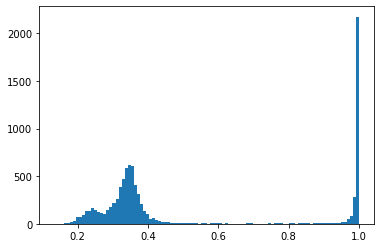

In [52]:
if __name__ == '__main__':
    main(train_df)

if CFG.epochs > 100:
    from IPython.display import clear_output  # セルの出力削除（1000epもログあると重すぎるので消す）
    clear_output()

In [53]:
#%debug

In [54]:
#=====

# Predict and submit

In [55]:
@torch.inference_mode()  # pytorch >= 1.9
def inference(model, pth, test_loader, device, tta_transforms=None):
    if len(CFG.device_ids) > 1:
        model.load_state_dict(loadpth(pth))
    else:
        model.load_state_dict(torch.load(pth)['model'])
    model.eval().to(device)
    
    if len(CFG.device_ids) > 1:
        LOGGER.info(f"=> inference is_multiGPU {CFG.device_ids}")
        model = nn.DataParallel(model)  # make parallel
        cudnn.benchmark = True
    
    # ttach
    if tta_transforms is not None:
        model = tta.ClassificationTTAWrapper(model, tta_transforms)
    
    preds = []
    for i, (images, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
        images = images.to(device)
        with torch.no_grad():
            outputs = model(images)
        # for BCE
        preds.append(outputs.sigmoid().cpu().detach().numpy())
    
    predictions = np.concatenate(preds)
    
    # 推論うまくいかず欠損になったのは0にする
    predictions = np.nan_to_num(predictions, nan=0)
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    return predictions

In [56]:
def main_test(test, pths, tta_transforms=None, transforms_type="valid", test_dataset=None):
    model = eval(CFG.model_cls)()
    if test_dataset is None:
        test_dataset = TrainDataset(test, 
                                    transforms=get_transforms(data=transforms_type),
                                    is_npy=CFG.is_npy,
                                    is_add_ch=CFG.is_add_ch,
                                   )
    test_loader = DataLoader(test_dataset, 
                             batch_size=CFG.batch_size * 2, 
                             shuffle=False, 
                             num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    predictions = None
    for pth in pths:
        print("pth:", pth)
        
        # inference
        if predictions is None:
            predictions = inference(model, pth, test_loader, device, tta_transforms)
        else:
            predictions += inference(model, pth, test_loader, device, tta_transforms)

    test['preds'] = predictions / len(pths)
    
    return test

In [57]:
# ttach param
# https://www.guruguru.science/competitions/17/discussions/4864ee81-6336-4cad-bb74-a4c9b46e6eb2/
tta_transforms = tta.Compose(
    [
        #tta.HorizontalFlip(),
        #tta.VerticalFlip(),
        #tta.Rotate90(angles=[0, 90, 180, 270]),  # 90度回転
        #tta.Scale(scales=[0.9, 1.1], interpolation="nearest"),  # 画像の大きさscales倍. h * scale_factor, w * scale_factor
        #tta.Add(values=[-1, 0, 1, 2]),  # 画素にfactorの値足す. x + value
        #tta.Multiply(factors=[0.9, 1, 1.1]),  # 画素をfactor倍. x * factor
        #tta.FiveCrops(crop_height=CFG.size//3, crop_width=CFG.size//3),  # 画像を5分割. crop_height: cropする画像の高さ. crop_width: cropする画像の幅
        #tta.Resize(sizes=[(224, 224), (384, 384)], original_size=(CFG.size, CFG.size), interpolation="nearest")  # 指定の大きさにリサイズ
    ]
)
tta_transforms = None

In [58]:
## ==========================================================
## valid inference
## ==========================================================
#seed = CFG.seeds[0]
#valid = pd.read_csv(OUTPUT_DIR + f"/folds_seed{seed}.csv")
#
## tta inference
#pred_valid = pd.DataFrame()
#for fold in CFG.trn_fold:
#    print(f"===== valid fold{fold} =====")
#    
#    # model pths
#    pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + f"/*_fold{fold}*_best_loss.pth"))
#    print(pths)
#    
#    valid_f = valid[valid.fold == fold]
#    print(valid_f.shape)
#    
#    valid_f = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
#    
#    ## =============================
#    ## tta alb
#    ## =============================
#    #valid_f_tta1 = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
#    #valid_f_tta1 = valid_f_tta1.rename(columns={"preds": "preds_tta1"})
#    #
#    #valid_f = pd.merge(valid_f, valid_f_tta1[["id", "preds_tta1"]], on="id")
#    #valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_tta1"].to_numpy()) / 2.0
#    ## =============================
#    
#    # =============================
#    # tta Dataset
#    # =============================
#    _test_dataset = TrainDataset(valid_f, 
#                                 transforms=get_transforms(data="valid"),
#                                 #prob_spec_start_random=1.0,
#                                 #prob_vshift=1.0,  # CV悪化
#                                 prob_swap_nega=1.0,  # CV悪化
#                                 is_npy=CFG.is_npy,
#                                 is_add_ch=CFG.is_add_ch,
#                               )
#    valid_f_ttaD = main_test(valid_f, pths=pths, tta_transforms=tta_transforms, transforms_type="valid", test_dataset=_test_dataset)
#    valid_f_ttaD = valid_f_ttaD.rename(columns={"preds": "preds_ttaD"})
#    
#    valid_f = pd.merge(valid_f, valid_f_ttaD[["id", "preds_ttaD"]], on="id")
#    valid_f["preds"] = (valid_f["preds"].to_numpy() + valid_f["preds_ttaD"].to_numpy()) / 2.0
#    # =============================
#    
#    _ = get_result(valid_f, preds_col="preds", add_info=f"TTA fold{fold} ")
#    pred_valid = pd.concat([pred_valid, valid_f])
#    
#tta_oof_score = get_result(pred_valid, preds_col="preds", add_info=f"TTA oof ")
#pred_valid.to_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{seed}_tta.csv', index=False)
#display(pred_valid.head())
#
##if CFG.is_wandb:
##    # save log wandb
##    wandb.log({f"TTA oof Score": tta_oof_score})

In [59]:
#%debug

['/volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800_fold0_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800_fold1_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800_fold2_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800_fold3_seed0_best_score.pth', '/volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.01it/s]


pth: /volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800_fold1_seed0_best_score.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.03it/s]


pth: /volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800_fold2_seed0_best_score.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.04it/s]


pth: /volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800_fold3_seed0_best_score.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.01it/s]


pth: /volume/kaggle/g2net2/output/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800/3090_kqi_ex073_pseudo_add_ex003_2-005-01_005iso-01_006_b5_ap_add_pseudo_EX007_800_fold4_seed0_best_score.pth


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:10<00:00,  6.00it/s]


id    freq min    freq max  H1 SFTs h  H1 SFTs w   H1 time min  \
0  00054c878  306.402222  306.601667      360.0     4639.0  1.238170e+09   
1  0007285a3  126.348889  126.548333      360.0     4427.0  1.238168e+09   
2  00076c5a6  197.289444  197.488889      360.0     4599.0  1.238169e+09   
3  001349290   94.908333   95.107778      360.0     4609.0  1.238171e+09   
4  001a52e92  464.077222  464.276667      360.0     4601.0  1.238167e+09   

    H1 time max  H1 max inteval  L1 SFTs h  L1 SFTs w  ...    h1_std  \
0  1.248567e+09         43102.0      360.0     4566.0  ...  0.397542   
1  1.248520e+09         42746.0      360.0     4650.0  ...  0.399520   
2  1.248535e+09         55878.0      360.0     4633.0  ...  0.399082   
3  1.248536e+09         48020.0      360.0     4621.0  ...  0.399954   
4  1.248535e+09         45246.0      360.0     4366.0  ...  0.402394   

     l1_std     h1_minstd     h1_maxstd h1_stddiff     l1_minstd  \
0  0.397476  1.058791e-22  1.058791e-22        0.0  1.058791e-22   
1  0.399918  1.058791e-22  1.058791e-22        0.0  1.058791e-22   
2  0.401004  1.058791e-22  1.058791e-22        0.0  1.058791e-22   
3  0.399532  1.058791e-22  1.058791e-22        0.0  1.058791e-22   
4  0.400455  1.058791e-22  1.058791e-22        0.0  1.058791e-22   

      l1_maxstd  l1_stddiff  h1_max/l1_max     preds  
0  1.058791e-22         0.0       1.085967  0.286716  
1  1.058791e-22         0.0       0.971284  0.433600  
2  1.058791e-22         0.0       1.037622  0.305712  
3  1.058791e-22         0.0       1.025819  0.314652  
4  1.058791e-22         0.0       0.976649  0.318952  

[5 rows x 27 columns]

target range [0.069546, 0.999999]


id    target
0     00054c878  0.286716
1     0007285a3  0.433600
2     00076c5a6  0.305712
3     001349290  0.314652
4     001a52e92  0.318952
...         ...       ...
7970  ffbce04ef  0.978600
7971  ffc2d976b  0.282469
7972  ffc905909  0.270371
7973  ffe276f3e  0.331983
7974  fffa17f67  0.305219

[7975 rows x 2 columns]

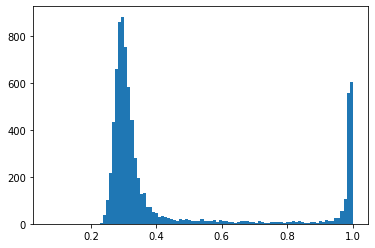

In [60]:
if IS_MAKE_SUB:
    # model pths
    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
    print(pths)

    # ==========================================================
    # test inference
    # ==========================================================
    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")

    ## =============================
    ## tta alb
    ## =============================
    #submit_tta1 = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="tta1")
    #submit_tta1 = submit_tta1.rename(columns={"preds": "preds_tta1"})
    #
    #submit = pd.merge(submit, submit_tta1[["id", "preds_tta1"]], on="id")
    #submit["preds"] = (submit["preds"].to_numpy() + submit["preds_tta1"].to_numpy()) / 2.0
    ## =============================

    submit["target"] = submit["preds"].to_numpy()
    display(submit.head())
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test.csv', index=False)
    
    submit = submit[["id", "target"]]
    print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))

    # Write prediction
    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv', index=False)
    display(submit)

    plt.hist(submit["target"], bins=100)
    plt.show()
    plt.clf()  # メモリ解放
    plt.close()

In [61]:
if CFG.is_wandb:
    wandb.finish()

In [62]:
## submitファイル連結
#if IS_MAKE_SUB:
#    
#    # シュミレーションデータのsubmitファイル
#    _name = CFG.name.replace("_real", "_sim")
#    sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_submission.csv'
#    
#    if os.path.isfile(sim_csv):
#        submit_real = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_submission.csv')
#        submit_sim = pd.read_csv(sim_csv)
#        submit = pd.concat([submit_sim, submit_real])
#        
#        # 行の順番をtest_dfの順番にする
#        test_df = pd.read_csv(INPUT_DIR_TEST + '/sample_submission.csv')
#        submit = pd.merge(test_df[["id"]], submit, on="id")
#        
#        submit = submit[["id", "target"]]
#        print('target range [%.6f, %.6f]' % (submit['target'].min(), submit['target'].max()))
#
#        # Write prediction
#        submit.to_csv(OUTPUT_DIR + f'/{CFG.name.split("_real")[0]}_sim_real_submission.csv', index=False)
#        display(submit)
#
#        plt.hist(submit["target"], bins=100)
#        plt.show()
#        plt.clf()  # メモリ解放
#        plt.close()

# Stacking

In [63]:
#### stacking用にtest set全体で推論
#test_df = pd.read_csv(f"./kaggle_dl/eda-g2net2-detecting-continuous-gw_v3/test_summary.csv").rename(columns={"Unnamed: 0":'id'})
#test_df["target"] = 0.5
#if cfg_is_npy:
#    test_df["path"] = f"{_npy_dir}/test/" + test_df["id"] + ".npy"
#else:
#    test_df["path"] = INPUT_DIR_TEST + "/test/" + test_df["id"] + ".hdf5"
#    
#if IS_MAKE_SUB:
#    pths = sorted(glob.glob(OUTPUT_DIR + "/*best_score.pth"))
#    #pths = sorted(glob.glob(OUTPUT_DIR + "/*best_loss.pth"))
#    
#    submit = main_test(test_df, pths=pths, tta_transforms=tta_transforms, transforms_type="valid")
#
#    submit["target"] = submit["preds"].to_numpy()
#    display(submit.head())
#    submit.to_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv', index=False)

In [64]:
import joblib
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def set_seed(seed=0):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def table_train_fn(df, feature_cols, target_col, out_dir):
    os.makedirs(out_dir, exist_ok=True)

    lgb_params = {
            "objective": "binary",
            "learning_rate": 0.03,
            "n_estimators": 100_000,
        }
    
    Y_pred = np.zeros((len(df)))

    for i in tqdm(CFG.seeds):
        print(f"------------ seed:{i} ------------")
        set_seed(seed=i)
        folds = df.copy()

        for j in range(CFG.n_fold):
            print(f"------------ fold:{j} ------------")

            train = folds[folds["fold"] != j]
            val = folds[folds["fold"] == j]
            val_idx = val.index
            
            X_train, X_val = train[feature_cols], val[feature_cols]
            y_train, y_val = train[target_col], val[target_col]
            X_train, X_val = X_train.values, X_val.values
            y_train, y_val = y_train.values, y_val.values

            ### lgb.LGBMClassifier
            #model = lgb.LGBMClassifier(random_state=i, **lgb_params)
            #model.fit(X_train, y_train,
            #          eval_set=[(X_val, y_val)],
            #          eval_metric="error",
            #          early_stopping_rounds=100,
            #          verbose=-1,
            #         )
            
            ### RandomForestClassifier
            #model = RandomForestClassifier(random_state=i)
            #model = model.fit(X_train, y_train)
            
            ### LogisticRegression
            model = LogisticRegression(random_state=i)
            model = model.fit(X_train, y_train)
            
            pred = model.predict_proba(X_val) / len(CFG.seeds)
            Y_pred[val_idx] += pred[:,1]
            
            joblib.dump(model, out_dir + f"/model_seed_{i}_fold_{j}_{target_col}.jlb", compress=True)

    folds["pred"] = Y_pred
    print("oof score:", get_score(folds[target_col].values, folds["pred"].values))
    
    folds.to_csv(out_dir + f"/{target_col}_oof.csv", index=False)
    
    return folds

def table_test_fn(df, feature_cols, target_col, out_dir, model_paths):
    os.makedirs(out_dir, exist_ok=True)
    X = df[feature_cols]
    Y_pred = np.zeros((len(df)))
    for m_p in sorted(model_paths):
        model = joblib.load(m_p)
        
        ### LogisticRegression
        print("model.coef_:", model.coef_)
        
        pred = model.predict_proba(X) / len(model_paths)
        Y_pred += pred[:,1]
    df[target_col] = Y_pred
    df[["id", "target"]].to_csv(out_dir + f"/{target_col}_sub.csv", index=False)
    return df


#### train
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_oof_df_seed{CFG.seeds[0]}.csv'
#if os.path.isfile(sim_csv):
#    sim_oof = pd.read_csv(sim_csv)
#    real_oof = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_oof_df_seed{CFG.seeds[0]}.csv')
#    stacking_oof = pd.merge(real_oof[["id", "target", "fold", "preds"]], sim_oof[["id", "preds"]], on="id")
#    stacking_oof = stacking_oof.rename(columns={"preds_x":'real_p', "preds_y":'sim_p'})
#    #display(stacking_oof)
#    _ = table_train_fn(stacking_oof, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking")
#
#### test
#_name = CFG.name.replace("_real", "_sim")
#sim_csv = OUTPUT_DIR + f'/../{_name}/{_name}_test_all.csv'
#if os.path.isfile(sim_csv):
#    sim_sub = pd.read_csv(sim_csv)
#    real_sub = pd.read_csv(OUTPUT_DIR + f'/{CFG.name}_test_all.csv')
#    stacking_sub = pd.merge(real_sub[["id", "target"]], sim_sub[["id", "target"]], on="id")
#    stacking_sub = stacking_sub.rename(columns={"target_x":'real_p', "target_y":'sim_p'})
#    stacking_sub = table_test_fn(stacking_sub, ["real_p", "sim_p"], "target", OUTPUT_DIR + "/stacking", 
#                                 glob.glob(OUTPUT_DIR + "/stacking/*.jlb"))
#    display(stacking_sub)
#    plt.hist(stacking_sub["target"], bins=100)
#    plt.show()
#    plt.clf()  # メモリ解放
#    plt.close()